In [1]:
# Librairies diverses
import os
import re
import gc
import time
import string
import pickle
import warnings
from os import listdir
warnings.simplefilter(action='ignore', category=FutureWarning)

# Outils mathématiques et manipulation de données
import pandas as pd
import numpy as np
import scipy as sp

# Librairies graphiques
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import seaborn as sns
from textwrap import wrap

# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Target équilibration
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

# Data Augmentation
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from contextlib import contextmanager

# Cross-validation et hyperparamétrisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Transformateurs de variables
from sklearn import preprocessing
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

# Modèles de AA
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet
from xgboost import plot_importance

# Metriques de AA
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Réduction de dimensions
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA

# Création de pipelines
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# Plot settings
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (12,8)
sns.set()

In [2]:
df = pd.read_csv('df_for_models.csv')

In [3]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_CNT_PAYMENT_MEAN
0,100002,1,0,0,0,406597,24700,351000,0.018801,-9461,...,0,0,0.0,0,0,0,0,0,0.0,0.0
1,100003,0,1,0,0,1293502,35698,1129500,0.003541,-16765,...,0,0,0.0,0,0,0,0,0,0.0,0.0
2,100004,0,0,1,0,135000,6750,135000,0.010032,-19046,...,0,0,0.0,0,0,0,0,0,0.0,0.0
3,100006,0,1,0,0,312682,29686,297000,0.008019,-19005,...,0,0,0.0,0,0,0,0,0,0.0,0.0
4,100007,0,0,0,0,513000,21865,513000,0.028663,-19932,...,0,0,0.0,0,0,0,0,0,0.0,0.0


In [4]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# 1.Modelisation

## 1.1. La séparation en train et test

In [5]:
X = df.drop(['TARGET','SK_ID_CURR'], axis=1)
y = df.TARGET

In [6]:
x_train, x_test, y_train, y_test= train_test_split(X,
                                                   y,
                                                   train_size=0.8,
                                                   stratify=y,
                                                   random_state=42)

In [7]:
x_train.shape

(246005, 200)

In [8]:
y_train.shape

(246005,)

In [9]:
x_test.shape

(61502, 200)

In [10]:
y_test.shape

(61502,)

## 1.2.Target équilibration pour train 

In [11]:
def target(y):    
    target_values = y.value_counts()/len(y)*100
    plt.pie(target_values,
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            labels=["Approuver", "Désapprouver"],
            startangle=90)
    plt.title('Distribution de la variable cible en pourcentage')
    plt.show()

In [12]:
counter = Counter(y_train)
print(counter)

Counter({0: 226145, 1: 19860})


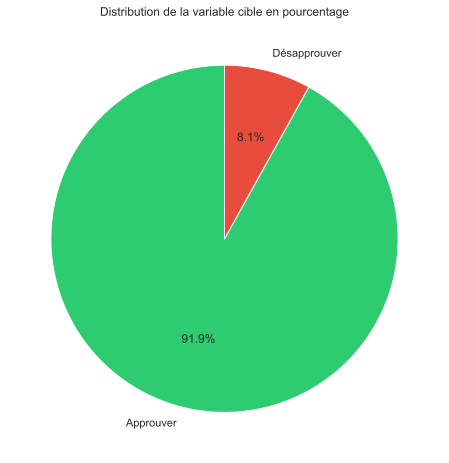

In [13]:
target(y_train)

In [14]:
counter = Counter(y_train)
print(counter)
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)
counter = Counter(y_train)
print(counter)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


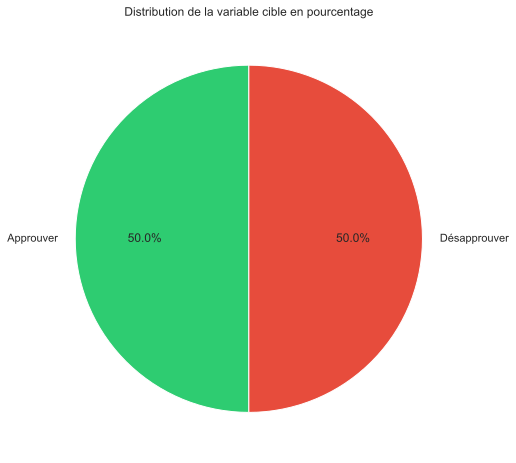

In [15]:
target(y_train)

## 1.3.Premières essays

In [16]:
# Dictionnaire de classifieurs 
classifiers = {'Dummy Classifier': DummyClassifier(),
               'Logistic Regression': LogisticRegression(),
               'Random Forest': RandomForestClassifier(),
               'LGBM': LGBMClassifier(),
               'Xgboost': XGBClassifier(),
               'Catboost': CatBoostClassifier()
              }

In [17]:
def fct_metrics(classifiers,X_train,Y_train,X_test,Y_test):
      
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    pred_dict={}
    results = pd.DataFrame({})

    for name_clf, clf in classifiers.items():
        print(name_clf)
        fit_classifier = clf.fit(X_train, Y_train)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]        
        fpr, tpr, _ = roc_curve(Y_test, y_pred_proba)
        y_pred=clf.predict(X_test)
        results = results.append(pd.DataFrame({'Modèle' : [name_clf],
                                               'Accuracy_score' : [accuracy_score(Y_test, y_pred)],
                                               'F1_score':[f1_score(Y_test, y_pred)]}),
                                 ignore_index=True)
        
        
        pred_dict[name_clf]=y_pred
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_ = auc(fpr, tpr)

        aucs.append(auc_)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_ = auc(fpr, tpr)

        aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)
        
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - specificite')
    plt.ylabel('Sensibilite')
    plt.title('La courbe ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    return(pred_dict,results)  
      

Dummy Classifier
Logistic Regression
Random Forest
LGBM
Xgboost


C:\Users\amaur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Catboost
Learning rate set to 0.140216
0:	learn: 0.5529174	total: 375ms	remaining: 6m 14s
1:	learn: 0.5047126	total: 518ms	remaining: 4m 18s
2:	learn: 0.4423410	total: 680ms	remaining: 3m 46s
3:	learn: 0.4167612	total: 805ms	remaining: 3m 20s
4:	learn: 0.3948487	total: 963ms	remaining: 3m 11s
5:	learn: 0.3780273	total: 1.09s	remaining: 3m 1s
6:	learn: 0.3555218	total: 1.24s	remaining: 2m 55s
7:	learn: 0.3449452	total: 1.36s	remaining: 2m 48s
8:	learn: 0.3342297	total: 1.5s	remaining: 2m 44s
9:	learn: 0.3254538	total: 1.64s	remaining: 2m 42s
10:	learn: 0.3174447	total: 1.75s	remaining: 2m 37s
11:	learn: 0.3098358	total: 1.9s	remaining: 2m 36s
12:	learn: 0.3027496	total: 2.02s	remaining: 2m 33s
13:	learn: 0.2969198	total: 2.18s	remaining: 2

154:	learn: 0.1606212	total: 20.5s	remaining: 1m 51s
155:	learn: 0.1605356	total: 20.6s	remaining: 1m 51s
156:	learn: 0.1604424	total: 20.7s	remaining: 1m 51s
157:	learn: 0.1601387	total: 20.8s	remaining: 1m 50s
158:	learn: 0.1598686	total: 21s	remaining: 1m 50s
159:	learn: 0.1597326	total: 21.1s	remaining: 1m 50s
160:	learn: 0.1596520	total: 21.2s	remaining: 1m 50s
161:	learn: 0.1595853	total: 21.3s	remaining: 1m 50s
162:	learn: 0.1594379	total: 21.4s	remaining: 1m 50s
163:	learn: 0.1593796	total: 21.6s	remaining: 1m 49s
164:	learn: 0.1591205	total: 21.7s	remaining: 1m 49s
165:	learn: 0.1590088	total: 21.8s	remaining: 1m 49s
166:	learn: 0.1586868	total: 21.9s	remaining: 1m 49s
167:	learn: 0.1586255	total: 22.1s	remaining: 1m 49s
168:	learn: 0.1585548	total: 22.2s	remaining: 1m 49s
169:	learn: 0.1584683	total: 22.3s	remaining: 1m 48s
170:	learn: 0.1584238	total: 22.4s	remaining: 1m 48s
171:	learn: 0.1583470	total: 22.5s	remaining: 1m 48s
172:	learn: 0.1574794	total: 22.7s	remaining: 1m

310:	learn: 0.1435429	total: 39.8s	remaining: 1m 28s
311:	learn: 0.1434907	total: 40s	remaining: 1m 28s
312:	learn: 0.1434221	total: 40.1s	remaining: 1m 28s
313:	learn: 0.1433687	total: 40.3s	remaining: 1m 27s
314:	learn: 0.1433372	total: 40.4s	remaining: 1m 27s
315:	learn: 0.1433063	total: 40.5s	remaining: 1m 27s
316:	learn: 0.1432356	total: 40.6s	remaining: 1m 27s
317:	learn: 0.1432054	total: 40.7s	remaining: 1m 27s
318:	learn: 0.1431744	total: 40.8s	remaining: 1m 27s
319:	learn: 0.1431102	total: 41s	remaining: 1m 27s
320:	learn: 0.1430822	total: 41.1s	remaining: 1m 26s
321:	learn: 0.1430390	total: 41.2s	remaining: 1m 26s
322:	learn: 0.1429714	total: 41.4s	remaining: 1m 26s
323:	learn: 0.1429335	total: 41.5s	remaining: 1m 26s
324:	learn: 0.1428939	total: 41.6s	remaining: 1m 26s
325:	learn: 0.1428495	total: 41.7s	remaining: 1m 26s
326:	learn: 0.1426870	total: 41.8s	remaining: 1m 26s
327:	learn: 0.1425693	total: 42s	remaining: 1m 25s
328:	learn: 0.1425156	total: 42.1s	remaining: 1m 25s

467:	learn: 0.1367283	total: 58.5s	remaining: 1m 6s
468:	learn: 0.1366866	total: 58.6s	remaining: 1m 6s
469:	learn: 0.1366603	total: 58.7s	remaining: 1m 6s
470:	learn: 0.1366159	total: 58.8s	remaining: 1m 6s
471:	learn: 0.1365923	total: 59s	remaining: 1m 5s
472:	learn: 0.1365573	total: 59.1s	remaining: 1m 5s
473:	learn: 0.1365302	total: 59.2s	remaining: 1m 5s
474:	learn: 0.1364893	total: 59.3s	remaining: 1m 5s
475:	learn: 0.1364595	total: 59.4s	remaining: 1m 5s
476:	learn: 0.1363893	total: 59.6s	remaining: 1m 5s
477:	learn: 0.1363392	total: 59.7s	remaining: 1m 5s
478:	learn: 0.1363132	total: 59.8s	remaining: 1m 5s
479:	learn: 0.1362839	total: 59.9s	remaining: 1m 4s
480:	learn: 0.1362463	total: 1m	remaining: 1m 4s
481:	learn: 0.1362265	total: 1m	remaining: 1m 4s
482:	learn: 0.1361880	total: 1m	remaining: 1m 4s
483:	learn: 0.1361525	total: 1m	remaining: 1m 4s
484:	learn: 0.1361100	total: 1m	remaining: 1m 4s
485:	learn: 0.1360714	total: 1m	remaining: 1m 4s
486:	learn: 0.1360449	total: 1m	

625:	learn: 0.1315734	total: 1m 16s	remaining: 45.9s
626:	learn: 0.1315376	total: 1m 17s	remaining: 45.8s
627:	learn: 0.1314316	total: 1m 17s	remaining: 45.7s
628:	learn: 0.1313495	total: 1m 17s	remaining: 45.6s
629:	learn: 0.1313244	total: 1m 17s	remaining: 45.5s
630:	learn: 0.1312861	total: 1m 17s	remaining: 45.4s
631:	learn: 0.1312541	total: 1m 17s	remaining: 45.3s
632:	learn: 0.1312389	total: 1m 17s	remaining: 45.1s
633:	learn: 0.1312099	total: 1m 17s	remaining: 45s
634:	learn: 0.1311812	total: 1m 18s	remaining: 44.9s
635:	learn: 0.1311629	total: 1m 18s	remaining: 44.7s
636:	learn: 0.1311418	total: 1m 18s	remaining: 44.6s
637:	learn: 0.1311192	total: 1m 18s	remaining: 44.5s
638:	learn: 0.1310971	total: 1m 18s	remaining: 44.3s
639:	learn: 0.1310826	total: 1m 18s	remaining: 44.2s
640:	learn: 0.1310588	total: 1m 18s	remaining: 44.1s
641:	learn: 0.1310372	total: 1m 18s	remaining: 44s
642:	learn: 0.1309468	total: 1m 18s	remaining: 43.8s
643:	learn: 0.1309211	total: 1m 19s	remaining: 43.

782:	learn: 0.1271777	total: 1m 35s	remaining: 26.4s
783:	learn: 0.1271535	total: 1m 35s	remaining: 26.3s
784:	learn: 0.1271271	total: 1m 35s	remaining: 26.1s
785:	learn: 0.1271008	total: 1m 35s	remaining: 26s
786:	learn: 0.1270760	total: 1m 35s	remaining: 25.9s
787:	learn: 0.1270545	total: 1m 35s	remaining: 25.8s
788:	learn: 0.1270339	total: 1m 35s	remaining: 25.6s
789:	learn: 0.1270137	total: 1m 35s	remaining: 25.5s
790:	learn: 0.1269900	total: 1m 36s	remaining: 25.4s
791:	learn: 0.1269641	total: 1m 36s	remaining: 25.3s
792:	learn: 0.1269536	total: 1m 36s	remaining: 25.1s
793:	learn: 0.1269359	total: 1m 36s	remaining: 25s
794:	learn: 0.1269056	total: 1m 36s	remaining: 24.9s
795:	learn: 0.1268812	total: 1m 36s	remaining: 24.8s
796:	learn: 0.1268593	total: 1m 36s	remaining: 24.6s
797:	learn: 0.1268091	total: 1m 36s	remaining: 24.5s
798:	learn: 0.1267885	total: 1m 36s	remaining: 24.4s
799:	learn: 0.1267733	total: 1m 37s	remaining: 24.3s
800:	learn: 0.1267532	total: 1m 37s	remaining: 24.

939:	learn: 0.1233256	total: 1m 53s	remaining: 7.24s
940:	learn: 0.1233103	total: 1m 53s	remaining: 7.12s
941:	learn: 0.1233015	total: 1m 53s	remaining: 7s
942:	learn: 0.1232774	total: 1m 53s	remaining: 6.87s
943:	learn: 0.1232550	total: 1m 53s	remaining: 6.75s
944:	learn: 0.1232327	total: 1m 53s	remaining: 6.63s
945:	learn: 0.1231940	total: 1m 54s	remaining: 6.51s
946:	learn: 0.1231735	total: 1m 54s	remaining: 6.39s
947:	learn: 0.1231515	total: 1m 54s	remaining: 6.27s
948:	learn: 0.1231318	total: 1m 54s	remaining: 6.15s
949:	learn: 0.1231122	total: 1m 54s	remaining: 6.03s
950:	learn: 0.1230988	total: 1m 54s	remaining: 5.91s
951:	learn: 0.1230872	total: 1m 54s	remaining: 5.79s
952:	learn: 0.1230497	total: 1m 54s	remaining: 5.67s
953:	learn: 0.1230242	total: 1m 55s	remaining: 5.54s
954:	learn: 0.1230036	total: 1m 55s	remaining: 5.42s
955:	learn: 0.1229801	total: 1m 55s	remaining: 5.3s
956:	learn: 0.1229111	total: 1m 55s	remaining: 5.18s
957:	learn: 0.1228804	total: 1m 55s	remaining: 5.0

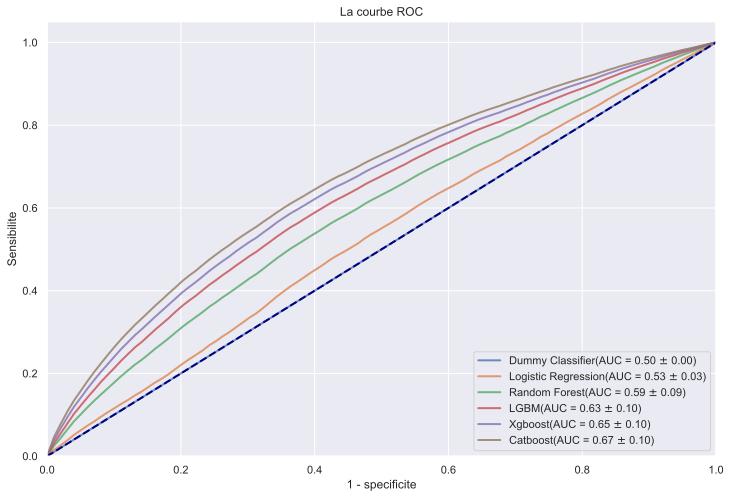

In [18]:
dict_clf,info_score=fct_metrics(classifiers,x_train,y_train,x_test,y_test)

In [19]:
info_score

,Modèle,Accuracy_score,F1_score
0,Dummy Classifier,0.919271,0.000000
1,Logistic Regression,0.790543,0.127472
2,Random Forest,0.916247,0.048753
3,LGBM,0.911613,0.099105
4,Xgboost,0.913596,0.135654
5,Catboost,0.917108,0.120124


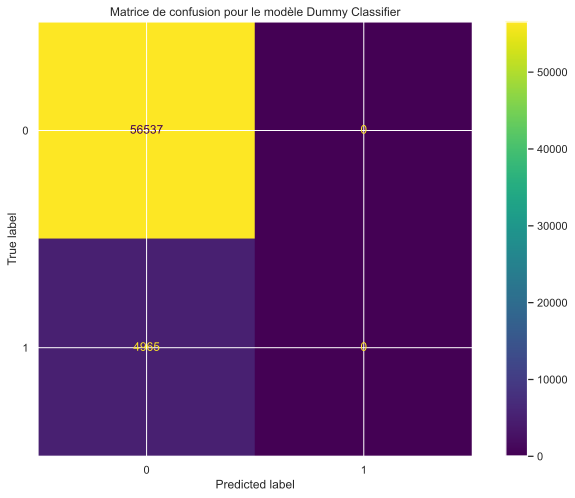

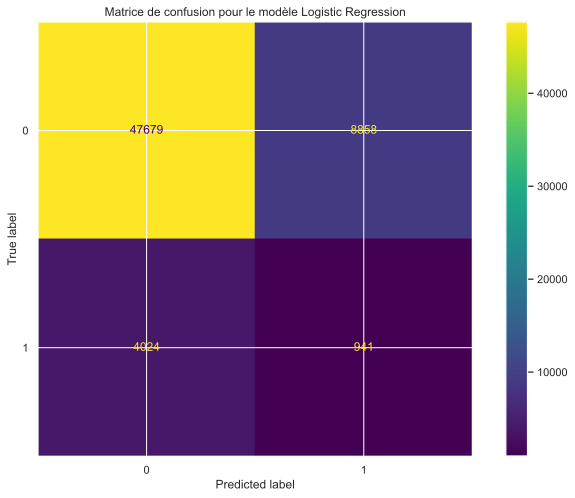

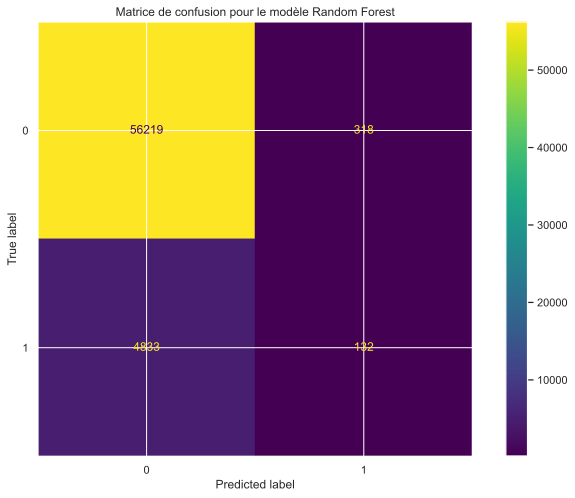

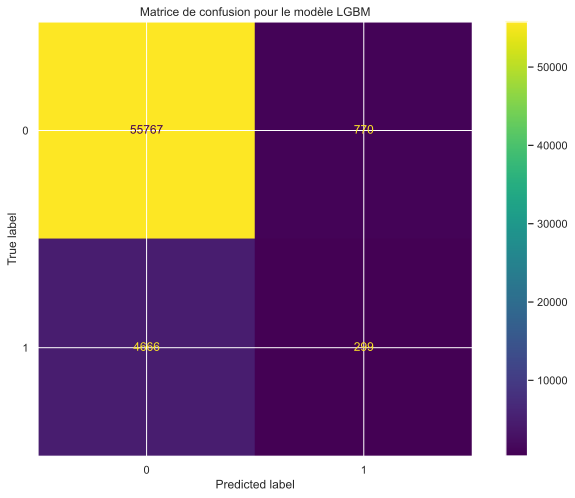

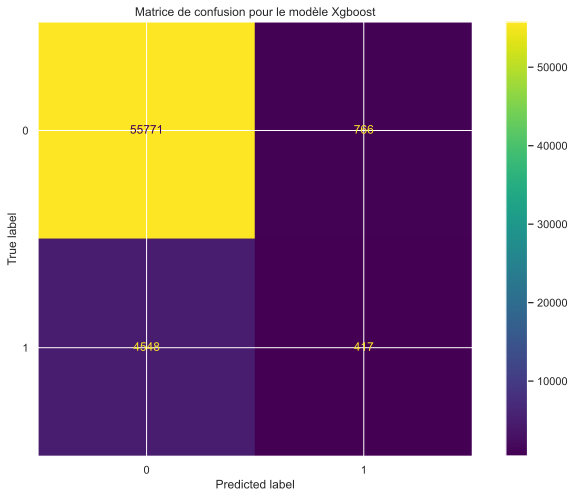

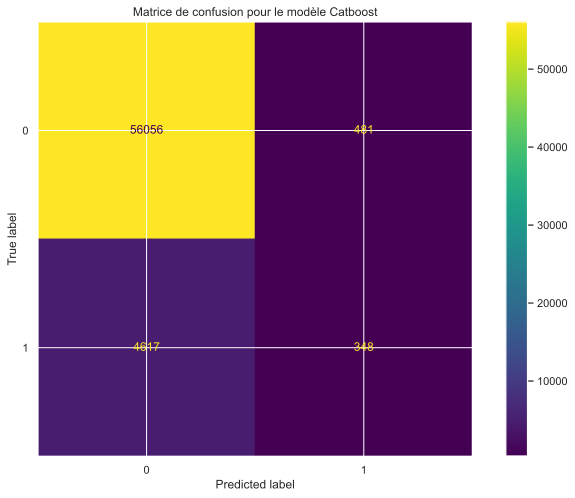

In [20]:
for name_clf, clf in dict_clf.items():
    cm = confusion_matrix(y_test,clf)
        
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    disp.ax_.set_title('Matrice de confusion pour le modèle '+str(name_clf))    

## Fonction bancaire

In [21]:
def metric_bank(y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1):

    mat_conf = confusion_matrix(y_true, y_pred)
    tn = mat_conf[0, 0]
    fn = mat_conf[1, 0]
    fp = mat_conf[0, 1]
    tp = mat_conf[1, 1]
    print(fn)
    
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    
    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
        
    return J_normalized  # Retourne la fonction d'évaluation

On va choisir le meilleur model, grâce à la métrique adapte à notre problématique:

In [22]:
for name_clf, clf in dict_clf.items():
    print()
    print(str(name_clf)+':')
    print(metric_bank(y_test, clf))


Dummy Classifier:
4965
0.5324286400406829

Logistic Regression:
4024
0.5376270164897775

Random Forest:
4833
0.5418648233776263

LGBM:
4666
0.553335154020737

Xgboost:
4548
0.5644852948100991

Catboost:
4617
0.5606712686110352


In [23]:
bank_scorer = make_scorer(metric_bank)

# Optimisation les meilleures modèles

In [24]:
def auc(m, train,y_train, test,y_test): 
    return (metrics.roc_auc_score(y_train,m.predict(train)),
            metrics.roc_auc_score(y_test,m.predict(test)))

## CatBoostClassifier()

In [26]:
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
cb = CatBoostClassifier()
cb_model = GridSearchCV(cb, 
                        params, 
                        scoring=bank_scorer, 
                        cv = 3,
                        verbose=3,
                       )
cb_model.fit(x_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0:	learn: 0.6674177	total: 84.1ms	remaining: 25.1s
1:	learn: 0.6441006	total: 168ms	remaining: 25s
2:	learn: 0.6306435	total: 242ms	remaining: 23.9s
3:	learn: 0.6119597	total: 324ms	remaining: 24s
4:	learn: 0.6014756	total: 394ms	remaining: 23.2s
5:	learn: 0.5834661	total: 475ms	remaining: 23.3s
6:	learn: 0.5739991	total: 545ms	remaining: 22.8s
7:	learn: 0.5653855	total: 618ms	remaining: 22.5s
8:	learn: 0.5511895	total: 696ms	remaining: 22.5s
9:	learn: 0.5433567	total: 773ms	remaining: 22.4s
10:	learn: 0.5352678	total: 851ms	remaining: 22.4s
11:	learn: 0.5282012	total: 922ms	remaining: 22.1s
12:	learn: 0.5069104	total: 1s	remaining: 22.1s
13:	learn: 0.5007362	total: 1.07s	remaining: 21.9s
14:	learn: 0.4930805	total: 1.14s	remaining: 21.6s
15:	learn: 0.4821591	total: 1.23s	remaining: 21.8s
16:	learn: 0.4652792	total: 1.3s	remaining: 21.6s
17:	learn: 0.4587334	total: 1.36s	remaining: 21.3s
18:	learn: 0.4526478	total: 1.43s	rema

160:	learn: 0.1737668	total: 11s	remaining: 9.52s
161:	learn: 0.1730605	total: 11.1s	remaining: 9.46s
162:	learn: 0.1725500	total: 11.2s	remaining: 9.39s
163:	learn: 0.1719585	total: 11.3s	remaining: 9.33s
164:	learn: 0.1714909	total: 11.3s	remaining: 9.26s
165:	learn: 0.1710541	total: 11.4s	remaining: 9.19s
166:	learn: 0.1706069	total: 11.4s	remaining: 9.11s
167:	learn: 0.1699854	total: 11.5s	remaining: 9.04s
168:	learn: 0.1695779	total: 11.6s	remaining: 8.97s
169:	learn: 0.1691092	total: 11.6s	remaining: 8.9s
170:	learn: 0.1685324	total: 11.7s	remaining: 8.82s
171:	learn: 0.1681005	total: 11.8s	remaining: 8.75s
172:	learn: 0.1676730	total: 11.8s	remaining: 8.69s
173:	learn: 0.1672622	total: 11.9s	remaining: 8.61s
174:	learn: 0.1657183	total: 12s	remaining: 8.54s
175:	learn: 0.1651857	total: 12s	remaining: 8.47s
176:	learn: 0.1647255	total: 12.1s	remaining: 8.4s
177:	learn: 0.1641622	total: 12.2s	remaining: 8.33s
178:	learn: 0.1637091	total: 12.2s	remaining: 8.26s
179:	learn: 0.162775

18:	learn: 0.4941244	total: 1.42s	remaining: 21.1s
19:	learn: 0.4908498	total: 1.49s	remaining: 20.9s
20:	learn: 0.4870154	total: 1.56s	remaining: 20.7s
21:	learn: 0.4833969	total: 1.63s	remaining: 20.6s
22:	learn: 0.4804428	total: 1.7s	remaining: 20.4s
23:	learn: 0.4731736	total: 1.78s	remaining: 20.5s
24:	learn: 0.4702942	total: 1.84s	remaining: 20.3s
25:	learn: 0.4658123	total: 1.91s	remaining: 20.1s
26:	learn: 0.4628357	total: 1.98s	remaining: 20s
27:	learn: 0.4592682	total: 2.05s	remaining: 19.9s
28:	learn: 0.4563924	total: 2.13s	remaining: 19.9s
29:	learn: 0.4504421	total: 2.21s	remaining: 19.9s
30:	learn: 0.4477435	total: 2.28s	remaining: 19.8s
31:	learn: 0.4453268	total: 2.34s	remaining: 19.6s
32:	learn: 0.4417983	total: 2.41s	remaining: 19.5s
33:	learn: 0.4383440	total: 2.48s	remaining: 19.4s
34:	learn: 0.4358741	total: 2.56s	remaining: 19.4s
35:	learn: 0.4337569	total: 2.62s	remaining: 19.2s
36:	learn: 0.4316772	total: 2.7s	remaining: 19.2s
37:	learn: 0.4294554	total: 2.77s	r

181:	learn: 0.2880872	total: 12.3s	remaining: 7.99s
182:	learn: 0.2866670	total: 12.4s	remaining: 7.93s
183:	learn: 0.2864268	total: 12.5s	remaining: 7.86s
184:	learn: 0.2861660	total: 12.5s	remaining: 7.79s
185:	learn: 0.2855204	total: 12.6s	remaining: 7.72s
186:	learn: 0.2847256	total: 12.7s	remaining: 7.65s
187:	learn: 0.2843140	total: 12.7s	remaining: 7.58s
188:	learn: 0.2840947	total: 12.8s	remaining: 7.51s
189:	learn: 0.2836532	total: 12.9s	remaining: 7.44s
190:	learn: 0.2834333	total: 12.9s	remaining: 7.37s
191:	learn: 0.2832247	total: 13s	remaining: 7.3s
192:	learn: 0.2829209	total: 13s	remaining: 7.23s
193:	learn: 0.2827036	total: 13.1s	remaining: 7.16s
194:	learn: 0.2824938	total: 13.2s	remaining: 7.09s
195:	learn: 0.2822482	total: 13.2s	remaining: 7.01s
196:	learn: 0.2815425	total: 13.3s	remaining: 6.95s
197:	learn: 0.2808691	total: 13.4s	remaining: 6.89s
198:	learn: 0.2806401	total: 13.4s	remaining: 6.81s
199:	learn: 0.2802993	total: 13.5s	remaining: 6.75s
200:	learn: 0.280

40:	learn: 0.4146268	total: 3.03s	remaining: 19.1s
41:	learn: 0.4128814	total: 3.09s	remaining: 19s
42:	learn: 0.4111265	total: 3.15s	remaining: 18.8s
43:	learn: 0.4092055	total: 3.21s	remaining: 18.7s
44:	learn: 0.4073992	total: 3.28s	remaining: 18.6s
45:	learn: 0.4048389	total: 3.35s	remaining: 18.5s
46:	learn: 0.4025293	total: 3.42s	remaining: 18.4s
47:	learn: 0.4010188	total: 3.48s	remaining: 18.2s
48:	learn: 0.3974841	total: 3.55s	remaining: 18.2s
49:	learn: 0.3957565	total: 3.63s	remaining: 18.1s
50:	learn: 0.3943475	total: 3.69s	remaining: 18s
51:	learn: 0.3924728	total: 3.76s	remaining: 17.9s
52:	learn: 0.3909764	total: 3.81s	remaining: 17.8s
53:	learn: 0.3877378	total: 3.9s	remaining: 17.8s
54:	learn: 0.3863046	total: 3.98s	remaining: 17.7s
55:	learn: 0.3846458	total: 4.05s	remaining: 17.6s
56:	learn: 0.3831944	total: 4.11s	remaining: 17.5s
57:	learn: 0.3813766	total: 4.17s	remaining: 17.4s
58:	learn: 0.3798794	total: 4.23s	remaining: 17.3s
59:	learn: 0.3781169	total: 4.3s	rem

203:	learn: 0.2817339	total: 13.8s	remaining: 6.48s
204:	learn: 0.2814823	total: 13.8s	remaining: 6.41s
205:	learn: 0.2812094	total: 13.9s	remaining: 6.34s
206:	learn: 0.2808221	total: 14s	remaining: 6.28s
207:	learn: 0.2800180	total: 14s	remaining: 6.21s
208:	learn: 0.2795886	total: 14.1s	remaining: 6.14s
209:	learn: 0.2793493	total: 14.2s	remaining: 6.08s
210:	learn: 0.2790786	total: 14.2s	remaining: 6.01s
211:	learn: 0.2788839	total: 14.3s	remaining: 5.94s
212:	learn: 0.2786658	total: 14.4s	remaining: 5.87s
213:	learn: 0.2772582	total: 14.4s	remaining: 5.81s
214:	learn: 0.2770279	total: 14.5s	remaining: 5.74s
215:	learn: 0.2767341	total: 14.6s	remaining: 5.67s
216:	learn: 0.2765627	total: 14.6s	remaining: 5.59s
217:	learn: 0.2763947	total: 14.7s	remaining: 5.52s
218:	learn: 0.2761744	total: 14.7s	remaining: 5.45s
219:	learn: 0.2758727	total: 14.8s	remaining: 5.39s
220:	learn: 0.2756704	total: 14.9s	remaining: 5.32s
221:	learn: 0.2754036	total: 14.9s	remaining: 5.25s
222:	learn: 0.27

63:	learn: 0.1414265	total: 4.59s	remaining: 16.9s
64:	learn: 0.1404896	total: 4.66s	remaining: 16.8s
65:	learn: 0.1382315	total: 4.71s	remaining: 16.7s
66:	learn: 0.1372834	total: 4.77s	remaining: 16.6s
67:	learn: 0.1336700	total: 4.84s	remaining: 16.5s
68:	learn: 0.1318233	total: 4.91s	remaining: 16.4s
69:	learn: 0.1305400	total: 4.97s	remaining: 16.3s
70:	learn: 0.1297131	total: 5.03s	remaining: 16.2s
71:	learn: 0.1284549	total: 5.09s	remaining: 16.1s
72:	learn: 0.1276745	total: 5.15s	remaining: 16s
73:	learn: 0.1269203	total: 5.21s	remaining: 15.9s
74:	learn: 0.1257704	total: 5.29s	remaining: 15.9s
75:	learn: 0.1249452	total: 5.36s	remaining: 15.8s
76:	learn: 0.1242398	total: 5.42s	remaining: 15.7s
77:	learn: 0.1222650	total: 5.49s	remaining: 15.6s
78:	learn: 0.1210754	total: 5.55s	remaining: 15.5s
79:	learn: 0.1202767	total: 5.62s	remaining: 15.5s
80:	learn: 0.1185808	total: 5.68s	remaining: 15.4s
81:	learn: 0.1174740	total: 5.75s	remaining: 15.3s
82:	learn: 0.1169226	total: 5.81s

225:	learn: 0.0461691	total: 15s	remaining: 4.9s
226:	learn: 0.0460414	total: 15s	remaining: 4.84s
227:	learn: 0.0458024	total: 15.1s	remaining: 4.77s
228:	learn: 0.0455206	total: 15.2s	remaining: 4.7s
229:	learn: 0.0450817	total: 15.2s	remaining: 4.64s
230:	learn: 0.0449137	total: 15.3s	remaining: 4.57s
231:	learn: 0.0439324	total: 15.4s	remaining: 4.5s
232:	learn: 0.0435345	total: 15.5s	remaining: 4.44s
233:	learn: 0.0434379	total: 15.5s	remaining: 4.38s
234:	learn: 0.0431308	total: 15.6s	remaining: 4.31s
235:	learn: 0.0430108	total: 15.7s	remaining: 4.25s
236:	learn: 0.0428519	total: 15.7s	remaining: 4.18s
237:	learn: 0.0427709	total: 15.8s	remaining: 4.12s
238:	learn: 0.0422985	total: 15.9s	remaining: 4.05s
239:	learn: 0.0422228	total: 15.9s	remaining: 3.98s
240:	learn: 0.0421256	total: 16s	remaining: 3.91s
241:	learn: 0.0416440	total: 16s	remaining: 3.85s
242:	learn: 0.0410802	total: 16.1s	remaining: 3.78s
243:	learn: 0.0409962	total: 16.2s	remaining: 3.71s
244:	learn: 0.0408898	t

87:	learn: 0.2546124	total: 5.85s	remaining: 14.1s
88:	learn: 0.2539768	total: 5.91s	remaining: 14s
89:	learn: 0.2535310	total: 5.98s	remaining: 13.9s
90:	learn: 0.2530803	total: 6.03s	remaining: 13.9s
91:	learn: 0.2525659	total: 6.09s	remaining: 13.8s
92:	learn: 0.2522833	total: 6.15s	remaining: 13.7s
93:	learn: 0.2520189	total: 6.21s	remaining: 13.6s
94:	learn: 0.2516857	total: 6.28s	remaining: 13.5s
95:	learn: 0.2513247	total: 6.34s	remaining: 13.5s
96:	learn: 0.2510803	total: 6.4s	remaining: 13.4s
97:	learn: 0.2505359	total: 6.46s	remaining: 13.3s
98:	learn: 0.2502815	total: 6.51s	remaining: 13.2s
99:	learn: 0.2500484	total: 6.58s	remaining: 13.2s
100:	learn: 0.2497651	total: 6.63s	remaining: 13.1s
101:	learn: 0.2494708	total: 6.7s	remaining: 13s
102:	learn: 0.2489946	total: 6.77s	remaining: 13s
103:	learn: 0.2487530	total: 6.84s	remaining: 12.9s
104:	learn: 0.2483629	total: 6.9s	remaining: 12.8s
105:	learn: 0.2481094	total: 6.96s	remaining: 12.7s
106:	learn: 0.2478965	total: 7.01s

246:	learn: 0.2110239	total: 15.8s	remaining: 3.4s
247:	learn: 0.2109494	total: 15.9s	remaining: 3.33s
248:	learn: 0.2108916	total: 15.9s	remaining: 3.27s
249:	learn: 0.2108061	total: 16s	remaining: 3.2s
250:	learn: 0.2107212	total: 16.1s	remaining: 3.14s
251:	learn: 0.2106631	total: 16.1s	remaining: 3.07s
252:	learn: 0.2106142	total: 16.2s	remaining: 3.01s
253:	learn: 0.2105639	total: 16.3s	remaining: 2.94s
254:	learn: 0.2104770	total: 16.3s	remaining: 2.88s
255:	learn: 0.2104451	total: 16.4s	remaining: 2.81s
256:	learn: 0.2104057	total: 16.4s	remaining: 2.75s
257:	learn: 0.2101927	total: 16.5s	remaining: 2.69s
258:	learn: 0.2101440	total: 16.6s	remaining: 2.62s
259:	learn: 0.2100989	total: 16.6s	remaining: 2.56s
260:	learn: 0.2100287	total: 16.7s	remaining: 2.5s
261:	learn: 0.2099906	total: 16.8s	remaining: 2.43s
262:	learn: 0.2099273	total: 16.8s	remaining: 2.37s
263:	learn: 0.2098770	total: 16.9s	remaining: 2.3s
264:	learn: 0.2098154	total: 16.9s	remaining: 2.24s
265:	learn: 0.2097

108:	learn: 0.2423240	total: 7.2s	remaining: 12.6s
109:	learn: 0.2420716	total: 7.25s	remaining: 12.5s
110:	learn: 0.2414949	total: 7.31s	remaining: 12.4s
111:	learn: 0.2404859	total: 7.38s	remaining: 12.4s
112:	learn: 0.2402355	total: 7.45s	remaining: 12.3s
113:	learn: 0.2400099	total: 7.5s	remaining: 12.2s
114:	learn: 0.2397824	total: 7.58s	remaining: 12.2s
115:	learn: 0.2394601	total: 7.64s	remaining: 12.1s
116:	learn: 0.2392825	total: 7.7s	remaining: 12s
117:	learn: 0.2390588	total: 7.76s	remaining: 12s
118:	learn: 0.2388384	total: 7.82s	remaining: 11.9s
119:	learn: 0.2372288	total: 7.89s	remaining: 11.8s
120:	learn: 0.2355778	total: 7.96s	remaining: 11.8s
121:	learn: 0.2354243	total: 8.02s	remaining: 11.7s
122:	learn: 0.2352310	total: 8.08s	remaining: 11.6s
123:	learn: 0.2350679	total: 8.15s	remaining: 11.6s
124:	learn: 0.2349105	total: 8.21s	remaining: 11.5s
125:	learn: 0.2346970	total: 8.26s	remaining: 11.4s
126:	learn: 0.2339471	total: 8.32s	remaining: 11.3s
127:	learn: 0.23372

269:	learn: 0.2082175	total: 17.3s	remaining: 1.92s
270:	learn: 0.2081539	total: 17.4s	remaining: 1.86s
271:	learn: 0.2080874	total: 17.4s	remaining: 1.79s
272:	learn: 0.2079135	total: 17.5s	remaining: 1.73s
273:	learn: 0.2078664	total: 17.6s	remaining: 1.67s
274:	learn: 0.2078137	total: 17.6s	remaining: 1.6s
275:	learn: 0.2077315	total: 17.7s	remaining: 1.54s
276:	learn: 0.2076586	total: 17.8s	remaining: 1.48s
277:	learn: 0.2076176	total: 17.8s	remaining: 1.41s
278:	learn: 0.2075719	total: 17.9s	remaining: 1.35s
279:	learn: 0.2075402	total: 17.9s	remaining: 1.28s
280:	learn: 0.2074978	total: 18s	remaining: 1.22s
281:	learn: 0.2074383	total: 18.1s	remaining: 1.15s
282:	learn: 0.2073914	total: 18.1s	remaining: 1.09s
283:	learn: 0.2073418	total: 18.2s	remaining: 1.02s
284:	learn: 0.2073067	total: 18.3s	remaining: 961ms
285:	learn: 0.2071582	total: 18.3s	remaining: 897ms
286:	learn: 0.2070277	total: 18.4s	remaining: 833ms
287:	learn: 0.2069732	total: 18.5s	remaining: 769ms
288:	learn: 0.2

128:	learn: 0.0522418	total: 8.42s	remaining: 11.2s
129:	learn: 0.0517363	total: 8.48s	remaining: 11.1s
130:	learn: 0.0515789	total: 8.53s	remaining: 11s
131:	learn: 0.0505839	total: 8.59s	remaining: 10.9s
132:	learn: 0.0489599	total: 8.67s	remaining: 10.9s
133:	learn: 0.0487071	total: 8.75s	remaining: 10.8s
134:	learn: 0.0485263	total: 8.8s	remaining: 10.8s
135:	learn: 0.0479283	total: 8.89s	remaining: 10.7s
136:	learn: 0.0476872	total: 8.94s	remaining: 10.6s
137:	learn: 0.0474973	total: 9.01s	remaining: 10.6s
138:	learn: 0.0472543	total: 9.08s	remaining: 10.5s
139:	learn: 0.0470340	total: 9.15s	remaining: 10.5s
140:	learn: 0.0467760	total: 9.2s	remaining: 10.4s
141:	learn: 0.0465339	total: 9.26s	remaining: 10.3s
142:	learn: 0.0463304	total: 9.32s	remaining: 10.2s
143:	learn: 0.0460904	total: 9.38s	remaining: 10.2s
144:	learn: 0.0457481	total: 9.46s	remaining: 10.1s
145:	learn: 0.0452718	total: 9.54s	remaining: 10.1s
146:	learn: 0.0446509	total: 9.61s	remaining: 10s
147:	learn: 0.0441

288:	learn: 0.0194230	total: 18.8s	remaining: 716ms
289:	learn: 0.0193906	total: 18.9s	remaining: 651ms
290:	learn: 0.0193661	total: 18.9s	remaining: 585ms
291:	learn: 0.0193057	total: 19s	remaining: 520ms
292:	learn: 0.0192398	total: 19.1s	remaining: 456ms
293:	learn: 0.0192158	total: 19.1s	remaining: 391ms
294:	learn: 0.0191849	total: 19.2s	remaining: 325ms
295:	learn: 0.0191627	total: 19.2s	remaining: 260ms
296:	learn: 0.0191404	total: 19.3s	remaining: 195ms
297:	learn: 0.0191044	total: 19.4s	remaining: 130ms
298:	learn: 0.0190464	total: 19.4s	remaining: 65ms
299:	learn: 0.0189319	total: 19.5s	remaining: 0us
20222
[CV 1/3] END depth=4, iterations=300, l2_leaf_reg=1, learning_rate=0.15;, score=0.756 total time=  20.8s
0:	learn: 0.6051766	total: 86.2ms	remaining: 25.8s
1:	learn: 0.5662567	total: 154ms	remaining: 22.9s
2:	learn: 0.5387105	total: 226ms	remaining: 22.4s
3:	learn: 0.5133947	total: 303ms	remaining: 22.4s
4:	learn: 0.4777243	total: 385ms	remaining: 22.7s
5:	learn: 0.4280316

148:	learn: 0.2155287	total: 9.52s	remaining: 9.65s
149:	learn: 0.2154055	total: 9.58s	remaining: 9.58s
150:	learn: 0.2151407	total: 9.64s	remaining: 9.52s
151:	learn: 0.2150405	total: 9.7s	remaining: 9.45s
152:	learn: 0.2138065	total: 9.78s	remaining: 9.4s
153:	learn: 0.2134990	total: 9.85s	remaining: 9.34s
154:	learn: 0.2134138	total: 9.92s	remaining: 9.28s
155:	learn: 0.2132490	total: 9.98s	remaining: 9.21s
156:	learn: 0.2130732	total: 10s	remaining: 9.15s
157:	learn: 0.2110532	total: 10.1s	remaining: 9.1s
158:	learn: 0.2109628	total: 10.2s	remaining: 9.02s
159:	learn: 0.2108656	total: 10.2s	remaining: 8.97s
160:	learn: 0.2107856	total: 10.3s	remaining: 8.9s
161:	learn: 0.2105672	total: 10.4s	remaining: 8.85s
162:	learn: 0.2104185	total: 10.5s	remaining: 8.79s
163:	learn: 0.2103185	total: 10.5s	remaining: 8.72s
164:	learn: 0.2102375	total: 10.6s	remaining: 8.65s
165:	learn: 0.2101765	total: 10.6s	remaining: 8.58s
166:	learn: 0.2100959	total: 10.7s	remaining: 8.51s
167:	learn: 0.2095

6:	learn: 0.4195376	total: 530ms	remaining: 22.2s
7:	learn: 0.4087227	total: 600ms	remaining: 21.9s
8:	learn: 0.3995096	total: 662ms	remaining: 21.4s
9:	learn: 0.3923333	total: 736ms	remaining: 21.4s
10:	learn: 0.3845040	total: 804ms	remaining: 21.1s
11:	learn: 0.3746377	total: 869ms	remaining: 20.9s
12:	learn: 0.3690276	total: 936ms	remaining: 20.7s
13:	learn: 0.3609427	total: 1s	remaining: 20.5s
14:	learn: 0.3560858	total: 1.06s	remaining: 20.2s
15:	learn: 0.3447031	total: 1.14s	remaining: 20.3s
16:	learn: 0.3403690	total: 1.2s	remaining: 20s
17:	learn: 0.3368702	total: 1.26s	remaining: 19.8s
18:	learn: 0.3319233	total: 1.33s	remaining: 19.7s
19:	learn: 0.3283430	total: 1.41s	remaining: 19.7s
20:	learn: 0.3253735	total: 1.48s	remaining: 19.6s
21:	learn: 0.3219279	total: 1.54s	remaining: 19.5s
22:	learn: 0.3194261	total: 1.6s	remaining: 19.3s
23:	learn: 0.3169064	total: 1.66s	remaining: 19.1s
24:	learn: 0.3140133	total: 1.72s	remaining: 18.9s
25:	learn: 0.3119709	total: 1.78s	remainin

168:	learn: 0.2094991	total: 10.8s	remaining: 8.36s
169:	learn: 0.2093233	total: 10.9s	remaining: 8.3s
170:	learn: 0.2092128	total: 10.9s	remaining: 8.24s
171:	learn: 0.2084930	total: 11s	remaining: 8.17s
172:	learn: 0.2071249	total: 11.1s	remaining: 8.12s
173:	learn: 0.2070478	total: 11.1s	remaining: 8.05s
174:	learn: 0.2069881	total: 11.2s	remaining: 7.98s
175:	learn: 0.2068869	total: 11.2s	remaining: 7.91s
176:	learn: 0.2068208	total: 11.3s	remaining: 7.84s
177:	learn: 0.2067150	total: 11.3s	remaining: 7.78s
178:	learn: 0.2066112	total: 11.4s	remaining: 7.71s
179:	learn: 0.2065154	total: 11.5s	remaining: 7.66s
180:	learn: 0.2064305	total: 11.5s	remaining: 7.59s
181:	learn: 0.2063390	total: 11.6s	remaining: 7.53s
182:	learn: 0.2062655	total: 11.7s	remaining: 7.47s
183:	learn: 0.2062061	total: 11.7s	remaining: 7.41s
184:	learn: 0.2061321	total: 11.8s	remaining: 7.34s
185:	learn: 0.2060796	total: 11.9s	remaining: 7.27s
186:	learn: 0.2060160	total: 11.9s	remaining: 7.2s
187:	learn: 0.20

27:	learn: 0.4022561	total: 2.1s	remaining: 20.4s
28:	learn: 0.3987089	total: 2.17s	remaining: 20.3s
29:	learn: 0.3935755	total: 2.24s	remaining: 20.1s
30:	learn: 0.3838619	total: 2.32s	remaining: 20.1s
31:	learn: 0.3778879	total: 2.39s	remaining: 20s
32:	learn: 0.3748672	total: 2.46s	remaining: 19.9s
33:	learn: 0.3719473	total: 2.53s	remaining: 19.8s
34:	learn: 0.3690816	total: 2.59s	remaining: 19.6s
35:	learn: 0.3646732	total: 2.65s	remaining: 19.5s
36:	learn: 0.3620315	total: 2.72s	remaining: 19.3s
37:	learn: 0.3593626	total: 2.78s	remaining: 19.2s
38:	learn: 0.3553724	total: 2.85s	remaining: 19.1s
39:	learn: 0.3523244	total: 2.92s	remaining: 19s
40:	learn: 0.3488760	total: 2.98s	remaining: 18.9s
41:	learn: 0.3463541	total: 3.05s	remaining: 18.7s
42:	learn: 0.3433043	total: 3.12s	remaining: 18.7s
43:	learn: 0.3403596	total: 3.19s	remaining: 18.5s
44:	learn: 0.3381089	total: 3.26s	remaining: 18.5s
45:	learn: 0.3351948	total: 3.33s	remaining: 18.4s
46:	learn: 0.3323502	total: 3.39s	re

187:	learn: 0.1579874	total: 12.7s	remaining: 7.57s
188:	learn: 0.1574011	total: 12.8s	remaining: 7.51s
189:	learn: 0.1569525	total: 12.8s	remaining: 7.44s
190:	learn: 0.1564753	total: 12.9s	remaining: 7.37s
191:	learn: 0.1561089	total: 13s	remaining: 7.3s
192:	learn: 0.1557545	total: 13s	remaining: 7.23s
193:	learn: 0.1552998	total: 13.1s	remaining: 7.17s
194:	learn: 0.1549533	total: 13.2s	remaining: 7.1s
195:	learn: 0.1544763	total: 13.2s	remaining: 7.03s
196:	learn: 0.1537160	total: 13.3s	remaining: 6.96s
197:	learn: 0.1531435	total: 13.4s	remaining: 6.9s
198:	learn: 0.1528107	total: 13.5s	remaining: 6.83s
199:	learn: 0.1524584	total: 13.5s	remaining: 6.76s
200:	learn: 0.1519799	total: 13.6s	remaining: 6.69s
201:	learn: 0.1516368	total: 13.6s	remaining: 6.62s
202:	learn: 0.1509902	total: 13.7s	remaining: 6.54s
203:	learn: 0.1506205	total: 13.8s	remaining: 6.47s
204:	learn: 0.1500602	total: 13.8s	remaining: 6.41s
205:	learn: 0.1492090	total: 13.9s	remaining: 6.34s
206:	learn: 0.14851

48:	learn: 0.4045580	total: 3.57s	remaining: 18.3s
49:	learn: 0.4024153	total: 3.64s	remaining: 18.2s
50:	learn: 0.4010684	total: 3.71s	remaining: 18.1s
51:	learn: 0.3994442	total: 3.78s	remaining: 18s
52:	learn: 0.3979940	total: 3.85s	remaining: 17.9s
53:	learn: 0.3946771	total: 3.93s	remaining: 17.9s
54:	learn: 0.3932891	total: 3.99s	remaining: 17.8s
55:	learn: 0.3918206	total: 4.07s	remaining: 17.7s
56:	learn: 0.3905027	total: 4.12s	remaining: 17.6s
57:	learn: 0.3874272	total: 4.2s	remaining: 17.5s
58:	learn: 0.3839956	total: 4.28s	remaining: 17.5s
59:	learn: 0.3822015	total: 4.35s	remaining: 17.4s
60:	learn: 0.3807899	total: 4.41s	remaining: 17.3s
61:	learn: 0.3791208	total: 4.47s	remaining: 17.2s
62:	learn: 0.3778383	total: 4.53s	remaining: 17s
63:	learn: 0.3763444	total: 4.61s	remaining: 17s
64:	learn: 0.3747267	total: 4.68s	remaining: 16.9s
65:	learn: 0.3735502	total: 4.74s	remaining: 16.8s
66:	learn: 0.3723121	total: 4.8s	remaining: 16.7s
67:	learn: 0.3711200	total: 4.86s	remai

208:	learn: 0.2795561	total: 14.2s	remaining: 6.2s
209:	learn: 0.2793892	total: 14.3s	remaining: 6.13s
210:	learn: 0.2788714	total: 14.4s	remaining: 6.06s
211:	learn: 0.2786247	total: 14.4s	remaining: 5.99s
212:	learn: 0.2783653	total: 14.5s	remaining: 5.92s
213:	learn: 0.2780686	total: 14.6s	remaining: 5.86s
214:	learn: 0.2778851	total: 14.6s	remaining: 5.78s
215:	learn: 0.2776697	total: 14.7s	remaining: 5.72s
216:	learn: 0.2773486	total: 14.8s	remaining: 5.65s
217:	learn: 0.2767831	total: 14.8s	remaining: 5.58s
218:	learn: 0.2766107	total: 14.9s	remaining: 5.51s
219:	learn: 0.2755923	total: 15s	remaining: 5.44s
220:	learn: 0.2754331	total: 15s	remaining: 5.37s
221:	learn: 0.2752428	total: 15.1s	remaining: 5.29s
222:	learn: 0.2750062	total: 15.1s	remaining: 5.22s
223:	learn: 0.2746644	total: 15.2s	remaining: 5.16s
224:	learn: 0.2743909	total: 15.3s	remaining: 5.09s
225:	learn: 0.2742072	total: 15.3s	remaining: 5.02s
226:	learn: 0.2740246	total: 15.4s	remaining: 4.95s
227:	learn: 0.273

67:	learn: 0.3700222	total: 4.86s	remaining: 16.6s
68:	learn: 0.3689009	total: 4.92s	remaining: 16.5s
69:	learn: 0.3677751	total: 4.98s	remaining: 16.4s
70:	learn: 0.3665732	total: 5.06s	remaining: 16.3s
71:	learn: 0.3636978	total: 5.13s	remaining: 16.2s
72:	learn: 0.3617662	total: 5.19s	remaining: 16.2s
73:	learn: 0.3605243	total: 5.27s	remaining: 16.1s
74:	learn: 0.3596596	total: 5.34s	remaining: 16s
75:	learn: 0.3585252	total: 5.41s	remaining: 15.9s
76:	learn: 0.3576208	total: 5.47s	remaining: 15.9s
77:	learn: 0.3567741	total: 5.54s	remaining: 15.8s
78:	learn: 0.3556716	total: 5.6s	remaining: 15.7s
79:	learn: 0.3546764	total: 5.66s	remaining: 15.6s
80:	learn: 0.3537933	total: 5.72s	remaining: 15.5s
81:	learn: 0.3528961	total: 5.78s	remaining: 15.4s
82:	learn: 0.3519283	total: 5.84s	remaining: 15.3s
83:	learn: 0.3509518	total: 5.91s	remaining: 15.2s
84:	learn: 0.3493526	total: 5.98s	remaining: 15.1s
85:	learn: 0.3483790	total: 6.05s	remaining: 15.1s
86:	learn: 0.3476282	total: 6.11s	

229:	learn: 0.2727657	total: 15.5s	remaining: 4.72s
230:	learn: 0.2722061	total: 15.6s	remaining: 4.65s
231:	learn: 0.2719681	total: 15.6s	remaining: 4.58s
232:	learn: 0.2717730	total: 15.7s	remaining: 4.51s
233:	learn: 0.2715836	total: 15.8s	remaining: 4.45s
234:	learn: 0.2714209	total: 15.8s	remaining: 4.38s
235:	learn: 0.2712423	total: 15.9s	remaining: 4.31s
236:	learn: 0.2710226	total: 16s	remaining: 4.24s
237:	learn: 0.2708685	total: 16s	remaining: 4.17s
238:	learn: 0.2705417	total: 16.1s	remaining: 4.1s
239:	learn: 0.2703798	total: 16.1s	remaining: 4.04s
240:	learn: 0.2702059	total: 16.2s	remaining: 3.97s
241:	learn: 0.2700402	total: 16.3s	remaining: 3.9s
242:	learn: 0.2698596	total: 16.3s	remaining: 3.83s
243:	learn: 0.2697107	total: 16.4s	remaining: 3.76s
244:	learn: 0.2695707	total: 16.5s	remaining: 3.69s
245:	learn: 0.2693969	total: 16.5s	remaining: 3.63s
246:	learn: 0.2691099	total: 16.6s	remaining: 3.56s
247:	learn: 0.2689508	total: 16.7s	remaining: 3.49s
248:	learn: 0.2687

90:	learn: 0.1125622	total: 6.01s	remaining: 13.8s
91:	learn: 0.1118795	total: 6.07s	remaining: 13.7s
92:	learn: 0.1108552	total: 6.13s	remaining: 13.6s
93:	learn: 0.1101978	total: 6.19s	remaining: 13.6s
94:	learn: 0.1095477	total: 6.25s	remaining: 13.5s
95:	learn: 0.1081434	total: 6.33s	remaining: 13.4s
96:	learn: 0.1075655	total: 6.38s	remaining: 13.4s
97:	learn: 0.1070602	total: 6.45s	remaining: 13.3s
98:	learn: 0.1062035	total: 6.52s	remaining: 13.2s
99:	learn: 0.1057762	total: 6.58s	remaining: 13.2s
100:	learn: 0.1049252	total: 6.65s	remaining: 13.1s
101:	learn: 0.1043653	total: 6.71s	remaining: 13s
102:	learn: 0.1035655	total: 6.78s	remaining: 13s
103:	learn: 0.1031000	total: 6.84s	remaining: 12.9s
104:	learn: 0.1015779	total: 6.9s	remaining: 12.8s
105:	learn: 0.0997411	total: 6.97s	remaining: 12.8s
106:	learn: 0.0978243	total: 7.04s	remaining: 12.7s
107:	learn: 0.0964084	total: 7.1s	remaining: 12.6s
108:	learn: 0.0959131	total: 7.17s	remaining: 12.6s
109:	learn: 0.0950793	total:

250:	learn: 0.0439229	total: 16.6s	remaining: 3.23s
251:	learn: 0.0437866	total: 16.6s	remaining: 3.17s
252:	learn: 0.0434598	total: 16.7s	remaining: 3.1s
253:	learn: 0.0432356	total: 16.8s	remaining: 3.03s
254:	learn: 0.0431742	total: 16.8s	remaining: 2.97s
255:	learn: 0.0429580	total: 16.9s	remaining: 2.9s
256:	learn: 0.0428951	total: 17s	remaining: 2.84s
257:	learn: 0.0425170	total: 17s	remaining: 2.77s
258:	learn: 0.0424429	total: 17.1s	remaining: 2.7s
259:	learn: 0.0423665	total: 17.2s	remaining: 2.64s
260:	learn: 0.0422628	total: 17.2s	remaining: 2.57s
261:	learn: 0.0420998	total: 17.3s	remaining: 2.5s
262:	learn: 0.0419885	total: 17.3s	remaining: 2.44s
263:	learn: 0.0419382	total: 17.4s	remaining: 2.37s
264:	learn: 0.0417685	total: 17.4s	remaining: 2.3s
265:	learn: 0.0416992	total: 17.5s	remaining: 2.24s
266:	learn: 0.0416081	total: 17.6s	remaining: 2.17s
267:	learn: 0.0411764	total: 17.6s	remaining: 2.1s
268:	learn: 0.0404668	total: 17.7s	remaining: 2.04s
269:	learn: 0.0403932	

112:	learn: 0.2458629	total: 7.41s	remaining: 12.3s
113:	learn: 0.2455932	total: 7.47s	remaining: 12.2s
114:	learn: 0.2448910	total: 7.54s	remaining: 12.1s
115:	learn: 0.2446661	total: 7.6s	remaining: 12.1s
116:	learn: 0.2443345	total: 7.67s	remaining: 12s
117:	learn: 0.2437823	total: 7.72s	remaining: 11.9s
118:	learn: 0.2433799	total: 7.79s	remaining: 11.8s
119:	learn: 0.2428470	total: 7.85s	remaining: 11.8s
120:	learn: 0.2426323	total: 7.91s	remaining: 11.7s
121:	learn: 0.2400618	total: 7.98s	remaining: 11.6s
122:	learn: 0.2398683	total: 8.04s	remaining: 11.6s
123:	learn: 0.2396900	total: 8.1s	remaining: 11.5s
124:	learn: 0.2394914	total: 8.16s	remaining: 11.4s
125:	learn: 0.2390556	total: 8.21s	remaining: 11.3s
126:	learn: 0.2389164	total: 8.27s	remaining: 11.3s
127:	learn: 0.2386800	total: 8.32s	remaining: 11.2s
128:	learn: 0.2385042	total: 8.38s	remaining: 11.1s
129:	learn: 0.2382624	total: 8.44s	remaining: 11s
130:	learn: 0.2381001	total: 8.5s	remaining: 11s
131:	learn: 0.2377736

271:	learn: 0.2119906	total: 17.4s	remaining: 1.79s
272:	learn: 0.2119296	total: 17.4s	remaining: 1.72s
273:	learn: 0.2118834	total: 17.5s	remaining: 1.66s
274:	learn: 0.2118418	total: 17.6s	remaining: 1.6s
275:	learn: 0.2117642	total: 17.6s	remaining: 1.53s
276:	learn: 0.2117064	total: 17.7s	remaining: 1.47s
277:	learn: 0.2113611	total: 17.8s	remaining: 1.41s
278:	learn: 0.2112146	total: 17.8s	remaining: 1.34s
279:	learn: 0.2111026	total: 17.9s	remaining: 1.28s
280:	learn: 0.2110120	total: 18s	remaining: 1.21s
281:	learn: 0.2109591	total: 18s	remaining: 1.15s
282:	learn: 0.2108689	total: 18.1s	remaining: 1.09s
283:	learn: 0.2101216	total: 18.2s	remaining: 1.02s
284:	learn: 0.2100231	total: 18.2s	remaining: 960ms
285:	learn: 0.2098112	total: 18.3s	remaining: 896ms
286:	learn: 0.2097764	total: 18.4s	remaining: 832ms
287:	learn: 0.2097359	total: 18.4s	remaining: 768ms
288:	learn: 0.2096678	total: 18.5s	remaining: 703ms
289:	learn: 0.2096341	total: 18.5s	remaining: 640ms
290:	learn: 0.209

131:	learn: 0.2360212	total: 8.61s	remaining: 11s
132:	learn: 0.2358747	total: 8.67s	remaining: 10.9s
133:	learn: 0.2356788	total: 8.73s	remaining: 10.8s
134:	learn: 0.2355416	total: 8.79s	remaining: 10.7s
135:	learn: 0.2353664	total: 8.86s	remaining: 10.7s
136:	learn: 0.2337668	total: 8.92s	remaining: 10.6s
137:	learn: 0.2327002	total: 8.99s	remaining: 10.5s
138:	learn: 0.2313366	total: 9.05s	remaining: 10.5s
139:	learn: 0.2311594	total: 9.11s	remaining: 10.4s
140:	learn: 0.2310273	total: 9.18s	remaining: 10.3s
141:	learn: 0.2308369	total: 9.24s	remaining: 10.3s
142:	learn: 0.2306932	total: 9.3s	remaining: 10.2s
143:	learn: 0.2305267	total: 9.38s	remaining: 10.2s
144:	learn: 0.2304032	total: 9.43s	remaining: 10.1s
145:	learn: 0.2302721	total: 9.49s	remaining: 10s
146:	learn: 0.2301534	total: 9.54s	remaining: 9.93s
147:	learn: 0.2297571	total: 9.61s	remaining: 9.87s
148:	learn: 0.2296055	total: 9.67s	remaining: 9.8s
149:	learn: 0.2294892	total: 9.72s	remaining: 9.72s
150:	learn: 0.2293

291:	learn: 0.2066056	total: 18.8s	remaining: 515ms
292:	learn: 0.2065596	total: 18.9s	remaining: 450ms
293:	learn: 0.2064793	total: 18.9s	remaining: 386ms
294:	learn: 0.2064503	total: 19s	remaining: 322ms
295:	learn: 0.2063859	total: 19s	remaining: 257ms
296:	learn: 0.2063193	total: 19.1s	remaining: 193ms
297:	learn: 0.2062674	total: 19.2s	remaining: 129ms
298:	learn: 0.2062285	total: 19.2s	remaining: 64.4ms
299:	learn: 0.2061763	total: 19.3s	remaining: 0us
805
[CV 3/3] END depth=4, iterations=300, l2_leaf_reg=4, learning_rate=0.1;, score=0.988 total time=  20.6s
0:	learn: 0.5816364	total: 84.9ms	remaining: 25.4s
1:	learn: 0.5364843	total: 155ms	remaining: 23s
2:	learn: 0.4599800	total: 235ms	remaining: 23.2s
3:	learn: 0.4185907	total: 317ms	remaining: 23.5s
4:	learn: 0.3940381	total: 377ms	remaining: 22.3s
5:	learn: 0.3755138	total: 440ms	remaining: 21.6s
6:	learn: 0.3509727	total: 507ms	remaining: 21.2s
7:	learn: 0.3359274	total: 577ms	remaining: 21.1s
8:	learn: 0.3231911	total: 636

151:	learn: 0.0463250	total: 9.92s	remaining: 9.65s
152:	learn: 0.0462038	total: 9.97s	remaining: 9.58s
153:	learn: 0.0454851	total: 10s	remaining: 9.51s
154:	learn: 0.0452127	total: 10.1s	remaining: 9.44s
155:	learn: 0.0449536	total: 10.2s	remaining: 9.38s
156:	learn: 0.0447702	total: 10.2s	remaining: 9.32s
157:	learn: 0.0446643	total: 10.3s	remaining: 9.25s
158:	learn: 0.0445567	total: 10.4s	remaining: 9.18s
159:	learn: 0.0444572	total: 10.4s	remaining: 9.12s
160:	learn: 0.0441110	total: 10.5s	remaining: 9.05s
161:	learn: 0.0440003	total: 10.6s	remaining: 8.99s
162:	learn: 0.0425831	total: 10.6s	remaining: 8.94s
163:	learn: 0.0424747	total: 10.7s	remaining: 8.87s
164:	learn: 0.0419210	total: 10.8s	remaining: 8.8s
165:	learn: 0.0416907	total: 10.8s	remaining: 8.74s
166:	learn: 0.0414737	total: 10.9s	remaining: 8.67s
167:	learn: 0.0413498	total: 11s	remaining: 8.6s
168:	learn: 0.0410330	total: 11s	remaining: 8.54s
169:	learn: 0.0409043	total: 11.1s	remaining: 8.47s
170:	learn: 0.040819

9:	learn: 0.3840872	total: 753ms	remaining: 21.8s
10:	learn: 0.3760227	total: 815ms	remaining: 21.4s
11:	learn: 0.3660718	total: 881ms	remaining: 21.1s
12:	learn: 0.3611188	total: 941ms	remaining: 20.8s
13:	learn: 0.3561783	total: 1000ms	remaining: 20.4s
14:	learn: 0.3511864	total: 1.06s	remaining: 20.1s
15:	learn: 0.3465670	total: 1.13s	remaining: 20.1s
16:	learn: 0.3390811	total: 1.2s	remaining: 19.9s
17:	learn: 0.3355783	total: 1.27s	remaining: 19.9s
18:	learn: 0.3308619	total: 1.33s	remaining: 19.7s
19:	learn: 0.3266313	total: 1.41s	remaining: 19.7s
20:	learn: 0.3226917	total: 1.46s	remaining: 19.4s
21:	learn: 0.3203155	total: 1.53s	remaining: 19.3s
22:	learn: 0.3175399	total: 1.6s	remaining: 19.3s
23:	learn: 0.3149856	total: 1.67s	remaining: 19.1s
24:	learn: 0.3125069	total: 1.72s	remaining: 18.9s
25:	learn: 0.3096994	total: 1.79s	remaining: 18.8s
26:	learn: 0.3025224	total: 1.87s	remaining: 18.9s
27:	learn: 0.3000233	total: 1.93s	remaining: 18.7s
28:	learn: 0.2970874	total: 1.99s

171:	learn: 0.2121634	total: 11.1s	remaining: 8.25s
172:	learn: 0.2120017	total: 11.2s	remaining: 8.19s
173:	learn: 0.2119379	total: 11.2s	remaining: 8.12s
174:	learn: 0.2118816	total: 11.3s	remaining: 8.05s
175:	learn: 0.2114610	total: 11.3s	remaining: 7.99s
176:	learn: 0.2112850	total: 11.4s	remaining: 7.93s
177:	learn: 0.2110808	total: 11.5s	remaining: 7.86s
178:	learn: 0.2109673	total: 11.5s	remaining: 7.79s
179:	learn: 0.2108954	total: 11.6s	remaining: 7.74s
180:	learn: 0.2104217	total: 11.7s	remaining: 7.68s
181:	learn: 0.2103195	total: 11.8s	remaining: 7.63s
182:	learn: 0.2102131	total: 11.8s	remaining: 7.56s
183:	learn: 0.2101152	total: 11.9s	remaining: 7.5s
184:	learn: 0.2095948	total: 12s	remaining: 7.44s
185:	learn: 0.2095366	total: 12s	remaining: 7.37s
186:	learn: 0.2092313	total: 12.1s	remaining: 7.31s
187:	learn: 0.2091231	total: 12.2s	remaining: 7.25s
188:	learn: 0.2090634	total: 12.2s	remaining: 7.18s
189:	learn: 0.2090162	total: 12.3s	remaining: 7.11s
190:	learn: 0.208

30:	learn: 0.2924973	total: 2.14s	remaining: 18.6s
31:	learn: 0.2867934	total: 2.21s	remaining: 18.5s
32:	learn: 0.2855257	total: 2.27s	remaining: 18.4s
33:	learn: 0.2838433	total: 2.33s	remaining: 18.3s
34:	learn: 0.2819996	total: 2.41s	remaining: 18.2s
35:	learn: 0.2804142	total: 2.47s	remaining: 18.1s
36:	learn: 0.2788392	total: 2.54s	remaining: 18.1s
37:	learn: 0.2773952	total: 2.61s	remaining: 18s
38:	learn: 0.2763198	total: 2.67s	remaining: 17.9s
39:	learn: 0.2754153	total: 2.73s	remaining: 17.8s
40:	learn: 0.2724104	total: 2.8s	remaining: 17.7s
41:	learn: 0.2716262	total: 2.85s	remaining: 17.5s
42:	learn: 0.2691980	total: 2.92s	remaining: 17.5s
43:	learn: 0.2679305	total: 2.98s	remaining: 17.4s
44:	learn: 0.2670070	total: 3.04s	remaining: 17.3s
45:	learn: 0.2663183	total: 3.11s	remaining: 17.2s
46:	learn: 0.2647295	total: 3.17s	remaining: 17.1s
47:	learn: 0.2639968	total: 3.23s	remaining: 16.9s
48:	learn: 0.2627412	total: 3.29s	remaining: 16.8s
49:	learn: 0.2609947	total: 3.35s	

192:	learn: 0.2089670	total: 12.4s	remaining: 6.87s
193:	learn: 0.2088748	total: 12.5s	remaining: 6.81s
194:	learn: 0.2087043	total: 12.5s	remaining: 6.75s
195:	learn: 0.2086092	total: 12.6s	remaining: 6.68s
196:	learn: 0.2085102	total: 12.7s	remaining: 6.62s
197:	learn: 0.2084312	total: 12.7s	remaining: 6.55s
198:	learn: 0.2083599	total: 12.8s	remaining: 6.49s
199:	learn: 0.2079931	total: 12.8s	remaining: 6.42s
200:	learn: 0.2079223	total: 12.9s	remaining: 6.36s
201:	learn: 0.2078536	total: 13s	remaining: 6.29s
202:	learn: 0.2077651	total: 13s	remaining: 6.23s
203:	learn: 0.2076895	total: 13.1s	remaining: 6.16s
204:	learn: 0.2076235	total: 13.2s	remaining: 6.09s
205:	learn: 0.2075542	total: 13.2s	remaining: 6.03s
206:	learn: 0.2074672	total: 13.3s	remaining: 5.96s
207:	learn: 0.2073475	total: 13.3s	remaining: 5.89s
208:	learn: 0.2071951	total: 13.4s	remaining: 5.84s
209:	learn: 0.2071393	total: 13.5s	remaining: 5.77s
210:	learn: 0.2070774	total: 13.5s	remaining: 5.7s
211:	learn: 0.207

50:	learn: 0.3180446	total: 3.67s	remaining: 17.9s
51:	learn: 0.3146733	total: 3.73s	remaining: 17.8s
52:	learn: 0.3124443	total: 3.79s	remaining: 17.7s
53:	learn: 0.3100725	total: 3.86s	remaining: 17.6s
54:	learn: 0.3081731	total: 3.92s	remaining: 17.5s
55:	learn: 0.3063218	total: 3.99s	remaining: 17.4s
56:	learn: 0.3039502	total: 4.05s	remaining: 17.3s
57:	learn: 0.3009328	total: 4.12s	remaining: 17.2s
58:	learn: 0.2988781	total: 4.2s	remaining: 17.1s
59:	learn: 0.2971164	total: 4.26s	remaining: 17s
60:	learn: 0.2952194	total: 4.32s	remaining: 16.9s
61:	learn: 0.2913753	total: 4.41s	remaining: 16.9s
62:	learn: 0.2895355	total: 4.48s	remaining: 16.9s
63:	learn: 0.2878907	total: 4.54s	remaining: 16.7s
64:	learn: 0.2857953	total: 4.6s	remaining: 16.6s
65:	learn: 0.2839364	total: 4.66s	remaining: 16.5s
66:	learn: 0.2805958	total: 4.73s	remaining: 16.5s
67:	learn: 0.2791636	total: 4.8s	remaining: 16.4s
68:	learn: 0.2777166	total: 4.87s	remaining: 16.3s
69:	learn: 0.2762732	total: 4.93s	re

211:	learn: 0.1461494	total: 14.5s	remaining: 6s
212:	learn: 0.1458288	total: 14.5s	remaining: 5.93s
213:	learn: 0.1455415	total: 14.6s	remaining: 5.86s
214:	learn: 0.1445225	total: 14.6s	remaining: 5.79s
215:	learn: 0.1442235	total: 14.7s	remaining: 5.71s
216:	learn: 0.1438270	total: 14.8s	remaining: 5.65s
217:	learn: 0.1430325	total: 14.8s	remaining: 5.58s
218:	learn: 0.1425786	total: 14.9s	remaining: 5.51s
219:	learn: 0.1422848	total: 15s	remaining: 5.44s
220:	learn: 0.1419744	total: 15s	remaining: 5.37s
221:	learn: 0.1416794	total: 15.1s	remaining: 5.3s
222:	learn: 0.1412920	total: 15.2s	remaining: 5.23s
223:	learn: 0.1408474	total: 15.2s	remaining: 5.17s
224:	learn: 0.1405207	total: 15.3s	remaining: 5.1s
225:	learn: 0.1401398	total: 15.4s	remaining: 5.03s
226:	learn: 0.1391019	total: 15.4s	remaining: 4.96s
227:	learn: 0.1387134	total: 15.5s	remaining: 4.9s
228:	learn: 0.1384212	total: 15.6s	remaining: 4.83s
229:	learn: 0.1381255	total: 15.6s	remaining: 4.76s
230:	learn: 0.1377828	

69:	learn: 0.3660286	total: 5.03s	remaining: 16.5s
70:	learn: 0.3649622	total: 5.1s	remaining: 16.4s
71:	learn: 0.3640480	total: 5.15s	remaining: 16.3s
72:	learn: 0.3631039	total: 5.21s	remaining: 16.2s
73:	learn: 0.3617265	total: 5.29s	remaining: 16.1s
74:	learn: 0.3583024	total: 5.36s	remaining: 16.1s
75:	learn: 0.3570093	total: 5.43s	remaining: 16s
76:	learn: 0.3559090	total: 5.49s	remaining: 15.9s
77:	learn: 0.3546505	total: 5.55s	remaining: 15.8s
78:	learn: 0.3538055	total: 5.62s	remaining: 15.7s
79:	learn: 0.3528788	total: 5.68s	remaining: 15.6s
80:	learn: 0.3521240	total: 5.75s	remaining: 15.6s
81:	learn: 0.3513160	total: 5.82s	remaining: 15.5s
82:	learn: 0.3501165	total: 5.88s	remaining: 15.4s
83:	learn: 0.3488746	total: 5.96s	remaining: 15.3s
84:	learn: 0.3480981	total: 6.03s	remaining: 15.2s
85:	learn: 0.3471361	total: 6.09s	remaining: 15.2s
86:	learn: 0.3462305	total: 6.15s	remaining: 15.1s
87:	learn: 0.3449967	total: 6.23s	remaining: 15s
88:	learn: 0.3442589	total: 6.29s	re

231:	learn: 0.2719341	total: 15.8s	remaining: 4.62s
232:	learn: 0.2714180	total: 15.8s	remaining: 4.55s
233:	learn: 0.2712256	total: 15.9s	remaining: 4.48s
234:	learn: 0.2710656	total: 16s	remaining: 4.42s
235:	learn: 0.2708295	total: 16s	remaining: 4.35s
236:	learn: 0.2704702	total: 16.1s	remaining: 4.28s
237:	learn: 0.2699000	total: 16.2s	remaining: 4.21s
238:	learn: 0.2697344	total: 16.2s	remaining: 4.14s
239:	learn: 0.2695597	total: 16.3s	remaining: 4.07s
240:	learn: 0.2693989	total: 16.4s	remaining: 4s
241:	learn: 0.2690372	total: 16.4s	remaining: 3.94s
242:	learn: 0.2688121	total: 16.5s	remaining: 3.87s
243:	learn: 0.2682445	total: 16.6s	remaining: 3.8s
244:	learn: 0.2677571	total: 16.6s	remaining: 3.73s
245:	learn: 0.2676126	total: 16.7s	remaining: 3.67s
246:	learn: 0.2674773	total: 16.8s	remaining: 3.6s
247:	learn: 0.2673140	total: 16.8s	remaining: 3.53s
248:	learn: 0.2671972	total: 16.9s	remaining: 3.46s
249:	learn: 0.2670547	total: 16.9s	remaining: 3.39s
250:	learn: 0.2668364

92:	learn: 0.3402488	total: 6.53s	remaining: 14.5s
93:	learn: 0.3392874	total: 6.6s	remaining: 14.5s
94:	learn: 0.3386237	total: 6.66s	remaining: 14.4s
95:	learn: 0.3371966	total: 6.73s	remaining: 14.3s
96:	learn: 0.3361559	total: 6.8s	remaining: 14.2s
97:	learn: 0.3355290	total: 6.87s	remaining: 14.2s
98:	learn: 0.3347200	total: 6.93s	remaining: 14.1s
99:	learn: 0.3340655	total: 6.99s	remaining: 14s
100:	learn: 0.3332626	total: 7.06s	remaining: 13.9s
101:	learn: 0.3326558	total: 7.13s	remaining: 13.8s
102:	learn: 0.3318044	total: 7.2s	remaining: 13.8s
103:	learn: 0.3312347	total: 7.25s	remaining: 13.7s
104:	learn: 0.3304017	total: 7.32s	remaining: 13.6s
105:	learn: 0.3296657	total: 7.39s	remaining: 13.5s
106:	learn: 0.3282995	total: 7.46s	remaining: 13.4s
107:	learn: 0.3277542	total: 7.52s	remaining: 13.4s
108:	learn: 0.3268610	total: 7.59s	remaining: 13.3s
109:	learn: 0.3252361	total: 7.67s	remaining: 13.3s
110:	learn: 0.3245797	total: 7.75s	remaining: 13.2s
111:	learn: 0.3240225	tot

253:	learn: 0.2673418	total: 17.3s	remaining: 3.13s
254:	learn: 0.2672147	total: 17.3s	remaining: 3.06s
255:	learn: 0.2670541	total: 17.4s	remaining: 2.99s
256:	learn: 0.2669010	total: 17.5s	remaining: 2.92s
257:	learn: 0.2667575	total: 17.5s	remaining: 2.85s
258:	learn: 0.2666358	total: 17.6s	remaining: 2.79s
259:	learn: 0.2664429	total: 17.7s	remaining: 2.72s
260:	learn: 0.2663058	total: 17.7s	remaining: 2.65s
261:	learn: 0.2661526	total: 17.8s	remaining: 2.58s
262:	learn: 0.2660170	total: 17.8s	remaining: 2.51s
263:	learn: 0.2658988	total: 17.9s	remaining: 2.44s
264:	learn: 0.2657612	total: 17.9s	remaining: 2.37s
265:	learn: 0.2656357	total: 18s	remaining: 2.3s
266:	learn: 0.2654865	total: 18.1s	remaining: 2.23s
267:	learn: 0.2653544	total: 18.1s	remaining: 2.17s
268:	learn: 0.2651258	total: 18.2s	remaining: 2.1s
269:	learn: 0.2646075	total: 18.3s	remaining: 2.03s
270:	learn: 0.2644328	total: 18.3s	remaining: 1.96s
271:	learn: 0.2639642	total: 18.4s	remaining: 1.89s
272:	learn: 0.26

112:	learn: 0.0924410	total: 7.48s	remaining: 12.4s
113:	learn: 0.0920837	total: 7.54s	remaining: 12.3s
114:	learn: 0.0916373	total: 7.61s	remaining: 12.2s
115:	learn: 0.0911969	total: 7.67s	remaining: 12.2s
116:	learn: 0.0908183	total: 7.72s	remaining: 12.1s
117:	learn: 0.0904982	total: 7.78s	remaining: 12s
118:	learn: 0.0898735	total: 7.85s	remaining: 11.9s
119:	learn: 0.0894979	total: 7.92s	remaining: 11.9s
120:	learn: 0.0890301	total: 7.99s	remaining: 11.8s
121:	learn: 0.0885337	total: 8.05s	remaining: 11.7s
122:	learn: 0.0878453	total: 8.11s	remaining: 11.7s
123:	learn: 0.0874611	total: 8.17s	remaining: 11.6s
124:	learn: 0.0869894	total: 8.22s	remaining: 11.5s
125:	learn: 0.0845749	total: 8.3s	remaining: 11.5s
126:	learn: 0.0842740	total: 8.36s	remaining: 11.4s
127:	learn: 0.0834984	total: 8.42s	remaining: 11.3s
128:	learn: 0.0832326	total: 8.49s	remaining: 11.3s
129:	learn: 0.0829710	total: 8.56s	remaining: 11.2s
130:	learn: 0.0826687	total: 8.62s	remaining: 11.1s
131:	learn: 0.0

273:	learn: 0.0413289	total: 17.8s	remaining: 1.68s
274:	learn: 0.0405993	total: 17.8s	remaining: 1.62s
275:	learn: 0.0402346	total: 17.9s	remaining: 1.56s
276:	learn: 0.0397949	total: 18s	remaining: 1.49s
277:	learn: 0.0392001	total: 18.1s	remaining: 1.43s
278:	learn: 0.0388471	total: 18.1s	remaining: 1.37s
279:	learn: 0.0385854	total: 18.2s	remaining: 1.3s
280:	learn: 0.0383305	total: 18.3s	remaining: 1.24s
281:	learn: 0.0382080	total: 18.4s	remaining: 1.17s
282:	learn: 0.0381234	total: 18.4s	remaining: 1.11s
283:	learn: 0.0379557	total: 18.5s	remaining: 1.04s
284:	learn: 0.0376480	total: 18.6s	remaining: 979ms
285:	learn: 0.0374438	total: 18.7s	remaining: 914ms
286:	learn: 0.0373902	total: 18.7s	remaining: 848ms
287:	learn: 0.0373116	total: 18.8s	remaining: 783ms
288:	learn: 0.0372236	total: 18.9s	remaining: 718ms
289:	learn: 0.0371094	total: 18.9s	remaining: 652ms
290:	learn: 0.0369811	total: 19s	remaining: 587ms
291:	learn: 0.0368105	total: 19s	remaining: 522ms
292:	learn: 0.03659

132:	learn: 0.2378240	total: 8.76s	remaining: 11s
133:	learn: 0.2374904	total: 8.82s	remaining: 10.9s
134:	learn: 0.2373390	total: 8.87s	remaining: 10.8s
135:	learn: 0.2369674	total: 8.93s	remaining: 10.8s
136:	learn: 0.2359717	total: 8.99s	remaining: 10.7s
137:	learn: 0.2352896	total: 9.06s	remaining: 10.6s
138:	learn: 0.2350968	total: 9.13s	remaining: 10.6s
139:	learn: 0.2349001	total: 9.21s	remaining: 10.5s
140:	learn: 0.2347500	total: 9.27s	remaining: 10.5s
141:	learn: 0.2345279	total: 9.33s	remaining: 10.4s
142:	learn: 0.2343122	total: 9.38s	remaining: 10.3s
143:	learn: 0.2340827	total: 9.45s	remaining: 10.2s
144:	learn: 0.2339066	total: 9.51s	remaining: 10.2s
145:	learn: 0.2337602	total: 9.57s	remaining: 10.1s
146:	learn: 0.2324146	total: 9.64s	remaining: 10s
147:	learn: 0.2322364	total: 9.7s	remaining: 9.96s
148:	learn: 0.2321205	total: 9.76s	remaining: 9.89s
149:	learn: 0.2319080	total: 9.82s	remaining: 9.82s
150:	learn: 0.2314873	total: 9.88s	remaining: 9.74s
151:	learn: 0.231

292:	learn: 0.2093652	total: 18.9s	remaining: 451ms
293:	learn: 0.2093311	total: 18.9s	remaining: 387ms
294:	learn: 0.2092910	total: 19s	remaining: 322ms
295:	learn: 0.2092369	total: 19.1s	remaining: 258ms
296:	learn: 0.2092013	total: 19.1s	remaining: 193ms
297:	learn: 0.2086028	total: 19.2s	remaining: 129ms
298:	learn: 0.2083842	total: 19.3s	remaining: 64.5ms
299:	learn: 0.2083367	total: 19.4s	remaining: 0us
825
[CV 2/3] END depth=4, iterations=300, l2_leaf_reg=9, learning_rate=0.1;, score=0.988 total time=  20.7s
0:	learn: 0.6341670	total: 81.2ms	remaining: 24.3s
1:	learn: 0.6055767	total: 151ms	remaining: 22.5s
2:	learn: 0.5504204	total: 227ms	remaining: 22.4s
3:	learn: 0.5319079	total: 300ms	remaining: 22.2s
4:	learn: 0.5165953	total: 367ms	remaining: 21.7s
5:	learn: 0.5024607	total: 440ms	remaining: 21.6s
6:	learn: 0.4892832	total: 518ms	remaining: 21.7s
7:	learn: 0.4794430	total: 589ms	remaining: 21.5s
8:	learn: 0.4563609	total: 665ms	remaining: 21.5s
9:	learn: 0.4358086	total: 7

154:	learn: 0.2295767	total: 10.1s	remaining: 9.43s
155:	learn: 0.2293845	total: 10.1s	remaining: 9.37s
156:	learn: 0.2292013	total: 10.2s	remaining: 9.29s
157:	learn: 0.2290575	total: 10.3s	remaining: 9.23s
158:	learn: 0.2289426	total: 10.3s	remaining: 9.17s
159:	learn: 0.2287900	total: 10.4s	remaining: 9.1s
160:	learn: 0.2286629	total: 10.5s	remaining: 9.03s
161:	learn: 0.2283551	total: 10.5s	remaining: 8.97s
162:	learn: 0.2282692	total: 10.6s	remaining: 8.89s
163:	learn: 0.2281627	total: 10.6s	remaining: 8.82s
164:	learn: 0.2280271	total: 10.7s	remaining: 8.74s
165:	learn: 0.2268861	total: 10.8s	remaining: 8.68s
166:	learn: 0.2267508	total: 10.8s	remaining: 8.61s
167:	learn: 0.2266244	total: 10.9s	remaining: 8.54s
168:	learn: 0.2264698	total: 10.9s	remaining: 8.48s
169:	learn: 0.2263794	total: 11s	remaining: 8.41s
170:	learn: 0.2262329	total: 11.1s	remaining: 8.35s
171:	learn: 0.2261110	total: 11.1s	remaining: 8.28s
172:	learn: 0.2258348	total: 11.2s	remaining: 8.21s
173:	learn: 0.2

14:	learn: 0.2635923	total: 1.05s	remaining: 20.1s
15:	learn: 0.2492781	total: 1.14s	remaining: 20.2s
16:	learn: 0.2432097	total: 1.2s	remaining: 19.9s
17:	learn: 0.2373998	total: 1.25s	remaining: 19.7s
18:	learn: 0.2325391	total: 1.31s	remaining: 19.4s
19:	learn: 0.2248356	total: 1.38s	remaining: 19.3s
20:	learn: 0.2202616	total: 1.44s	remaining: 19.1s
21:	learn: 0.2159391	total: 1.51s	remaining: 19s
22:	learn: 0.2123255	total: 1.57s	remaining: 19s
23:	learn: 0.2066920	total: 1.64s	remaining: 18.9s
24:	learn: 0.2016126	total: 1.71s	remaining: 18.8s
25:	learn: 0.1978840	total: 1.77s	remaining: 18.6s
26:	learn: 0.1948654	total: 1.82s	remaining: 18.4s
27:	learn: 0.1909423	total: 1.9s	remaining: 18.4s
28:	learn: 0.1870833	total: 1.97s	remaining: 18.4s
29:	learn: 0.1843284	total: 2.02s	remaining: 18.2s
30:	learn: 0.1815601	total: 2.09s	remaining: 18.1s
31:	learn: 0.1781187	total: 2.15s	remaining: 18s
32:	learn: 0.1738429	total: 2.23s	remaining: 18s
33:	learn: 0.1706785	total: 2.29s	remaini

175:	learn: 0.0397626	total: 11.5s	remaining: 8.13s
176:	learn: 0.0393828	total: 11.6s	remaining: 8.06s
177:	learn: 0.0392755	total: 11.7s	remaining: 8s
178:	learn: 0.0390185	total: 11.7s	remaining: 7.93s
179:	learn: 0.0387846	total: 11.8s	remaining: 7.87s
180:	learn: 0.0386136	total: 11.9s	remaining: 7.81s
181:	learn: 0.0383378	total: 11.9s	remaining: 7.74s
182:	learn: 0.0381300	total: 12s	remaining: 7.67s
183:	learn: 0.0380375	total: 12.1s	remaining: 7.6s
184:	learn: 0.0378923	total: 12.1s	remaining: 7.53s
185:	learn: 0.0377599	total: 12.2s	remaining: 7.47s
186:	learn: 0.0376556	total: 12.2s	remaining: 7.4s
187:	learn: 0.0375145	total: 12.3s	remaining: 7.33s
188:	learn: 0.0373552	total: 12.4s	remaining: 7.26s
189:	learn: 0.0371782	total: 12.4s	remaining: 7.2s
190:	learn: 0.0370723	total: 12.5s	remaining: 7.13s
191:	learn: 0.0369776	total: 12.6s	remaining: 7.07s
192:	learn: 0.0368829	total: 12.6s	remaining: 7.01s
193:	learn: 0.0367621	total: 12.7s	remaining: 6.94s
194:	learn: 0.036694

36:	learn: 0.2832958	total: 2.53s	remaining: 18s
37:	learn: 0.2797331	total: 2.61s	remaining: 18s
38:	learn: 0.2784835	total: 2.68s	remaining: 18s
39:	learn: 0.2772935	total: 2.74s	remaining: 17.8s
40:	learn: 0.2762148	total: 2.8s	remaining: 17.7s
41:	learn: 0.2732580	total: 2.87s	remaining: 17.6s
42:	learn: 0.2723137	total: 2.94s	remaining: 17.6s
43:	learn: 0.2695391	total: 3.01s	remaining: 17.5s
44:	learn: 0.2687183	total: 3.06s	remaining: 17.4s
45:	learn: 0.2675676	total: 3.12s	remaining: 17.2s
46:	learn: 0.2664557	total: 3.19s	remaining: 17.2s
47:	learn: 0.2655308	total: 3.27s	remaining: 17.1s
48:	learn: 0.2644745	total: 3.33s	remaining: 17s
49:	learn: 0.2638193	total: 3.4s	remaining: 17s
50:	learn: 0.2632583	total: 3.46s	remaining: 16.9s
51:	learn: 0.2616649	total: 3.52s	remaining: 16.8s
52:	learn: 0.2611014	total: 3.58s	remaining: 16.7s
53:	learn: 0.2579620	total: 3.66s	remaining: 16.7s
54:	learn: 0.2573482	total: 3.71s	remaining: 16.6s
55:	learn: 0.2547023	total: 3.79s	remaining

196:	learn: 0.2090528	total: 12.7s	remaining: 6.64s
197:	learn: 0.2090032	total: 12.7s	remaining: 6.57s
198:	learn: 0.2089257	total: 12.8s	remaining: 6.5s
199:	learn: 0.2088148	total: 12.9s	remaining: 6.44s
200:	learn: 0.2087207	total: 12.9s	remaining: 6.37s
201:	learn: 0.2086858	total: 13s	remaining: 6.3s
202:	learn: 0.2084472	total: 13.1s	remaining: 6.24s
203:	learn: 0.2082981	total: 13.1s	remaining: 6.17s
204:	learn: 0.2080125	total: 13.2s	remaining: 6.12s
205:	learn: 0.2079429	total: 13.3s	remaining: 6.05s
206:	learn: 0.2078761	total: 13.3s	remaining: 5.99s
207:	learn: 0.2077680	total: 13.4s	remaining: 5.94s
208:	learn: 0.2076283	total: 13.5s	remaining: 5.88s
209:	learn: 0.2075486	total: 13.6s	remaining: 5.82s
210:	learn: 0.2074506	total: 13.7s	remaining: 5.76s
211:	learn: 0.2073999	total: 13.7s	remaining: 5.69s
212:	learn: 0.2073393	total: 13.8s	remaining: 5.62s
213:	learn: 0.2071538	total: 13.8s	remaining: 5.56s
214:	learn: 0.2071156	total: 13.9s	remaining: 5.49s
215:	learn: 0.20

54:	learn: 0.2597568	total: 3.67s	remaining: 16.4s
55:	learn: 0.2589957	total: 3.74s	remaining: 16.3s
56:	learn: 0.2584770	total: 3.8s	remaining: 16.2s
57:	learn: 0.2580939	total: 3.85s	remaining: 16.1s
58:	learn: 0.2575811	total: 3.92s	remaining: 16s
59:	learn: 0.2570944	total: 3.98s	remaining: 15.9s
60:	learn: 0.2559736	total: 4.04s	remaining: 15.8s
61:	learn: 0.2553510	total: 4.1s	remaining: 15.8s
62:	learn: 0.2548875	total: 4.17s	remaining: 15.7s
63:	learn: 0.2540705	total: 4.23s	remaining: 15.6s
64:	learn: 0.2536057	total: 4.3s	remaining: 15.5s
65:	learn: 0.2531689	total: 4.37s	remaining: 15.5s
66:	learn: 0.2523963	total: 4.43s	remaining: 15.4s
67:	learn: 0.2520273	total: 4.49s	remaining: 15.3s
68:	learn: 0.2514666	total: 4.55s	remaining: 15.2s
69:	learn: 0.2501603	total: 4.61s	remaining: 15.1s
70:	learn: 0.2498301	total: 4.67s	remaining: 15.1s
71:	learn: 0.2493608	total: 4.72s	remaining: 14.9s
72:	learn: 0.2490416	total: 4.78s	remaining: 14.9s
73:	learn: 0.2487103	total: 4.83s	re

214:	learn: 0.2053183	total: 13.8s	remaining: 5.47s
215:	learn: 0.2052800	total: 13.9s	remaining: 5.41s
216:	learn: 0.2052273	total: 14s	remaining: 5.34s
217:	learn: 0.2050678	total: 14s	remaining: 5.28s
218:	learn: 0.2050162	total: 14.1s	remaining: 5.21s
219:	learn: 0.2049346	total: 14.2s	remaining: 5.15s
220:	learn: 0.2048734	total: 14.2s	remaining: 5.08s
221:	learn: 0.2048319	total: 14.3s	remaining: 5.01s
222:	learn: 0.2047613	total: 14.3s	remaining: 4.95s
223:	learn: 0.2046973	total: 14.4s	remaining: 4.89s
224:	learn: 0.2045783	total: 14.5s	remaining: 4.82s
225:	learn: 0.2044922	total: 14.5s	remaining: 4.76s
226:	learn: 0.2044394	total: 14.6s	remaining: 4.7s
227:	learn: 0.2043708	total: 14.7s	remaining: 4.63s
228:	learn: 0.2042858	total: 14.7s	remaining: 4.57s
229:	learn: 0.2042313	total: 14.8s	remaining: 4.5s
230:	learn: 0.2041748	total: 14.9s	remaining: 4.44s
231:	learn: 0.2041011	total: 14.9s	remaining: 4.38s
232:	learn: 0.2040521	total: 15s	remaining: 4.31s
233:	learn: 0.203986

73:	learn: 0.1889612	total: 8.81s	remaining: 26.9s
74:	learn: 0.1874389	total: 8.91s	remaining: 26.7s
75:	learn: 0.1863693	total: 9.05s	remaining: 26.7s
76:	learn: 0.1848947	total: 9.16s	remaining: 26.5s
77:	learn: 0.1831012	total: 9.28s	remaining: 26.4s
78:	learn: 0.1816409	total: 9.4s	remaining: 26.3s
79:	learn: 0.1804517	total: 9.5s	remaining: 26.1s
80:	learn: 0.1787009	total: 9.62s	remaining: 26s
81:	learn: 0.1774252	total: 9.73s	remaining: 25.9s
82:	learn: 0.1763028	total: 9.84s	remaining: 25.7s
83:	learn: 0.1750572	total: 9.98s	remaining: 25.7s
84:	learn: 0.1723676	total: 10.1s	remaining: 25.5s
85:	learn: 0.1706616	total: 10.2s	remaining: 25.4s
86:	learn: 0.1687892	total: 10.3s	remaining: 25.3s
87:	learn: 0.1673936	total: 10.5s	remaining: 25.2s
88:	learn: 0.1657509	total: 10.6s	remaining: 25.1s
89:	learn: 0.1649524	total: 10.7s	remaining: 24.9s
90:	learn: 0.1639390	total: 10.8s	remaining: 24.8s
91:	learn: 0.1618785	total: 10.9s	remaining: 24.7s
92:	learn: 0.1606895	total: 11s	rem

235:	learn: 0.0780089	total: 27.6s	remaining: 7.48s
236:	learn: 0.0777604	total: 27.7s	remaining: 7.37s
237:	learn: 0.0774502	total: 27.8s	remaining: 7.24s
238:	learn: 0.0771570	total: 27.9s	remaining: 7.13s
239:	learn: 0.0769344	total: 28s	remaining: 7s
240:	learn: 0.0767188	total: 28.1s	remaining: 6.89s
241:	learn: 0.0765678	total: 28.2s	remaining: 6.77s
242:	learn: 0.0764013	total: 28.4s	remaining: 6.65s
243:	learn: 0.0759319	total: 28.5s	remaining: 6.53s
244:	learn: 0.0757255	total: 28.6s	remaining: 6.41s
245:	learn: 0.0755542	total: 28.7s	remaining: 6.3s
246:	learn: 0.0753020	total: 28.8s	remaining: 6.18s
247:	learn: 0.0751350	total: 28.9s	remaining: 6.06s
248:	learn: 0.0749667	total: 29s	remaining: 5.95s
249:	learn: 0.0746003	total: 29.2s	remaining: 5.83s
250:	learn: 0.0744232	total: 29.3s	remaining: 5.72s
251:	learn: 0.0741960	total: 29.4s	remaining: 5.6s
252:	learn: 0.0739227	total: 29.5s	remaining: 5.49s
253:	learn: 0.0737901	total: 29.7s	remaining: 5.37s
254:	learn: 0.0736583

94:	learn: 0.2843250	total: 11.5s	remaining: 24.7s
95:	learn: 0.2830847	total: 11.6s	remaining: 24.6s
96:	learn: 0.2825519	total: 11.7s	remaining: 24.5s
97:	learn: 0.2820036	total: 11.8s	remaining: 24.4s
98:	learn: 0.2815424	total: 11.9s	remaining: 24.2s
99:	learn: 0.2809644	total: 12s	remaining: 24.1s
100:	learn: 0.2804803	total: 12.2s	remaining: 24s
101:	learn: 0.2800352	total: 12.3s	remaining: 23.8s
102:	learn: 0.2795903	total: 12.4s	remaining: 23.7s
103:	learn: 0.2790483	total: 12.5s	remaining: 23.6s
104:	learn: 0.2781938	total: 12.6s	remaining: 23.5s
105:	learn: 0.2777078	total: 12.7s	remaining: 23.3s
106:	learn: 0.2772130	total: 12.8s	remaining: 23.2s
107:	learn: 0.2768455	total: 13s	remaining: 23s
108:	learn: 0.2755401	total: 13.1s	remaining: 22.9s
109:	learn: 0.2742992	total: 13.2s	remaining: 22.8s
110:	learn: 0.2739020	total: 13.3s	remaining: 22.6s
111:	learn: 0.2732425	total: 13.4s	remaining: 22.5s
112:	learn: 0.2728578	total: 13.5s	remaining: 22.4s
113:	learn: 0.2724586	tota

253:	learn: 0.2304436	total: 29.6s	remaining: 5.37s
254:	learn: 0.2303430	total: 29.8s	remaining: 5.25s
255:	learn: 0.2302206	total: 29.9s	remaining: 5.14s
256:	learn: 0.2298049	total: 30s	remaining: 5.02s
257:	learn: 0.2296923	total: 30.2s	remaining: 4.91s
258:	learn: 0.2295928	total: 30.3s	remaining: 4.79s
259:	learn: 0.2295113	total: 30.4s	remaining: 4.67s
260:	learn: 0.2294291	total: 30.5s	remaining: 4.55s
261:	learn: 0.2290833	total: 30.6s	remaining: 4.44s
262:	learn: 0.2289940	total: 30.7s	remaining: 4.32s
263:	learn: 0.2288919	total: 30.9s	remaining: 4.21s
264:	learn: 0.2288082	total: 31s	remaining: 4.09s
265:	learn: 0.2284999	total: 31.1s	remaining: 3.98s
266:	learn: 0.2283903	total: 31.2s	remaining: 3.86s
267:	learn: 0.2282916	total: 31.3s	remaining: 3.74s
268:	learn: 0.2281976	total: 31.4s	remaining: 3.62s
269:	learn: 0.2281316	total: 31.6s	remaining: 3.51s
270:	learn: 0.2280492	total: 31.7s	remaining: 3.39s
271:	learn: 0.2279794	total: 31.8s	remaining: 3.27s
272:	learn: 0.22

112:	learn: 0.2745447	total: 13.7s	remaining: 22.6s
113:	learn: 0.2741929	total: 13.8s	remaining: 22.4s
114:	learn: 0.2737992	total: 13.9s	remaining: 22.3s
115:	learn: 0.2724884	total: 14s	remaining: 22.2s
116:	learn: 0.2720692	total: 14.1s	remaining: 22.1s
117:	learn: 0.2713575	total: 14.2s	remaining: 21.9s
118:	learn: 0.2710312	total: 14.3s	remaining: 21.8s
119:	learn: 0.2706902	total: 14.5s	remaining: 21.7s
120:	learn: 0.2702915	total: 14.6s	remaining: 21.5s
121:	learn: 0.2698893	total: 14.7s	remaining: 21.4s
122:	learn: 0.2693203	total: 14.8s	remaining: 21.3s
123:	learn: 0.2688131	total: 14.9s	remaining: 21.2s
124:	learn: 0.2684901	total: 15s	remaining: 21s
125:	learn: 0.2678596	total: 15.1s	remaining: 20.9s
126:	learn: 0.2674892	total: 15.3s	remaining: 20.8s
127:	learn: 0.2669480	total: 15.4s	remaining: 20.7s
128:	learn: 0.2658594	total: 15.5s	remaining: 20.5s
129:	learn: 0.2653573	total: 15.6s	remaining: 20.4s
130:	learn: 0.2649854	total: 15.7s	remaining: 20.3s
131:	learn: 0.2646

271:	learn: 0.2294192	total: 31.8s	remaining: 3.27s
272:	learn: 0.2293449	total: 31.9s	remaining: 3.16s
273:	learn: 0.2292648	total: 32s	remaining: 3.04s
274:	learn: 0.2291805	total: 32.1s	remaining: 2.92s
275:	learn: 0.2291036	total: 32.2s	remaining: 2.8s
276:	learn: 0.2290204	total: 32.4s	remaining: 2.69s
277:	learn: 0.2288793	total: 32.5s	remaining: 2.57s
278:	learn: 0.2288115	total: 32.6s	remaining: 2.45s
279:	learn: 0.2284648	total: 32.7s	remaining: 2.33s
280:	learn: 0.2283922	total: 32.8s	remaining: 2.22s
281:	learn: 0.2282837	total: 32.9s	remaining: 2.1s
282:	learn: 0.2282204	total: 33s	remaining: 1.98s
283:	learn: 0.2280722	total: 33.1s	remaining: 1.87s
284:	learn: 0.2280023	total: 33.3s	remaining: 1.75s
285:	learn: 0.2278865	total: 33.4s	remaining: 1.63s
286:	learn: 0.2271190	total: 33.5s	remaining: 1.52s
287:	learn: 0.2270411	total: 33.6s	remaining: 1.4s
288:	learn: 0.2269738	total: 33.7s	remaining: 1.28s
289:	learn: 0.2269070	total: 33.8s	remaining: 1.17s
290:	learn: 0.22649

131:	learn: 0.0434286	total: 15.4s	remaining: 19.6s
132:	learn: 0.0432567	total: 15.5s	remaining: 19.5s
133:	learn: 0.0422443	total: 15.6s	remaining: 19.4s
134:	learn: 0.0420306	total: 15.8s	remaining: 19.3s
135:	learn: 0.0418512	total: 15.9s	remaining: 19.1s
136:	learn: 0.0411879	total: 16s	remaining: 19s
137:	learn: 0.0409309	total: 16.1s	remaining: 18.9s
138:	learn: 0.0408136	total: 16.2s	remaining: 18.8s
139:	learn: 0.0406198	total: 16.3s	remaining: 18.7s
140:	learn: 0.0404193	total: 16.4s	remaining: 18.5s
141:	learn: 0.0400616	total: 16.6s	remaining: 18.4s
142:	learn: 0.0395992	total: 16.7s	remaining: 18.3s
143:	learn: 0.0392107	total: 16.8s	remaining: 18.2s
144:	learn: 0.0390751	total: 16.9s	remaining: 18.1s
145:	learn: 0.0387567	total: 17.1s	remaining: 18s
146:	learn: 0.0386149	total: 17.2s	remaining: 17.9s
147:	learn: 0.0382281	total: 17.3s	remaining: 17.8s
148:	learn: 0.0381170	total: 17.4s	remaining: 17.6s
149:	learn: 0.0379181	total: 17.5s	remaining: 17.5s
150:	learn: 0.0375

291:	learn: 0.0170521	total: 33.9s	remaining: 929ms
292:	learn: 0.0169941	total: 34s	remaining: 813ms
293:	learn: 0.0169703	total: 34.1s	remaining: 696ms
294:	learn: 0.0168763	total: 34.3s	remaining: 581ms
295:	learn: 0.0167586	total: 34.4s	remaining: 465ms
296:	learn: 0.0167116	total: 34.5s	remaining: 348ms
297:	learn: 0.0165796	total: 34.6s	remaining: 232ms
298:	learn: 0.0165530	total: 34.7s	remaining: 116ms
299:	learn: 0.0165197	total: 34.8s	remaining: 0us
20140
[CV 1/3] END depth=7, iterations=300, l2_leaf_reg=1, learning_rate=0.1;, score=0.757 total time=  36.2s
0:	learn: 0.5881435	total: 147ms	remaining: 44s
1:	learn: 0.5318149	total: 284ms	remaining: 42.4s
2:	learn: 0.4993760	total: 407ms	remaining: 40.3s
3:	learn: 0.4672331	total: 543ms	remaining: 40.2s
4:	learn: 0.4472800	total: 663ms	remaining: 39.1s
5:	learn: 0.4198948	total: 796ms	remaining: 39s
6:	learn: 0.4008245	total: 918ms	remaining: 38.4s
7:	learn: 0.3896485	total: 1.03s	remaining: 37.5s
8:	learn: 0.3805741	total: 1.1

151:	learn: 0.2044791	total: 17.6s	remaining: 17.2s
152:	learn: 0.2043522	total: 17.7s	remaining: 17s
153:	learn: 0.2042052	total: 17.9s	remaining: 17s
154:	learn: 0.2040639	total: 18s	remaining: 16.8s
155:	learn: 0.2039557	total: 18.1s	remaining: 16.7s
156:	learn: 0.2038357	total: 18.2s	remaining: 16.6s
157:	learn: 0.2037026	total: 18.3s	remaining: 16.4s
158:	learn: 0.2033380	total: 18.4s	remaining: 16.3s
159:	learn: 0.2032281	total: 18.5s	remaining: 16.2s
160:	learn: 0.2030820	total: 18.6s	remaining: 16.1s
161:	learn: 0.2028938	total: 18.8s	remaining: 16s
162:	learn: 0.2027853	total: 18.9s	remaining: 15.9s
163:	learn: 0.2025631	total: 19s	remaining: 15.8s
164:	learn: 0.2020353	total: 19.1s	remaining: 15.7s
165:	learn: 0.2018738	total: 19.3s	remaining: 15.5s
166:	learn: 0.2017058	total: 19.4s	remaining: 15.4s
167:	learn: 0.2014598	total: 19.5s	remaining: 15.3s
168:	learn: 0.2013293	total: 19.6s	remaining: 15.2s
169:	learn: 0.2012083	total: 19.8s	remaining: 15.1s
170:	learn: 0.2011096	

8:	learn: 0.3801813	total: 1.16s	remaining: 37.5s
9:	learn: 0.3714648	total: 1.28s	remaining: 37.1s
10:	learn: 0.3587843	total: 1.41s	remaining: 37.1s
11:	learn: 0.3522340	total: 1.52s	remaining: 36.5s
12:	learn: 0.3437096	total: 1.64s	remaining: 36.3s
13:	learn: 0.3389369	total: 1.75s	remaining: 35.8s
14:	learn: 0.3337721	total: 1.87s	remaining: 35.5s
15:	learn: 0.3268970	total: 1.99s	remaining: 35.4s
16:	learn: 0.3192936	total: 2.13s	remaining: 35.4s
17:	learn: 0.3152812	total: 2.24s	remaining: 35.1s
18:	learn: 0.3121992	total: 2.36s	remaining: 34.9s
19:	learn: 0.3092887	total: 2.46s	remaining: 34.4s
20:	learn: 0.3062481	total: 2.57s	remaining: 34.2s
21:	learn: 0.3022215	total: 2.69s	remaining: 34.1s
22:	learn: 0.2992191	total: 2.81s	remaining: 33.8s
23:	learn: 0.2971304	total: 2.92s	remaining: 33.6s
24:	learn: 0.2937626	total: 3.04s	remaining: 33.4s
25:	learn: 0.2914650	total: 3.15s	remaining: 33.2s
26:	learn: 0.2896479	total: 3.26s	remaining: 33s
27:	learn: 0.2852157	total: 3.38s	r

170:	learn: 0.2008622	total: 20s	remaining: 15.1s
171:	learn: 0.2007629	total: 20.1s	remaining: 15s
172:	learn: 0.2006366	total: 20.3s	remaining: 14.9s
173:	learn: 0.2005144	total: 20.4s	remaining: 14.7s
174:	learn: 0.2004100	total: 20.5s	remaining: 14.6s
175:	learn: 0.2003053	total: 20.6s	remaining: 14.5s
176:	learn: 0.2001816	total: 20.7s	remaining: 14.4s
177:	learn: 0.2000666	total: 20.8s	remaining: 14.3s
178:	learn: 0.1999683	total: 20.9s	remaining: 14.2s
179:	learn: 0.1998980	total: 21s	remaining: 14s
180:	learn: 0.1998242	total: 21.1s	remaining: 13.9s
181:	learn: 0.1997137	total: 21.3s	remaining: 13.8s
182:	learn: 0.1993077	total: 21.4s	remaining: 13.7s
183:	learn: 0.1992080	total: 21.5s	remaining: 13.5s
184:	learn: 0.1991034	total: 21.6s	remaining: 13.4s
185:	learn: 0.1989725	total: 21.7s	remaining: 13.3s
186:	learn: 0.1988757	total: 21.8s	remaining: 13.2s
187:	learn: 0.1987719	total: 21.9s	remaining: 13.1s
188:	learn: 0.1986639	total: 22s	remaining: 12.9s
189:	learn: 0.1985602	

28:	learn: 0.1139179	total: 3.48s	remaining: 32.5s
29:	learn: 0.1115258	total: 3.58s	remaining: 32.2s
30:	learn: 0.1095233	total: 3.69s	remaining: 32s
31:	learn: 0.1066003	total: 3.81s	remaining: 31.9s
32:	learn: 0.1047626	total: 3.92s	remaining: 31.7s
33:	learn: 0.1014951	total: 4.04s	remaining: 31.6s
34:	learn: 0.0993872	total: 4.15s	remaining: 31.4s
35:	learn: 0.0977857	total: 4.29s	remaining: 31.5s
36:	learn: 0.0964437	total: 4.43s	remaining: 31.5s
37:	learn: 0.0925380	total: 4.55s	remaining: 31.4s
38:	learn: 0.0904899	total: 4.68s	remaining: 31.3s
39:	learn: 0.0868627	total: 4.78s	remaining: 31.1s
40:	learn: 0.0858306	total: 4.89s	remaining: 30.9s
41:	learn: 0.0847697	total: 5.03s	remaining: 30.9s
42:	learn: 0.0836592	total: 5.12s	remaining: 30.6s
43:	learn: 0.0826177	total: 5.24s	remaining: 30.5s
44:	learn: 0.0806377	total: 5.36s	remaining: 30.4s
45:	learn: 0.0789303	total: 5.48s	remaining: 30.3s
46:	learn: 0.0778818	total: 5.59s	remaining: 30.1s
47:	learn: 0.0764126	total: 5.72s

190:	learn: 0.0155983	total: 22.4s	remaining: 12.8s
191:	learn: 0.0154262	total: 22.5s	remaining: 12.7s
192:	learn: 0.0151614	total: 22.6s	remaining: 12.5s
193:	learn: 0.0150822	total: 22.7s	remaining: 12.4s
194:	learn: 0.0150197	total: 22.9s	remaining: 12.3s
195:	learn: 0.0147981	total: 23s	remaining: 12.2s
196:	learn: 0.0147668	total: 23.1s	remaining: 12.1s
197:	learn: 0.0147139	total: 23.2s	remaining: 11.9s
198:	learn: 0.0146517	total: 23.3s	remaining: 11.8s
199:	learn: 0.0146063	total: 23.4s	remaining: 11.7s
200:	learn: 0.0145208	total: 23.5s	remaining: 11.6s
201:	learn: 0.0144822	total: 23.6s	remaining: 11.5s
202:	learn: 0.0143957	total: 23.7s	remaining: 11.3s
203:	learn: 0.0143497	total: 23.9s	remaining: 11.2s
204:	learn: 0.0143073	total: 24s	remaining: 11.1s
205:	learn: 0.0142147	total: 24.1s	remaining: 11s
206:	learn: 0.0141157	total: 24.2s	remaining: 10.9s
207:	learn: 0.0138946	total: 24.3s	remaining: 10.7s
208:	learn: 0.0137636	total: 24.4s	remaining: 10.6s
209:	learn: 0.0136

48:	learn: 0.2331204	total: 5.78s	remaining: 29.6s
49:	learn: 0.2305137	total: 5.91s	remaining: 29.5s
50:	learn: 0.2278186	total: 6.03s	remaining: 29.4s
51:	learn: 0.2274545	total: 6.13s	remaining: 29.2s
52:	learn: 0.2269734	total: 6.26s	remaining: 29.2s
53:	learn: 0.2263708	total: 6.38s	remaining: 29.1s
54:	learn: 0.2259794	total: 6.49s	remaining: 28.9s
55:	learn: 0.2257133	total: 6.59s	remaining: 28.7s
56:	learn: 0.2253002	total: 6.73s	remaining: 28.7s
57:	learn: 0.2248298	total: 6.85s	remaining: 28.6s
58:	learn: 0.2234910	total: 6.97s	remaining: 28.5s
59:	learn: 0.2231941	total: 7.08s	remaining: 28.3s
60:	learn: 0.2229282	total: 7.17s	remaining: 28.1s
61:	learn: 0.2220934	total: 7.28s	remaining: 27.9s
62:	learn: 0.2218133	total: 7.37s	remaining: 27.7s
63:	learn: 0.2212109	total: 7.47s	remaining: 27.6s
64:	learn: 0.2209039	total: 7.59s	remaining: 27.5s
65:	learn: 0.2206308	total: 7.7s	remaining: 27.3s
66:	learn: 0.2203068	total: 7.81s	remaining: 27.2s
67:	learn: 0.2199271	total: 7.93

209:	learn: 0.1836293	total: 24s	remaining: 10.3s
210:	learn: 0.1835582	total: 24.1s	remaining: 10.2s
211:	learn: 0.1834721	total: 24.2s	remaining: 10.1s
212:	learn: 0.1833715	total: 24.3s	remaining: 9.94s
213:	learn: 0.1832510	total: 24.4s	remaining: 9.82s
214:	learn: 0.1831716	total: 24.6s	remaining: 9.71s
215:	learn: 0.1830879	total: 24.7s	remaining: 9.6s
216:	learn: 0.1829861	total: 24.8s	remaining: 9.48s
217:	learn: 0.1828936	total: 24.9s	remaining: 9.36s
218:	learn: 0.1828091	total: 25s	remaining: 9.24s
219:	learn: 0.1827313	total: 25.1s	remaining: 9.12s
220:	learn: 0.1825977	total: 25.2s	remaining: 9.01s
221:	learn: 0.1824937	total: 25.3s	remaining: 8.9s
222:	learn: 0.1824085	total: 25.4s	remaining: 8.78s
223:	learn: 0.1823291	total: 25.5s	remaining: 8.66s
224:	learn: 0.1821372	total: 25.6s	remaining: 8.54s
225:	learn: 0.1820531	total: 25.7s	remaining: 8.43s
226:	learn: 0.1819909	total: 25.8s	remaining: 8.31s
227:	learn: 0.1819191	total: 25.9s	remaining: 8.19s
228:	learn: 0.1818

67:	learn: 0.2202242	total: 7.97s	remaining: 27.2s
68:	learn: 0.2194109	total: 8.08s	remaining: 27s
69:	learn: 0.2185270	total: 8.2s	remaining: 26.9s
70:	learn: 0.2180601	total: 8.32s	remaining: 26.8s
71:	learn: 0.2177012	total: 8.45s	remaining: 26.8s
72:	learn: 0.2163786	total: 8.55s	remaining: 26.6s
73:	learn: 0.2154747	total: 8.66s	remaining: 26.4s
74:	learn: 0.2152190	total: 8.76s	remaining: 26.3s
75:	learn: 0.2150109	total: 8.86s	remaining: 26.1s
76:	learn: 0.2147705	total: 8.97s	remaining: 26s
77:	learn: 0.2142010	total: 9.09s	remaining: 25.9s
78:	learn: 0.2138703	total: 9.21s	remaining: 25.8s
79:	learn: 0.2136434	total: 9.31s	remaining: 25.6s
80:	learn: 0.2134165	total: 9.44s	remaining: 25.5s
81:	learn: 0.2131987	total: 9.54s	remaining: 25.4s
82:	learn: 0.2129178	total: 9.68s	remaining: 25.3s
83:	learn: 0.2123527	total: 9.79s	remaining: 25.2s
84:	learn: 0.2121626	total: 9.89s	remaining: 25s
85:	learn: 0.2115427	total: 10s	remaining: 25s
86:	learn: 0.2113211	total: 10.1s	remainin

227:	learn: 0.1822078	total: 25.7s	remaining: 8.1s
228:	learn: 0.1821290	total: 25.8s	remaining: 7.99s
229:	learn: 0.1820572	total: 25.9s	remaining: 7.87s
230:	learn: 0.1820035	total: 25.9s	remaining: 7.75s
231:	learn: 0.1819455	total: 26s	remaining: 7.63s
232:	learn: 0.1818521	total: 26.1s	remaining: 7.51s
233:	learn: 0.1817325	total: 26.2s	remaining: 7.4s
234:	learn: 0.1816402	total: 26.3s	remaining: 7.29s
235:	learn: 0.1815255	total: 26.5s	remaining: 7.17s
236:	learn: 0.1814391	total: 26.6s	remaining: 7.06s
237:	learn: 0.1813224	total: 26.7s	remaining: 6.95s
238:	learn: 0.1812498	total: 26.8s	remaining: 6.83s
239:	learn: 0.1811472	total: 26.9s	remaining: 6.72s
240:	learn: 0.1808859	total: 27s	remaining: 6.62s
241:	learn: 0.1808281	total: 27.1s	remaining: 6.5s
242:	learn: 0.1807401	total: 27.2s	remaining: 6.39s
243:	learn: 0.1806512	total: 27.4s	remaining: 6.28s
244:	learn: 0.1805540	total: 27.5s	remaining: 6.17s
245:	learn: 0.1804785	total: 27.6s	remaining: 6.05s
246:	learn: 0.18037

87:	learn: 0.1688421	total: 10.5s	remaining: 25.3s
88:	learn: 0.1670391	total: 10.6s	remaining: 25.2s
89:	learn: 0.1661557	total: 10.7s	remaining: 25s
90:	learn: 0.1643218	total: 10.8s	remaining: 24.9s
91:	learn: 0.1634519	total: 11s	remaining: 24.8s
92:	learn: 0.1624886	total: 11.1s	remaining: 24.6s
93:	learn: 0.1616164	total: 11.2s	remaining: 24.4s
94:	learn: 0.1598377	total: 11.3s	remaining: 24.4s
95:	learn: 0.1576606	total: 11.4s	remaining: 24.3s
96:	learn: 0.1562707	total: 11.5s	remaining: 24.1s
97:	learn: 0.1555720	total: 11.6s	remaining: 24s
98:	learn: 0.1547171	total: 11.8s	remaining: 23.9s
99:	learn: 0.1538756	total: 11.9s	remaining: 23.8s
100:	learn: 0.1531016	total: 12s	remaining: 23.6s
101:	learn: 0.1523947	total: 12.1s	remaining: 23.5s
102:	learn: 0.1514767	total: 12.2s	remaining: 23.4s
103:	learn: 0.1505696	total: 12.3s	remaining: 23.2s
104:	learn: 0.1498828	total: 12.4s	remaining: 23.1s
105:	learn: 0.1482548	total: 12.5s	remaining: 23s
106:	learn: 0.1476385	total: 12.7s	

246:	learn: 0.0782327	total: 29s	remaining: 6.21s
247:	learn: 0.0778863	total: 29.1s	remaining: 6.1s
248:	learn: 0.0774168	total: 29.2s	remaining: 5.98s
249:	learn: 0.0771248	total: 29.3s	remaining: 5.86s
250:	learn: 0.0769069	total: 29.4s	remaining: 5.75s
251:	learn: 0.0766483	total: 29.6s	remaining: 5.63s
252:	learn: 0.0760476	total: 29.7s	remaining: 5.51s
253:	learn: 0.0759378	total: 29.8s	remaining: 5.39s
254:	learn: 0.0756258	total: 29.9s	remaining: 5.28s
255:	learn: 0.0743242	total: 30s	remaining: 5.16s
256:	learn: 0.0741774	total: 30.2s	remaining: 5.04s
257:	learn: 0.0740127	total: 30.3s	remaining: 4.93s
258:	learn: 0.0738639	total: 30.4s	remaining: 4.81s
259:	learn: 0.0736897	total: 30.5s	remaining: 4.69s
260:	learn: 0.0734553	total: 30.6s	remaining: 4.57s
261:	learn: 0.0733445	total: 30.7s	remaining: 4.46s
262:	learn: 0.0731341	total: 30.8s	remaining: 4.34s
263:	learn: 0.0729210	total: 31s	remaining: 4.22s
264:	learn: 0.0726137	total: 31.1s	remaining: 4.11s
265:	learn: 0.07241

106:	learn: 0.2765541	total: 13s	remaining: 23.5s
107:	learn: 0.2761497	total: 13.1s	remaining: 23.3s
108:	learn: 0.2756168	total: 13.3s	remaining: 23.2s
109:	learn: 0.2750401	total: 13.4s	remaining: 23.1s
110:	learn: 0.2745746	total: 13.5s	remaining: 23s
111:	learn: 0.2741725	total: 13.6s	remaining: 22.8s
112:	learn: 0.2731114	total: 13.7s	remaining: 22.7s
113:	learn: 0.2727427	total: 13.8s	remaining: 22.6s
114:	learn: 0.2721147	total: 14s	remaining: 22.4s
115:	learn: 0.2717781	total: 14.1s	remaining: 22.3s
116:	learn: 0.2710663	total: 14.2s	remaining: 22.2s
117:	learn: 0.2701755	total: 14.3s	remaining: 22.1s
118:	learn: 0.2693620	total: 14.4s	remaining: 21.9s
119:	learn: 0.2690225	total: 14.5s	remaining: 21.8s
120:	learn: 0.2687070	total: 14.6s	remaining: 21.7s
121:	learn: 0.2683436	total: 14.8s	remaining: 21.5s
122:	learn: 0.2679504	total: 14.9s	remaining: 21.4s
123:	learn: 0.2676196	total: 15s	remaining: 21.3s
124:	learn: 0.2664743	total: 15.1s	remaining: 21.2s
125:	learn: 0.265849

266:	learn: 0.2314695	total: 31.3s	remaining: 3.87s
267:	learn: 0.2313217	total: 31.4s	remaining: 3.75s
268:	learn: 0.2312451	total: 31.5s	remaining: 3.63s
269:	learn: 0.2311541	total: 31.6s	remaining: 3.51s
270:	learn: 0.2310688	total: 31.7s	remaining: 3.39s
271:	learn: 0.2309946	total: 31.8s	remaining: 3.27s
272:	learn: 0.2309180	total: 31.9s	remaining: 3.16s
273:	learn: 0.2308358	total: 32s	remaining: 3.04s
274:	learn: 0.2303067	total: 32.1s	remaining: 2.92s
275:	learn: 0.2301305	total: 32.3s	remaining: 2.81s
276:	learn: 0.2300626	total: 32.4s	remaining: 2.69s
277:	learn: 0.2299494	total: 32.5s	remaining: 2.57s
278:	learn: 0.2298693	total: 32.6s	remaining: 2.46s
279:	learn: 0.2297607	total: 32.7s	remaining: 2.34s
280:	learn: 0.2296585	total: 32.9s	remaining: 2.22s
281:	learn: 0.2290540	total: 33s	remaining: 2.1s
282:	learn: 0.2289790	total: 33.1s	remaining: 1.99s
283:	learn: 0.2288883	total: 33.2s	remaining: 1.87s
284:	learn: 0.2286358	total: 33.3s	remaining: 1.75s
285:	learn: 0.228

126:	learn: 0.2657279	total: 15.3s	remaining: 20.8s
127:	learn: 0.2653509	total: 15.4s	remaining: 20.7s
128:	learn: 0.2650712	total: 15.5s	remaining: 20.6s
129:	learn: 0.2648042	total: 15.6s	remaining: 20.4s
130:	learn: 0.2644704	total: 15.7s	remaining: 20.3s
131:	learn: 0.2641178	total: 15.9s	remaining: 20.2s
132:	learn: 0.2638495	total: 16s	remaining: 20s
133:	learn: 0.2633518	total: 16.1s	remaining: 19.9s
134:	learn: 0.2629512	total: 16.2s	remaining: 19.8s
135:	learn: 0.2625209	total: 16.3s	remaining: 19.7s
136:	learn: 0.2621667	total: 16.4s	remaining: 19.5s
137:	learn: 0.2618884	total: 16.5s	remaining: 19.4s
138:	learn: 0.2613870	total: 16.6s	remaining: 19.3s
139:	learn: 0.2611337	total: 16.8s	remaining: 19.2s
140:	learn: 0.2608521	total: 16.9s	remaining: 19s
141:	learn: 0.2605456	total: 17s	remaining: 18.9s
142:	learn: 0.2602618	total: 17.1s	remaining: 18.8s
143:	learn: 0.2598593	total: 17.2s	remaining: 18.6s
144:	learn: 0.2595858	total: 17.3s	remaining: 18.5s
145:	learn: 0.259242

285:	learn: 0.2271364	total: 33.6s	remaining: 1.64s
286:	learn: 0.2267529	total: 33.7s	remaining: 1.53s
287:	learn: 0.2266729	total: 33.8s	remaining: 1.41s
288:	learn: 0.2265919	total: 34s	remaining: 1.29s
289:	learn: 0.2265286	total: 34.1s	remaining: 1.17s
290:	learn: 0.2264469	total: 34.2s	remaining: 1.06s
291:	learn: 0.2263176	total: 34.3s	remaining: 940ms
292:	learn: 0.2261441	total: 34.4s	remaining: 822ms
293:	learn: 0.2259643	total: 34.5s	remaining: 705ms
294:	learn: 0.2258349	total: 34.7s	remaining: 588ms
295:	learn: 0.2257303	total: 34.8s	remaining: 470ms
296:	learn: 0.2256553	total: 34.9s	remaining: 352ms
297:	learn: 0.2255949	total: 35s	remaining: 235ms
298:	learn: 0.2251172	total: 35.1s	remaining: 117ms
299:	learn: 0.2249649	total: 35.2s	remaining: 0us
1502
[CV 3/3] END depth=7, iterations=300, l2_leaf_reg=4, learning_rate=0.03;, score=0.979 total time=  36.6s
0:	learn: 0.5646384	total: 144ms	remaining: 43s
1:	learn: 0.4904552	total: 276ms	remaining: 41.2s
2:	learn: 0.453441

145:	learn: 0.0398346	total: 17s	remaining: 18s
146:	learn: 0.0396888	total: 17.2s	remaining: 17.9s
147:	learn: 0.0393558	total: 17.3s	remaining: 17.7s
148:	learn: 0.0391934	total: 17.4s	remaining: 17.6s
149:	learn: 0.0389746	total: 17.5s	remaining: 17.5s
150:	learn: 0.0387906	total: 17.6s	remaining: 17.4s
151:	learn: 0.0378512	total: 17.8s	remaining: 17.3s
152:	learn: 0.0375963	total: 17.9s	remaining: 17.2s
153:	learn: 0.0373349	total: 18s	remaining: 17.1s
154:	learn: 0.0369957	total: 18.1s	remaining: 17s
155:	learn: 0.0367407	total: 18.2s	remaining: 16.8s
156:	learn: 0.0365702	total: 18.4s	remaining: 16.7s
157:	learn: 0.0364817	total: 18.5s	remaining: 16.6s
158:	learn: 0.0359836	total: 18.6s	remaining: 16.5s
159:	learn: 0.0355795	total: 18.7s	remaining: 16.4s
160:	learn: 0.0353652	total: 18.8s	remaining: 16.3s
161:	learn: 0.0352118	total: 18.9s	remaining: 16.1s
162:	learn: 0.0350614	total: 19s	remaining: 16s
163:	learn: 0.0349158	total: 19.1s	remaining: 15.9s
164:	learn: 0.0345855	to

2:	learn: 0.5027051	total: 423ms	remaining: 41.9s
3:	learn: 0.4676832	total: 562ms	remaining: 41.6s
4:	learn: 0.4400549	total: 715ms	remaining: 42.2s
5:	learn: 0.4256940	total: 855ms	remaining: 41.9s
6:	learn: 0.4064641	total: 1s	remaining: 41.9s
7:	learn: 0.3961534	total: 1.11s	remaining: 40.7s
8:	learn: 0.3874279	total: 1.24s	remaining: 40s
9:	learn: 0.3744891	total: 1.4s	remaining: 40.5s
10:	learn: 0.3630448	total: 1.54s	remaining: 40.4s
11:	learn: 0.3555697	total: 1.66s	remaining: 39.9s
12:	learn: 0.3473966	total: 1.79s	remaining: 39.6s
13:	learn: 0.3373734	total: 1.94s	remaining: 39.5s
14:	learn: 0.3287641	total: 2.07s	remaining: 39.4s
15:	learn: 0.3226384	total: 2.21s	remaining: 39.2s
16:	learn: 0.3185384	total: 2.33s	remaining: 38.7s
17:	learn: 0.3145941	total: 2.45s	remaining: 38.3s
18:	learn: 0.3109171	total: 2.57s	remaining: 38s
19:	learn: 0.3060211	total: 2.68s	remaining: 37.6s
20:	learn: 0.3028818	total: 2.8s	remaining: 37.2s
21:	learn: 0.2994939	total: 2.91s	remaining: 36.

164:	learn: 0.2051131	total: 20s	remaining: 16.4s
165:	learn: 0.2049653	total: 20.1s	remaining: 16.2s
166:	learn: 0.2048286	total: 20.2s	remaining: 16.1s
167:	learn: 0.2046975	total: 20.3s	remaining: 16s
168:	learn: 0.2045727	total: 20.5s	remaining: 15.9s
169:	learn: 0.2044740	total: 20.6s	remaining: 15.7s
170:	learn: 0.2042984	total: 20.7s	remaining: 15.6s
171:	learn: 0.2041736	total: 20.8s	remaining: 15.5s
172:	learn: 0.2040168	total: 20.9s	remaining: 15.4s
173:	learn: 0.2034755	total: 21.1s	remaining: 15.3s
174:	learn: 0.2032595	total: 21.2s	remaining: 15.2s
175:	learn: 0.2031238	total: 21.4s	remaining: 15s
176:	learn: 0.2030569	total: 21.5s	remaining: 14.9s
177:	learn: 0.2020544	total: 21.6s	remaining: 14.8s
178:	learn: 0.2019014	total: 21.7s	remaining: 14.7s
179:	learn: 0.2017097	total: 21.9s	remaining: 14.6s
180:	learn: 0.2015870	total: 22s	remaining: 14.4s
181:	learn: 0.2006262	total: 22.1s	remaining: 14.3s
182:	learn: 0.2005237	total: 22.2s	remaining: 14.2s
183:	learn: 0.200125

22:	learn: 0.3027405	total: 2.88s	remaining: 34.7s
23:	learn: 0.2974847	total: 3s	remaining: 34.5s
24:	learn: 0.2934185	total: 3.13s	remaining: 34.4s
25:	learn: 0.2913907	total: 3.26s	remaining: 34.4s
26:	learn: 0.2889969	total: 3.37s	remaining: 34.1s
27:	learn: 0.2852393	total: 3.48s	remaining: 33.9s
28:	learn: 0.2833806	total: 3.59s	remaining: 33.5s
29:	learn: 0.2818258	total: 3.7s	remaining: 33.3s
30:	learn: 0.2799343	total: 3.83s	remaining: 33.3s
31:	learn: 0.2776596	total: 3.95s	remaining: 33.1s
32:	learn: 0.2761992	total: 4.06s	remaining: 32.9s
33:	learn: 0.2741873	total: 4.17s	remaining: 32.6s
34:	learn: 0.2725411	total: 4.28s	remaining: 32.4s
35:	learn: 0.2705662	total: 4.4s	remaining: 32.3s
36:	learn: 0.2682472	total: 4.54s	remaining: 32.3s
37:	learn: 0.2670627	total: 4.65s	remaining: 32.1s
38:	learn: 0.2645165	total: 4.8s	remaining: 32.1s
39:	learn: 0.2622481	total: 4.92s	remaining: 32s
40:	learn: 0.2611783	total: 5.03s	remaining: 31.8s
41:	learn: 0.2604256	total: 5.13s	remai

183:	learn: 0.1992092	total: 21.5s	remaining: 13.6s
184:	learn: 0.1991045	total: 21.6s	remaining: 13.5s
185:	learn: 0.1989921	total: 21.8s	remaining: 13.3s
186:	learn: 0.1988860	total: 21.9s	remaining: 13.2s
187:	learn: 0.1988004	total: 22s	remaining: 13.1s
188:	learn: 0.1986869	total: 22.1s	remaining: 13s
189:	learn: 0.1986018	total: 22.2s	remaining: 12.9s
190:	learn: 0.1985119	total: 22.3s	remaining: 12.7s
191:	learn: 0.1983743	total: 22.4s	remaining: 12.6s
192:	learn: 0.1982439	total: 22.6s	remaining: 12.5s
193:	learn: 0.1980970	total: 22.7s	remaining: 12.4s
194:	learn: 0.1979721	total: 22.8s	remaining: 12.3s
195:	learn: 0.1978762	total: 22.9s	remaining: 12.2s
196:	learn: 0.1977985	total: 23s	remaining: 12s
197:	learn: 0.1976883	total: 23.1s	remaining: 11.9s
198:	learn: 0.1976061	total: 23.2s	remaining: 11.8s
199:	learn: 0.1975364	total: 23.3s	remaining: 11.7s
200:	learn: 0.1974571	total: 23.4s	remaining: 11.5s
201:	learn: 0.1973674	total: 23.5s	remaining: 11.4s
202:	learn: 0.197284

42:	learn: 0.0850506	total: 5.05s	remaining: 30.2s
43:	learn: 0.0841968	total: 5.17s	remaining: 30.1s
44:	learn: 0.0824625	total: 5.3s	remaining: 30s
45:	learn: 0.0815527	total: 5.39s	remaining: 29.8s
46:	learn: 0.0794624	total: 5.5s	remaining: 29.6s
47:	learn: 0.0787220	total: 5.62s	remaining: 29.5s
48:	learn: 0.0778561	total: 5.73s	remaining: 29.3s
49:	learn: 0.0771865	total: 5.85s	remaining: 29.3s
50:	learn: 0.0759888	total: 5.99s	remaining: 29.2s
51:	learn: 0.0753446	total: 6.09s	remaining: 29s
52:	learn: 0.0745618	total: 6.21s	remaining: 28.9s
53:	learn: 0.0737237	total: 6.32s	remaining: 28.8s
54:	learn: 0.0720422	total: 6.44s	remaining: 28.7s
55:	learn: 0.0704500	total: 6.57s	remaining: 28.6s
56:	learn: 0.0680552	total: 6.7s	remaining: 28.6s
57:	learn: 0.0673149	total: 6.8s	remaining: 28.4s
58:	learn: 0.0664603	total: 6.92s	remaining: 28.3s
59:	learn: 0.0658470	total: 7.06s	remaining: 28.2s
60:	learn: 0.0651459	total: 7.18s	remaining: 28.1s
61:	learn: 0.0638248	total: 7.29s	remai

203:	learn: 0.0175012	total: 23.8s	remaining: 11.2s
204:	learn: 0.0174040	total: 23.9s	remaining: 11.1s
205:	learn: 0.0172287	total: 24.1s	remaining: 11s
206:	learn: 0.0171878	total: 24.2s	remaining: 10.9s
207:	learn: 0.0170547	total: 24.3s	remaining: 10.7s
208:	learn: 0.0168875	total: 24.4s	remaining: 10.6s
209:	learn: 0.0167848	total: 24.5s	remaining: 10.5s
210:	learn: 0.0167118	total: 24.6s	remaining: 10.4s
211:	learn: 0.0165611	total: 24.7s	remaining: 10.3s
212:	learn: 0.0165137	total: 24.9s	remaining: 10.2s
213:	learn: 0.0163432	total: 25s	remaining: 10s
214:	learn: 0.0163046	total: 25.1s	remaining: 9.91s
215:	learn: 0.0162790	total: 25.2s	remaining: 9.79s
216:	learn: 0.0162383	total: 25.3s	remaining: 9.67s
217:	learn: 0.0161552	total: 25.4s	remaining: 9.55s
218:	learn: 0.0161076	total: 25.5s	remaining: 9.43s
219:	learn: 0.0160097	total: 25.6s	remaining: 9.31s
220:	learn: 0.0159742	total: 25.7s	remaining: 9.19s
221:	learn: 0.0159279	total: 25.8s	remaining: 9.07s
222:	learn: 0.0158

62:	learn: 0.2226106	total: 7.42s	remaining: 27.9s
63:	learn: 0.2219578	total: 7.55s	remaining: 27.9s
64:	learn: 0.2216504	total: 7.66s	remaining: 27.7s
65:	learn: 0.2213814	total: 7.78s	remaining: 27.6s
66:	learn: 0.2205004	total: 7.89s	remaining: 27.5s
67:	learn: 0.2201789	total: 7.99s	remaining: 27.3s
68:	learn: 0.2198021	total: 8.13s	remaining: 27.2s
69:	learn: 0.2192582	total: 8.23s	remaining: 27s
70:	learn: 0.2189661	total: 8.37s	remaining: 27s
71:	learn: 0.2186913	total: 8.48s	remaining: 26.9s
72:	learn: 0.2182892	total: 8.59s	remaining: 26.7s
73:	learn: 0.2180452	total: 8.7s	remaining: 26.6s
74:	learn: 0.2177998	total: 8.8s	remaining: 26.4s
75:	learn: 0.2176130	total: 8.89s	remaining: 26.2s
76:	learn: 0.2173804	total: 9s	remaining: 26.1s
77:	learn: 0.2170224	total: 9.11s	remaining: 25.9s
78:	learn: 0.2168048	total: 9.21s	remaining: 25.8s
79:	learn: 0.2165687	total: 9.32s	remaining: 25.6s
80:	learn: 0.2162754	total: 9.44s	remaining: 25.5s
81:	learn: 0.2160365	total: 9.54s	remain

222:	learn: 0.1836109	total: 25.4s	remaining: 8.77s
223:	learn: 0.1835146	total: 25.5s	remaining: 8.65s
224:	learn: 0.1834559	total: 25.6s	remaining: 8.54s
225:	learn: 0.1833350	total: 25.7s	remaining: 8.43s
226:	learn: 0.1832089	total: 25.8s	remaining: 8.31s
227:	learn: 0.1831645	total: 25.9s	remaining: 8.19s
228:	learn: 0.1830591	total: 26.1s	remaining: 8.08s
229:	learn: 0.1829381	total: 26.2s	remaining: 7.96s
230:	learn: 0.1828487	total: 26.3s	remaining: 7.85s
231:	learn: 0.1827969	total: 26.4s	remaining: 7.73s
232:	learn: 0.1827311	total: 26.5s	remaining: 7.61s
233:	learn: 0.1826558	total: 26.6s	remaining: 7.5s
234:	learn: 0.1825743	total: 26.7s	remaining: 7.38s
235:	learn: 0.1824886	total: 26.8s	remaining: 7.26s
236:	learn: 0.1823411	total: 26.9s	remaining: 7.14s
237:	learn: 0.1822829	total: 27s	remaining: 7.03s
238:	learn: 0.1820815	total: 27.1s	remaining: 6.92s
239:	learn: 0.1819582	total: 27.2s	remaining: 6.8s
240:	learn: 0.1817546	total: 27.3s	remaining: 6.69s
241:	learn: 0.18

82:	learn: 0.2142145	total: 9.68s	remaining: 25.3s
83:	learn: 0.2129310	total: 9.78s	remaining: 25.2s
84:	learn: 0.2127303	total: 9.89s	remaining: 25s
85:	learn: 0.2121327	total: 10s	remaining: 24.9s
86:	learn: 0.2119304	total: 10.1s	remaining: 24.8s
87:	learn: 0.2117173	total: 10.2s	remaining: 24.7s
88:	learn: 0.2114639	total: 10.4s	remaining: 24.6s
89:	learn: 0.2112547	total: 10.5s	remaining: 24.4s
90:	learn: 0.2110960	total: 10.6s	remaining: 24.3s
91:	learn: 0.2108986	total: 10.7s	remaining: 24.1s
92:	learn: 0.2106598	total: 10.8s	remaining: 24s
93:	learn: 0.2104205	total: 10.9s	remaining: 23.9s
94:	learn: 0.2100239	total: 11s	remaining: 23.8s
95:	learn: 0.2098491	total: 11.2s	remaining: 23.7s
96:	learn: 0.2094673	total: 11.3s	remaining: 23.6s
97:	learn: 0.2091301	total: 11.4s	remaining: 23.5s
98:	learn: 0.2089209	total: 11.5s	remaining: 23.4s
99:	learn: 0.2087142	total: 11.6s	remaining: 23.3s
100:	learn: 0.2084218	total: 11.8s	remaining: 23.2s
101:	learn: 0.2081990	total: 11.9s	rem

242:	learn: 0.1824790	total: 27.7s	remaining: 6.49s
243:	learn: 0.1824281	total: 27.8s	remaining: 6.37s
244:	learn: 0.1823222	total: 27.9s	remaining: 6.26s
245:	learn: 0.1822632	total: 28s	remaining: 6.14s
246:	learn: 0.1821956	total: 28.1s	remaining: 6.02s
247:	learn: 0.1821108	total: 28.2s	remaining: 5.91s
248:	learn: 0.1820501	total: 28.3s	remaining: 5.79s
249:	learn: 0.1819593	total: 28.4s	remaining: 5.67s
250:	learn: 0.1819124	total: 28.5s	remaining: 5.56s
251:	learn: 0.1818321	total: 28.6s	remaining: 5.44s
252:	learn: 0.1817581	total: 28.7s	remaining: 5.32s
253:	learn: 0.1816393	total: 28.8s	remaining: 5.21s
254:	learn: 0.1815534	total: 28.9s	remaining: 5.09s
255:	learn: 0.1814455	total: 29s	remaining: 4.99s
256:	learn: 0.1813815	total: 29.1s	remaining: 4.87s
257:	learn: 0.1812047	total: 29.2s	remaining: 4.76s
258:	learn: 0.1811346	total: 29.3s	remaining: 4.64s
259:	learn: 0.1810481	total: 29.4s	remaining: 4.53s
260:	learn: 0.1809582	total: 29.6s	remaining: 4.42s
261:	learn: 0.18

102:	learn: 0.1535992	total: 12.2s	remaining: 23.4s
103:	learn: 0.1528780	total: 12.3s	remaining: 23.3s
104:	learn: 0.1513687	total: 12.5s	remaining: 23.2s
105:	learn: 0.1507034	total: 12.6s	remaining: 23s
106:	learn: 0.1493735	total: 12.7s	remaining: 22.9s
107:	learn: 0.1478310	total: 12.8s	remaining: 22.8s
108:	learn: 0.1471189	total: 12.9s	remaining: 22.7s
109:	learn: 0.1462585	total: 13.1s	remaining: 22.6s
110:	learn: 0.1455866	total: 13.2s	remaining: 22.4s
111:	learn: 0.1448971	total: 13.3s	remaining: 22.3s
112:	learn: 0.1442228	total: 13.4s	remaining: 22.1s
113:	learn: 0.1427009	total: 13.5s	remaining: 22s
114:	learn: 0.1416784	total: 13.6s	remaining: 21.9s
115:	learn: 0.1404143	total: 13.7s	remaining: 21.8s
116:	learn: 0.1397679	total: 13.8s	remaining: 21.7s
117:	learn: 0.1392142	total: 14s	remaining: 21.5s
118:	learn: 0.1386696	total: 14s	remaining: 21.4s
119:	learn: 0.1380455	total: 14.2s	remaining: 21.3s
120:	learn: 0.1370284	total: 14.3s	remaining: 21.2s
121:	learn: 0.135928

261:	learn: 0.0770333	total: 30.7s	remaining: 4.45s
262:	learn: 0.0769225	total: 30.8s	remaining: 4.33s
263:	learn: 0.0767964	total: 30.9s	remaining: 4.21s
264:	learn: 0.0766733	total: 31s	remaining: 4.09s
265:	learn: 0.0764796	total: 31.1s	remaining: 3.98s
266:	learn: 0.0763228	total: 31.2s	remaining: 3.86s
267:	learn: 0.0761143	total: 31.3s	remaining: 3.74s
268:	learn: 0.0759650	total: 31.5s	remaining: 3.63s
269:	learn: 0.0757536	total: 31.6s	remaining: 3.51s
270:	learn: 0.0755602	total: 31.7s	remaining: 3.39s
271:	learn: 0.0752900	total: 31.8s	remaining: 3.27s
272:	learn: 0.0750566	total: 31.9s	remaining: 3.16s
273:	learn: 0.0748238	total: 32s	remaining: 3.04s
274:	learn: 0.0744530	total: 32.2s	remaining: 2.92s
275:	learn: 0.0741897	total: 32.3s	remaining: 2.81s
276:	learn: 0.0740757	total: 32.4s	remaining: 2.69s
277:	learn: 0.0738884	total: 32.5s	remaining: 2.57s
278:	learn: 0.0735206	total: 32.6s	remaining: 2.45s
279:	learn: 0.0731519	total: 32.7s	remaining: 2.34s
280:	learn: 0.07

120:	learn: 0.2697365	total: 15.9s	remaining: 23.6s
121:	learn: 0.2689224	total: 16.1s	remaining: 23.5s
122:	learn: 0.2681935	total: 16.3s	remaining: 23.5s
123:	learn: 0.2678792	total: 16.5s	remaining: 23.4s
124:	learn: 0.2676273	total: 16.6s	remaining: 23.3s
125:	learn: 0.2672008	total: 16.8s	remaining: 23.2s
126:	learn: 0.2668768	total: 16.9s	remaining: 23.1s
127:	learn: 0.2665614	total: 17.1s	remaining: 23s
128:	learn: 0.2661430	total: 17.3s	remaining: 22.9s
129:	learn: 0.2653888	total: 17.4s	remaining: 22.8s
130:	learn: 0.2647763	total: 17.6s	remaining: 22.6s
131:	learn: 0.2644040	total: 17.7s	remaining: 22.5s
132:	learn: 0.2641321	total: 17.8s	remaining: 22.4s
133:	learn: 0.2634063	total: 18s	remaining: 22.2s
134:	learn: 0.2630372	total: 18.1s	remaining: 22.1s
135:	learn: 0.2625679	total: 18.2s	remaining: 22s
136:	learn: 0.2622779	total: 18.4s	remaining: 21.9s
137:	learn: 0.2620148	total: 18.5s	remaining: 21.7s
138:	learn: 0.2615862	total: 18.6s	remaining: 21.6s
139:	learn: 0.2613

280:	learn: 0.2292745	total: 36.3s	remaining: 2.45s
281:	learn: 0.2291689	total: 36.4s	remaining: 2.32s
282:	learn: 0.2290821	total: 36.5s	remaining: 2.19s
283:	learn: 0.2289281	total: 36.7s	remaining: 2.06s
284:	learn: 0.2286815	total: 36.8s	remaining: 1.94s
285:	learn: 0.2285099	total: 36.9s	remaining: 1.81s
286:	learn: 0.2281066	total: 37.1s	remaining: 1.68s
287:	learn: 0.2280272	total: 37.2s	remaining: 1.55s
288:	learn: 0.2279586	total: 37.3s	remaining: 1.42s
289:	learn: 0.2273606	total: 37.4s	remaining: 1.29s
290:	learn: 0.2272881	total: 37.5s	remaining: 1.16s
291:	learn: 0.2272232	total: 37.6s	remaining: 1.03s
292:	learn: 0.2271643	total: 37.7s	remaining: 902ms
293:	learn: 0.2270525	total: 37.8s	remaining: 772ms
294:	learn: 0.2268852	total: 38s	remaining: 644ms
295:	learn: 0.2267647	total: 38.1s	remaining: 515ms
296:	learn: 0.2266471	total: 38.2s	remaining: 386ms
297:	learn: 0.2264061	total: 38.3s	remaining: 257ms
298:	learn: 0.2263293	total: 38.4s	remaining: 129ms
299:	learn: 0.

140:	learn: 0.2623978	total: 16.7s	remaining: 18.9s
141:	learn: 0.2617629	total: 16.8s	remaining: 18.7s
142:	learn: 0.2614669	total: 16.9s	remaining: 18.6s
143:	learn: 0.2611862	total: 17s	remaining: 18.5s
144:	learn: 0.2609547	total: 17.1s	remaining: 18.3s
145:	learn: 0.2598028	total: 17.3s	remaining: 18.2s
146:	learn: 0.2595573	total: 17.4s	remaining: 18.1s
147:	learn: 0.2592837	total: 17.5s	remaining: 18s
148:	learn: 0.2588871	total: 17.6s	remaining: 17.9s
149:	learn: 0.2586228	total: 17.7s	remaining: 17.7s
150:	learn: 0.2583611	total: 17.8s	remaining: 17.6s
151:	learn: 0.2580517	total: 17.9s	remaining: 17.5s
152:	learn: 0.2577581	total: 18.1s	remaining: 17.4s
153:	learn: 0.2573509	total: 18.2s	remaining: 17.2s
154:	learn: 0.2568788	total: 18.3s	remaining: 17.1s
155:	learn: 0.2565958	total: 18.4s	remaining: 17s
156:	learn: 0.2560583	total: 18.5s	remaining: 16.9s
157:	learn: 0.2557981	total: 18.6s	remaining: 16.8s
158:	learn: 0.2555635	total: 18.8s	remaining: 16.6s
159:	learn: 0.2552

1551
[CV 3/3] END depth=7, iterations=300, l2_leaf_reg=9, learning_rate=0.03;, score=0.979 total time=  36.4s
0:	learn: 0.5681895	total: 169ms	remaining: 50.5s
1:	learn: 0.4934012	total: 323ms	remaining: 48.2s
2:	learn: 0.4561659	total: 440ms	remaining: 43.6s
3:	learn: 0.4151317	total: 560ms	remaining: 41.4s
4:	learn: 0.3872212	total: 709ms	remaining: 41.8s
5:	learn: 0.3681307	total: 835ms	remaining: 40.9s
6:	learn: 0.3475028	total: 966ms	remaining: 40.4s
7:	learn: 0.3232997	total: 1.1s	remaining: 40s
8:	learn: 0.3093291	total: 1.2s	remaining: 38.8s
9:	learn: 0.2915233	total: 1.32s	remaining: 38.2s
10:	learn: 0.2701744	total: 1.45s	remaining: 38s
11:	learn: 0.2603375	total: 1.55s	remaining: 37.2s
12:	learn: 0.2466525	total: 1.67s	remaining: 36.9s
13:	learn: 0.2381178	total: 1.79s	remaining: 36.6s
14:	learn: 0.2316019	total: 1.89s	remaining: 35.9s
15:	learn: 0.2245469	total: 1.99s	remaining: 35.3s
16:	learn: 0.2182570	total: 2.09s	remaining: 34.8s
17:	learn: 0.2126335	total: 2.2s	remain

159:	learn: 0.0396233	total: 19.2s	remaining: 16.8s
160:	learn: 0.0394302	total: 19.3s	remaining: 16.6s
161:	learn: 0.0392641	total: 19.4s	remaining: 16.5s
162:	learn: 0.0391215	total: 19.5s	remaining: 16.4s
163:	learn: 0.0390282	total: 19.6s	remaining: 16.2s
164:	learn: 0.0386985	total: 19.7s	remaining: 16.1s
165:	learn: 0.0384914	total: 19.8s	remaining: 16s
166:	learn: 0.0381867	total: 20s	remaining: 15.9s
167:	learn: 0.0373016	total: 20.1s	remaining: 15.8s
168:	learn: 0.0370549	total: 20.2s	remaining: 15.7s
169:	learn: 0.0364794	total: 20.3s	remaining: 15.6s
170:	learn: 0.0357544	total: 20.5s	remaining: 15.5s
171:	learn: 0.0350987	total: 20.6s	remaining: 15.4s
172:	learn: 0.0349631	total: 20.8s	remaining: 15.3s
173:	learn: 0.0346564	total: 20.9s	remaining: 15.1s
174:	learn: 0.0340686	total: 21s	remaining: 15s
175:	learn: 0.0338546	total: 21.1s	remaining: 14.9s
176:	learn: 0.0337734	total: 21.2s	remaining: 14.8s
177:	learn: 0.0336199	total: 21.4s	remaining: 14.7s
178:	learn: 0.033480

16:	learn: 0.3267306	total: 2.13s	remaining: 35.5s
17:	learn: 0.3202767	total: 2.25s	remaining: 35.3s
18:	learn: 0.3143851	total: 2.38s	remaining: 35.3s
19:	learn: 0.3082688	total: 2.51s	remaining: 35.2s
20:	learn: 0.3053670	total: 2.63s	remaining: 35s
21:	learn: 0.3021458	total: 2.74s	remaining: 34.7s
22:	learn: 0.2994038	total: 2.85s	remaining: 34.3s
23:	learn: 0.2965312	total: 2.99s	remaining: 34.4s
24:	learn: 0.2938287	total: 3.1s	remaining: 34.1s
25:	learn: 0.2913902	total: 3.21s	remaining: 33.8s
26:	learn: 0.2889324	total: 3.33s	remaining: 33.7s
27:	learn: 0.2869148	total: 3.45s	remaining: 33.5s
28:	learn: 0.2852118	total: 3.56s	remaining: 33.3s
29:	learn: 0.2832791	total: 3.67s	remaining: 33.1s
30:	learn: 0.2812355	total: 3.81s	remaining: 33s
31:	learn: 0.2788628	total: 3.91s	remaining: 32.8s
32:	learn: 0.2773539	total: 4.03s	remaining: 32.6s
33:	learn: 0.2759870	total: 4.15s	remaining: 32.5s
34:	learn: 0.2726531	total: 4.28s	remaining: 32.4s
35:	learn: 0.2702647	total: 4.41s	re

178:	learn: 0.2038053	total: 21.2s	remaining: 14.3s
179:	learn: 0.2034808	total: 21.3s	remaining: 14.2s
180:	learn: 0.2032512	total: 21.4s	remaining: 14.1s
181:	learn: 0.2024108	total: 21.5s	remaining: 14s
182:	learn: 0.2023103	total: 21.6s	remaining: 13.8s
183:	learn: 0.2021684	total: 21.7s	remaining: 13.7s
184:	learn: 0.2020044	total: 21.9s	remaining: 13.6s
185:	learn: 0.2019246	total: 22s	remaining: 13.5s
186:	learn: 0.2018137	total: 22.1s	remaining: 13.4s
187:	learn: 0.2017308	total: 22.2s	remaining: 13.2s
188:	learn: 0.2016279	total: 22.3s	remaining: 13.1s
189:	learn: 0.2015470	total: 22.4s	remaining: 13s
190:	learn: 0.2013860	total: 22.5s	remaining: 12.9s
191:	learn: 0.2012850	total: 22.7s	remaining: 12.7s
192:	learn: 0.2011685	total: 22.8s	remaining: 12.6s
193:	learn: 0.2010438	total: 22.9s	remaining: 12.5s
194:	learn: 0.2006034	total: 23s	remaining: 12.4s
195:	learn: 0.2004912	total: 23.2s	remaining: 12.3s
196:	learn: 0.2003999	total: 23.3s	remaining: 12.2s
197:	learn: 0.200309

36:	learn: 0.2671522	total: 4.57s	remaining: 32.4s
37:	learn: 0.2643162	total: 4.68s	remaining: 32.2s
38:	learn: 0.2630380	total: 4.8s	remaining: 32.1s
39:	learn: 0.2616985	total: 4.92s	remaining: 32s
40:	learn: 0.2608069	total: 5.03s	remaining: 31.8s
41:	learn: 0.2594116	total: 5.16s	remaining: 31.7s
42:	learn: 0.2582934	total: 5.28s	remaining: 31.5s
43:	learn: 0.2573901	total: 5.38s	remaining: 31.3s
44:	learn: 0.2559410	total: 5.5s	remaining: 31.2s
45:	learn: 0.2551526	total: 5.61s	remaining: 31s
46:	learn: 0.2535346	total: 5.73s	remaining: 30.9s
47:	learn: 0.2527260	total: 5.84s	remaining: 30.7s
48:	learn: 0.2505448	total: 5.95s	remaining: 30.5s
49:	learn: 0.2497031	total: 6.07s	remaining: 30.3s
50:	learn: 0.2478080	total: 6.18s	remaining: 30.2s
51:	learn: 0.2470101	total: 6.29s	remaining: 30s
52:	learn: 0.2464738	total: 6.4s	remaining: 29.8s
53:	learn: 0.2458721	total: 6.52s	remaining: 29.7s
54:	learn: 0.2453271	total: 6.66s	remaining: 29.7s
55:	learn: 0.2436820	total: 6.79s	remain

196:	learn: 0.1988794	total: 23.3s	remaining: 12.2s
197:	learn: 0.1982603	total: 23.5s	remaining: 12.1s
198:	learn: 0.1979808	total: 23.6s	remaining: 12s
199:	learn: 0.1978634	total: 23.7s	remaining: 11.9s
200:	learn: 0.1977660	total: 23.8s	remaining: 11.7s
201:	learn: 0.1976349	total: 23.9s	remaining: 11.6s
202:	learn: 0.1974883	total: 24s	remaining: 11.5s
203:	learn: 0.1974088	total: 24.1s	remaining: 11.4s
204:	learn: 0.1973394	total: 24.3s	remaining: 11.2s
205:	learn: 0.1972396	total: 24.4s	remaining: 11.1s
206:	learn: 0.1971425	total: 24.5s	remaining: 11s
207:	learn: 0.1969977	total: 24.6s	remaining: 10.9s
208:	learn: 0.1969084	total: 24.7s	remaining: 10.8s
209:	learn: 0.1968290	total: 24.8s	remaining: 10.6s
210:	learn: 0.1967271	total: 25s	remaining: 10.5s
211:	learn: 0.1966402	total: 25.1s	remaining: 10.4s
212:	learn: 0.1965411	total: 25.2s	remaining: 10.3s
213:	learn: 0.1961799	total: 25.3s	remaining: 10.2s
214:	learn: 0.1956074	total: 25.5s	remaining: 10.1s
215:	learn: 0.195533

54:	learn: 0.0736495	total: 6.56s	remaining: 29.2s
55:	learn: 0.0712111	total: 6.67s	remaining: 29.1s
56:	learn: 0.0704698	total: 6.78s	remaining: 28.9s
57:	learn: 0.0696303	total: 6.88s	remaining: 28.7s
58:	learn: 0.0689019	total: 7s	remaining: 28.6s
59:	learn: 0.0682103	total: 7.11s	remaining: 28.4s
60:	learn: 0.0674943	total: 7.23s	remaining: 28.3s
61:	learn: 0.0668398	total: 7.33s	remaining: 28.1s
62:	learn: 0.0650276	total: 7.44s	remaining: 28s
63:	learn: 0.0636692	total: 7.56s	remaining: 27.9s
64:	learn: 0.0630333	total: 7.68s	remaining: 27.8s
65:	learn: 0.0623094	total: 7.81s	remaining: 27.7s
66:	learn: 0.0617967	total: 7.95s	remaining: 27.6s
67:	learn: 0.0611853	total: 8.08s	remaining: 27.6s
68:	learn: 0.0607387	total: 8.19s	remaining: 27.4s
69:	learn: 0.0597494	total: 8.32s	remaining: 27.3s
70:	learn: 0.0593667	total: 8.45s	remaining: 27.3s
71:	learn: 0.0585810	total: 8.58s	remaining: 27.2s
72:	learn: 0.0582100	total: 8.69s	remaining: 27s
73:	learn: 0.0571835	total: 8.82s	rema

214:	learn: 0.0171011	total: 25.4s	remaining: 10s
215:	learn: 0.0170663	total: 25.5s	remaining: 9.92s
216:	learn: 0.0168718	total: 25.6s	remaining: 9.8s
217:	learn: 0.0168108	total: 25.7s	remaining: 9.67s
218:	learn: 0.0166708	total: 25.8s	remaining: 9.56s
219:	learn: 0.0165439	total: 26s	remaining: 9.44s
220:	learn: 0.0165114	total: 26.1s	remaining: 9.31s
221:	learn: 0.0164508	total: 26.2s	remaining: 9.2s
222:	learn: 0.0164117	total: 26.3s	remaining: 9.08s
223:	learn: 0.0163616	total: 26.4s	remaining: 8.96s
224:	learn: 0.0163277	total: 26.5s	remaining: 8.84s
225:	learn: 0.0162657	total: 26.7s	remaining: 8.73s
226:	learn: 0.0162279	total: 26.8s	remaining: 8.61s
227:	learn: 0.0161788	total: 26.9s	remaining: 8.49s
228:	learn: 0.0161226	total: 27s	remaining: 8.37s
229:	learn: 0.0160753	total: 27.1s	remaining: 8.26s
230:	learn: 0.0160599	total: 27.2s	remaining: 8.13s
231:	learn: 0.0159888	total: 27.3s	remaining: 8.01s
232:	learn: 0.0158790	total: 27.4s	remaining: 7.89s
233:	learn: 0.015594

73:	learn: 0.2207542	total: 8.94s	remaining: 27.3s
74:	learn: 0.2204513	total: 9.06s	remaining: 27.2s
75:	learn: 0.2197627	total: 9.17s	remaining: 27s
76:	learn: 0.2187366	total: 9.3s	remaining: 26.9s
77:	learn: 0.2185044	total: 9.41s	remaining: 26.8s
78:	learn: 0.2179596	total: 9.53s	remaining: 26.6s
79:	learn: 0.2176468	total: 9.63s	remaining: 26.5s
80:	learn: 0.2174618	total: 9.73s	remaining: 26.3s
81:	learn: 0.2162099	total: 9.86s	remaining: 26.2s
82:	learn: 0.2159527	total: 9.97s	remaining: 26.1s
83:	learn: 0.2157148	total: 10.1s	remaining: 25.9s
84:	learn: 0.2154886	total: 10.2s	remaining: 25.8s
85:	learn: 0.2151819	total: 10.3s	remaining: 25.6s
86:	learn: 0.2137661	total: 10.4s	remaining: 25.5s
87:	learn: 0.2135585	total: 10.5s	remaining: 25.4s
88:	learn: 0.2133704	total: 10.6s	remaining: 25.2s
89:	learn: 0.2130759	total: 10.7s	remaining: 25.1s
90:	learn: 0.2125175	total: 10.9s	remaining: 25s
91:	learn: 0.2123348	total: 11s	remaining: 24.8s
92:	learn: 0.2114695	total: 11.1s	rema

234:	learn: 0.1843104	total: 27.3s	remaining: 7.55s
235:	learn: 0.1841925	total: 27.4s	remaining: 7.43s
236:	learn: 0.1840918	total: 27.5s	remaining: 7.31s
237:	learn: 0.1840375	total: 27.6s	remaining: 7.19s
238:	learn: 0.1839757	total: 27.7s	remaining: 7.07s
239:	learn: 0.1838849	total: 27.8s	remaining: 6.96s
240:	learn: 0.1838308	total: 27.9s	remaining: 6.83s
241:	learn: 0.1837615	total: 28s	remaining: 6.71s
242:	learn: 0.1837599	total: 28.1s	remaining: 6.59s
243:	learn: 0.1836715	total: 28.2s	remaining: 6.48s
244:	learn: 0.1835811	total: 28.3s	remaining: 6.36s
245:	learn: 0.1834941	total: 28.4s	remaining: 6.24s
246:	learn: 0.1834349	total: 28.5s	remaining: 6.12s
247:	learn: 0.1833970	total: 28.6s	remaining: 6s
248:	learn: 0.1833267	total: 28.7s	remaining: 5.88s
249:	learn: 0.1832687	total: 28.8s	remaining: 5.77s
250:	learn: 0.1832332	total: 28.9s	remaining: 5.65s
251:	learn: 0.1831015	total: 29s	remaining: 5.53s
252:	learn: 0.1830291	total: 29.2s	remaining: 5.42s
253:	learn: 0.18291

94:	learn: 0.2099709	total: 11.4s	remaining: 24.6s
95:	learn: 0.2097282	total: 11.5s	remaining: 24.5s
96:	learn: 0.2094306	total: 11.6s	remaining: 24.3s
97:	learn: 0.2092229	total: 11.7s	remaining: 24.2s
98:	learn: 0.2088550	total: 11.9s	remaining: 24.1s
99:	learn: 0.2085735	total: 12s	remaining: 24s
100:	learn: 0.2084208	total: 12.1s	remaining: 23.8s
101:	learn: 0.2082743	total: 12.2s	remaining: 23.7s
102:	learn: 0.2079340	total: 12.3s	remaining: 23.6s
103:	learn: 0.2072785	total: 12.5s	remaining: 23.5s
104:	learn: 0.2070508	total: 12.6s	remaining: 23.4s
105:	learn: 0.2066554	total: 12.7s	remaining: 23.3s
106:	learn: 0.2064821	total: 12.9s	remaining: 23.2s
107:	learn: 0.2062520	total: 13s	remaining: 23.1s
108:	learn: 0.2060667	total: 13.1s	remaining: 22.9s
109:	learn: 0.2058772	total: 13.2s	remaining: 22.8s
110:	learn: 0.2056611	total: 13.3s	remaining: 22.6s
111:	learn: 0.2052529	total: 13.4s	remaining: 22.5s
112:	learn: 0.2034066	total: 13.6s	remaining: 22.5s
113:	learn: 0.2032056	to

253:	learn: 0.1833641	total: 29.5s	remaining: 5.34s
254:	learn: 0.1832754	total: 29.6s	remaining: 5.23s
255:	learn: 0.1831693	total: 29.7s	remaining: 5.11s
256:	learn: 0.1831093	total: 29.8s	remaining: 4.99s
257:	learn: 0.1830259	total: 29.9s	remaining: 4.88s
258:	learn: 0.1829280	total: 30.1s	remaining: 4.76s
259:	learn: 0.1828463	total: 30.2s	remaining: 4.64s
260:	learn: 0.1827572	total: 30.3s	remaining: 4.52s
261:	learn: 0.1826814	total: 30.4s	remaining: 4.4s
262:	learn: 0.1825943	total: 30.5s	remaining: 4.29s
263:	learn: 0.1825112	total: 30.6s	remaining: 4.17s
264:	learn: 0.1824135	total: 30.7s	remaining: 4.06s
265:	learn: 0.1823108	total: 30.8s	remaining: 3.94s
266:	learn: 0.1822016	total: 31s	remaining: 3.83s
267:	learn: 0.1820908	total: 31.1s	remaining: 3.71s
268:	learn: 0.1818649	total: 31.2s	remaining: 3.6s
269:	learn: 0.1818381	total: 31.3s	remaining: 3.48s
270:	learn: 0.1818100	total: 31.4s	remaining: 3.36s
271:	learn: 0.1816839	total: 31.5s	remaining: 3.25s
272:	learn: 0.18

110:	learn: 0.1027201	total: 1m 19s	remaining: 2m 14s
111:	learn: 0.1021234	total: 1m 19s	remaining: 2m 13s
112:	learn: 0.1015543	total: 1m 20s	remaining: 2m 13s
113:	learn: 0.1010794	total: 1m 21s	remaining: 2m 12s
114:	learn: 0.1005354	total: 1m 21s	remaining: 2m 11s
115:	learn: 0.1000392	total: 1m 22s	remaining: 2m 10s
116:	learn: 0.0995394	total: 1m 23s	remaining: 2m 10s
117:	learn: 0.0990425	total: 1m 23s	remaining: 2m 9s
118:	learn: 0.0983619	total: 1m 24s	remaining: 2m 8s
119:	learn: 0.0973642	total: 1m 25s	remaining: 2m 7s
120:	learn: 0.0969143	total: 1m 25s	remaining: 2m 7s
121:	learn: 0.0963780	total: 1m 26s	remaining: 2m 6s
122:	learn: 0.0959000	total: 1m 27s	remaining: 2m 5s
123:	learn: 0.0949347	total: 1m 28s	remaining: 2m 4s
124:	learn: 0.0944002	total: 1m 28s	remaining: 2m 4s
125:	learn: 0.0937267	total: 1m 29s	remaining: 2m 3s
126:	learn: 0.0930588	total: 1m 30s	remaining: 2m 2s
127:	learn: 0.0919129	total: 1m 30s	remaining: 2m 2s
128:	learn: 0.0914926	total: 1m 31s	rem

265:	learn: 0.0481094	total: 3m 8s	remaining: 24s
266:	learn: 0.0479816	total: 3m 8s	remaining: 23.3s
267:	learn: 0.0478323	total: 3m 9s	remaining: 22.6s
268:	learn: 0.0477494	total: 3m 10s	remaining: 21.9s
269:	learn: 0.0475135	total: 3m 10s	remaining: 21.2s
270:	learn: 0.0473457	total: 3m 11s	remaining: 20.5s
271:	learn: 0.0472421	total: 3m 12s	remaining: 19.8s
272:	learn: 0.0470621	total: 3m 12s	remaining: 19.1s
273:	learn: 0.0469158	total: 3m 13s	remaining: 18.4s
274:	learn: 0.0468270	total: 3m 14s	remaining: 17.7s
275:	learn: 0.0467360	total: 3m 15s	remaining: 17s
276:	learn: 0.0464837	total: 3m 15s	remaining: 16.3s
277:	learn: 0.0462704	total: 3m 16s	remaining: 15.5s
278:	learn: 0.0458852	total: 3m 17s	remaining: 14.8s
279:	learn: 0.0457788	total: 3m 17s	remaining: 14.1s
280:	learn: 0.0456966	total: 3m 18s	remaining: 13.4s
281:	learn: 0.0454709	total: 3m 19s	remaining: 12.7s
282:	learn: 0.0453304	total: 3m 19s	remaining: 12s
283:	learn: 0.0452351	total: 3m 20s	remaining: 11.3s
28

120:	learn: 0.2440579	total: 1m 28s	remaining: 2m 11s
121:	learn: 0.2437105	total: 1m 29s	remaining: 2m 10s
122:	learn: 0.2433702	total: 1m 30s	remaining: 2m 9s
123:	learn: 0.2428325	total: 1m 30s	remaining: 2m 8s
124:	learn: 0.2424752	total: 1m 31s	remaining: 2m 8s
125:	learn: 0.2421870	total: 1m 32s	remaining: 2m 7s
126:	learn: 0.2419187	total: 1m 32s	remaining: 2m 6s
127:	learn: 0.2416226	total: 1m 33s	remaining: 2m 5s
128:	learn: 0.2411100	total: 1m 34s	remaining: 2m 5s
129:	learn: 0.2406982	total: 1m 35s	remaining: 2m 4s
130:	learn: 0.2399379	total: 1m 35s	remaining: 2m 3s
131:	learn: 0.2396652	total: 1m 36s	remaining: 2m 2s
132:	learn: 0.2389615	total: 1m 37s	remaining: 2m 2s
133:	learn: 0.2386827	total: 1m 37s	remaining: 2m 1s
134:	learn: 0.2380212	total: 1m 38s	remaining: 2m
135:	learn: 0.2372065	total: 1m 39s	remaining: 1m 59s
136:	learn: 0.2361158	total: 1m 40s	remaining: 1m 59s
137:	learn: 0.2358510	total: 1m 40s	remaining: 1m 58s
138:	learn: 0.2355501	total: 1m 41s	remainin

275:	learn: 0.2069836	total: 3m 18s	remaining: 17.3s
276:	learn: 0.2068204	total: 3m 19s	remaining: 16.6s
277:	learn: 0.2066715	total: 3m 20s	remaining: 15.9s
278:	learn: 0.2065412	total: 3m 21s	remaining: 15.1s
279:	learn: 0.2064275	total: 3m 21s	remaining: 14.4s
280:	learn: 0.2063236	total: 3m 22s	remaining: 13.7s
281:	learn: 0.2062296	total: 3m 23s	remaining: 13s
282:	learn: 0.2061203	total: 3m 24s	remaining: 12.3s
283:	learn: 0.2060447	total: 3m 24s	remaining: 11.5s
284:	learn: 0.2058783	total: 3m 25s	remaining: 10.8s
285:	learn: 0.2057974	total: 3m 26s	remaining: 10.1s
286:	learn: 0.2056902	total: 3m 26s	remaining: 9.37s
287:	learn: 0.2056003	total: 3m 27s	remaining: 8.65s
288:	learn: 0.2055005	total: 3m 28s	remaining: 7.92s
289:	learn: 0.2053981	total: 3m 28s	remaining: 7.2s
290:	learn: 0.2053023	total: 3m 29s	remaining: 6.48s
291:	learn: 0.2052100	total: 3m 30s	remaining: 5.76s
292:	learn: 0.2051321	total: 3m 31s	remaining: 5.04s
293:	learn: 0.2050457	total: 3m 31s	remaining: 4.

130:	learn: 0.2379424	total: 1m 35s	remaining: 2m 2s
131:	learn: 0.2376505	total: 1m 35s	remaining: 2m 2s
132:	learn: 0.2373972	total: 1m 36s	remaining: 2m 1s
133:	learn: 0.2371666	total: 1m 37s	remaining: 2m
134:	learn: 0.2368700	total: 1m 38s	remaining: 1m 59s
135:	learn: 0.2365839	total: 1m 38s	remaining: 1m 59s
136:	learn: 0.2361768	total: 1m 39s	remaining: 1m 58s
137:	learn: 0.2358539	total: 1m 40s	remaining: 1m 57s
138:	learn: 0.2355558	total: 1m 40s	remaining: 1m 56s
139:	learn: 0.2353218	total: 1m 41s	remaining: 1m 56s
140:	learn: 0.2350521	total: 1m 42s	remaining: 1m 55s
141:	learn: 0.2347169	total: 1m 43s	remaining: 1m 54s
142:	learn: 0.2345236	total: 1m 43s	remaining: 1m 53s
143:	learn: 0.2342965	total: 1m 44s	remaining: 1m 53s
144:	learn: 0.2340898	total: 1m 45s	remaining: 1m 52s
145:	learn: 0.2338311	total: 1m 45s	remaining: 1m 51s
146:	learn: 0.2335578	total: 1m 46s	remaining: 1m 51s
147:	learn: 0.2333467	total: 1m 47s	remaining: 1m 50s
148:	learn: 0.2330640	total: 1m 48s

285:	learn: 0.2057896	total: 3m 24s	remaining: 10s
286:	learn: 0.2056763	total: 3m 25s	remaining: 9.3s
287:	learn: 0.2055839	total: 3m 26s	remaining: 8.59s
288:	learn: 0.2054494	total: 3m 26s	remaining: 7.87s
289:	learn: 0.2053505	total: 3m 27s	remaining: 7.15s
290:	learn: 0.2049948	total: 3m 28s	remaining: 6.44s
291:	learn: 0.2049026	total: 3m 28s	remaining: 5.72s
292:	learn: 0.2048216	total: 3m 29s	remaining: 5s
293:	learn: 0.2046793	total: 3m 30s	remaining: 4.29s
294:	learn: 0.2045591	total: 3m 30s	remaining: 3.58s
295:	learn: 0.2044625	total: 3m 31s	remaining: 2.86s
296:	learn: 0.2043640	total: 3m 32s	remaining: 2.14s
297:	learn: 0.2042757	total: 3m 33s	remaining: 1.43s
298:	learn: 0.2041278	total: 3m 33s	remaining: 715ms
299:	learn: 0.2040076	total: 3m 34s	remaining: 0us
1216
[CV 3/3] END depth=10, iterations=300, l2_leaf_reg=1, learning_rate=0.03;, score=0.983 total time= 3.6min
0:	learn: 0.5466524	total: 689ms	remaining: 3m 26s
1:	learn: 0.4440536	total: 1.37s	remaining: 3m 24s


141:	learn: 0.0223621	total: 1m 36s	remaining: 1m 47s
142:	learn: 0.0219625	total: 1m 37s	remaining: 1m 47s
143:	learn: 0.0216582	total: 1m 38s	remaining: 1m 46s
144:	learn: 0.0212877	total: 1m 38s	remaining: 1m 45s
145:	learn: 0.0210867	total: 1m 39s	remaining: 1m 44s
146:	learn: 0.0209461	total: 1m 40s	remaining: 1m 44s
147:	learn: 0.0208196	total: 1m 40s	remaining: 1m 43s
148:	learn: 0.0205789	total: 1m 41s	remaining: 1m 42s
149:	learn: 0.0202668	total: 1m 42s	remaining: 1m 42s
150:	learn: 0.0202036	total: 1m 42s	remaining: 1m 41s
151:	learn: 0.0200769	total: 1m 43s	remaining: 1m 40s
152:	learn: 0.0198260	total: 1m 44s	remaining: 1m 40s
153:	learn: 0.0197127	total: 1m 44s	remaining: 1m 39s
154:	learn: 0.0194650	total: 1m 45s	remaining: 1m 38s
155:	learn: 0.0194001	total: 1m 46s	remaining: 1m 37s
156:	learn: 0.0191979	total: 1m 46s	remaining: 1m 37s
157:	learn: 0.0190329	total: 1m 47s	remaining: 1m 36s
158:	learn: 0.0186434	total: 1m 48s	remaining: 1m 35s
159:	learn: 0.0185166	total:

296:	learn: 0.0088209	total: 3m 20s	remaining: 2.02s
297:	learn: 0.0087837	total: 3m 20s	remaining: 1.35s
298:	learn: 0.0087565	total: 3m 21s	remaining: 674ms
299:	learn: 0.0087283	total: 3m 22s	remaining: 0us
20027
[CV 1/3] END depth=10, iterations=300, l2_leaf_reg=1, learning_rate=0.1;, score=0.758 total time= 3.4min
0:	learn: 0.5761403	total: 725ms	remaining: 3m 36s
1:	learn: 0.5015694	total: 1.44s	remaining: 3m 35s
2:	learn: 0.4616073	total: 2.21s	remaining: 3m 38s
3:	learn: 0.4262721	total: 2.91s	remaining: 3m 35s
4:	learn: 0.4071084	total: 3.63s	remaining: 3m 34s
5:	learn: 0.3931511	total: 4.37s	remaining: 3m 33s
6:	learn: 0.3699791	total: 5.09s	remaining: 3m 32s
7:	learn: 0.3566291	total: 5.79s	remaining: 3m 31s
8:	learn: 0.3445833	total: 6.52s	remaining: 3m 30s
9:	learn: 0.3323099	total: 7.21s	remaining: 3m 29s
10:	learn: 0.3235536	total: 7.93s	remaining: 3m 28s
11:	learn: 0.3156417	total: 8.65s	remaining: 3m 27s
12:	learn: 0.3091971	total: 9.34s	remaining: 3m 26s
13:	learn: 0.

151:	learn: 0.1817238	total: 1m 46s	remaining: 1m 43s
152:	learn: 0.1814340	total: 1m 46s	remaining: 1m 42s
153:	learn: 0.1811944	total: 1m 47s	remaining: 1m 41s
154:	learn: 0.1810057	total: 1m 48s	remaining: 1m 41s
155:	learn: 0.1806513	total: 1m 48s	remaining: 1m 40s
156:	learn: 0.1805208	total: 1m 49s	remaining: 1m 39s
157:	learn: 0.1802930	total: 1m 50s	remaining: 1m 39s
158:	learn: 0.1799814	total: 1m 50s	remaining: 1m 38s
159:	learn: 0.1798380	total: 1m 51s	remaining: 1m 37s
160:	learn: 0.1796204	total: 1m 52s	remaining: 1m 36s
161:	learn: 0.1793636	total: 1m 52s	remaining: 1m 36s
162:	learn: 0.1791387	total: 1m 53s	remaining: 1m 35s
163:	learn: 0.1788930	total: 1m 54s	remaining: 1m 34s
164:	learn: 0.1786029	total: 1m 54s	remaining: 1m 34s
165:	learn: 0.1783098	total: 1m 55s	remaining: 1m 33s
166:	learn: 0.1781644	total: 1m 56s	remaining: 1m 32s
167:	learn: 0.1779490	total: 1m 57s	remaining: 1m 31s
168:	learn: 0.1776217	total: 1m 57s	remaining: 1m 31s
169:	learn: 0.1774062	total:

4:	learn: 0.4074949	total: 3.65s	remaining: 3m 35s
5:	learn: 0.3834685	total: 4.46s	remaining: 3m 38s
6:	learn: 0.3714633	total: 5.16s	remaining: 3m 35s
7:	learn: 0.3568414	total: 5.87s	remaining: 3m 34s
8:	learn: 0.3441414	total: 6.57s	remaining: 3m 32s
9:	learn: 0.3352865	total: 7.28s	remaining: 3m 31s
10:	learn: 0.3271689	total: 7.99s	remaining: 3m 29s
11:	learn: 0.3209448	total: 8.73s	remaining: 3m 29s
12:	learn: 0.3144179	total: 9.42s	remaining: 3m 27s
13:	learn: 0.3063942	total: 10.1s	remaining: 3m 26s
14:	learn: 0.2985052	total: 10.8s	remaining: 3m 25s
15:	learn: 0.2939411	total: 11.5s	remaining: 3m 24s
16:	learn: 0.2883686	total: 12.2s	remaining: 3m 22s
17:	learn: 0.2847773	total: 12.9s	remaining: 3m 22s
18:	learn: 0.2815451	total: 13.6s	remaining: 3m 20s
19:	learn: 0.2783472	total: 14.2s	remaining: 3m 19s
20:	learn: 0.2758683	total: 14.9s	remaining: 3m 18s
21:	learn: 0.2736470	total: 15.7s	remaining: 3m 18s
22:	learn: 0.2717086	total: 16.4s	remaining: 3m 17s
23:	learn: 0.26753

161:	learn: 0.1799049	total: 1m 52s	remaining: 1m 35s
162:	learn: 0.1784580	total: 1m 53s	remaining: 1m 35s
163:	learn: 0.1782579	total: 1m 53s	remaining: 1m 34s
164:	learn: 0.1780711	total: 1m 54s	remaining: 1m 33s
165:	learn: 0.1777870	total: 1m 55s	remaining: 1m 32s
166:	learn: 0.1775508	total: 1m 55s	remaining: 1m 32s
167:	learn: 0.1773711	total: 1m 56s	remaining: 1m 31s
168:	learn: 0.1772697	total: 1m 57s	remaining: 1m 30s
169:	learn: 0.1764070	total: 1m 57s	remaining: 1m 30s
170:	learn: 0.1755672	total: 1m 58s	remaining: 1m 29s
171:	learn: 0.1752865	total: 1m 59s	remaining: 1m 28s
172:	learn: 0.1749852	total: 1m 59s	remaining: 1m 27s
173:	learn: 0.1746683	total: 2m	remaining: 1m 27s
174:	learn: 0.1743034	total: 2m 1s	remaining: 1m 26s
175:	learn: 0.1740219	total: 2m 2s	remaining: 1m 25s
176:	learn: 0.1738542	total: 2m 2s	remaining: 1m 25s
177:	learn: 0.1737009	total: 2m 3s	remaining: 1m 24s
178:	learn: 0.1735316	total: 2m 4s	remaining: 1m 23s
179:	learn: 0.1733002	total: 2m 4s	re

15:	learn: 0.1336328	total: 11s	remaining: 3m 15s
16:	learn: 0.1280052	total: 11.7s	remaining: 3m 14s
17:	learn: 0.1221122	total: 12.3s	remaining: 3m 13s
18:	learn: 0.1177741	total: 13s	remaining: 3m 12s
19:	learn: 0.1143802	total: 13.7s	remaining: 3m 11s
20:	learn: 0.1083306	total: 14.4s	remaining: 3m 11s
21:	learn: 0.1035280	total: 15.1s	remaining: 3m 10s
22:	learn: 0.1008095	total: 15.8s	remaining: 3m 10s
23:	learn: 0.0985148	total: 16.5s	remaining: 3m 9s
24:	learn: 0.0960929	total: 17.2s	remaining: 3m 9s
25:	learn: 0.0937770	total: 17.9s	remaining: 3m 8s
26:	learn: 0.0919375	total: 18.6s	remaining: 3m 8s
27:	learn: 0.0893651	total: 19.3s	remaining: 3m 7s
28:	learn: 0.0853554	total: 20s	remaining: 3m 6s
29:	learn: 0.0833432	total: 20.7s	remaining: 3m 6s
30:	learn: 0.0813903	total: 21.3s	remaining: 3m 5s
31:	learn: 0.0783808	total: 22s	remaining: 3m 4s
32:	learn: 0.0771522	total: 22.7s	remaining: 3m 3s
33:	learn: 0.0750394	total: 23.4s	remaining: 3m 3s
34:	learn: 0.0732107	total: 24.

172:	learn: 0.0107452	total: 1m 57s	remaining: 1m 26s
173:	learn: 0.0107066	total: 1m 58s	remaining: 1m 25s
174:	learn: 0.0106463	total: 1m 58s	remaining: 1m 24s
175:	learn: 0.0105270	total: 1m 59s	remaining: 1m 24s
176:	learn: 0.0103934	total: 2m	remaining: 1m 23s
177:	learn: 0.0103601	total: 2m	remaining: 1m 22s
178:	learn: 0.0102956	total: 2m 1s	remaining: 1m 22s
179:	learn: 0.0102032	total: 2m 2s	remaining: 1m 21s
180:	learn: 0.0101565	total: 2m 2s	remaining: 1m 20s
181:	learn: 0.0101077	total: 2m 3s	remaining: 1m 19s
182:	learn: 0.0100705	total: 2m 4s	remaining: 1m 19s
183:	learn: 0.0099798	total: 2m 4s	remaining: 1m 18s
184:	learn: 0.0098819	total: 2m 5s	remaining: 1m 17s
185:	learn: 0.0098371	total: 2m 5s	remaining: 1m 17s
186:	learn: 0.0097425	total: 2m 6s	remaining: 1m 16s
187:	learn: 0.0097122	total: 2m 7s	remaining: 1m 15s
188:	learn: 0.0096631	total: 2m 7s	remaining: 1m 15s
189:	learn: 0.0095702	total: 2m 8s	remaining: 1m 14s
190:	learn: 0.0095441	total: 2m 9s	remaining: 1m

26:	learn: 0.2338041	total: 19.1s	remaining: 3m 13s
27:	learn: 0.2327233	total: 19.8s	remaining: 3m 12s
28:	learn: 0.2315924	total: 20.5s	remaining: 3m 11s
29:	learn: 0.2296713	total: 21.2s	remaining: 3m 10s
30:	learn: 0.2284636	total: 21.8s	remaining: 3m 9s
31:	learn: 0.2271762	total: 22.5s	remaining: 3m 8s
32:	learn: 0.2263769	total: 23.2s	remaining: 3m 7s
33:	learn: 0.2249789	total: 23.9s	remaining: 3m 6s
34:	learn: 0.2240173	total: 24.6s	remaining: 3m 5s
35:	learn: 0.2229007	total: 25.3s	remaining: 3m 5s
36:	learn: 0.2215158	total: 26s	remaining: 3m 4s
37:	learn: 0.2205939	total: 26.7s	remaining: 3m 3s
38:	learn: 0.2198070	total: 27.4s	remaining: 3m 3s
39:	learn: 0.2190525	total: 28.1s	remaining: 3m 2s
40:	learn: 0.2181860	total: 28.8s	remaining: 3m 1s
41:	learn: 0.2174701	total: 29.4s	remaining: 3m
42:	learn: 0.2165992	total: 30.1s	remaining: 3m
43:	learn: 0.2153900	total: 30.8s	remaining: 2m 59s
44:	learn: 0.2146167	total: 31.5s	remaining: 2m 58s
45:	learn: 0.2139932	total: 32.2s

182:	learn: 0.1568233	total: 2m 5s	remaining: 1m 20s
183:	learn: 0.1566681	total: 2m 6s	remaining: 1m 19s
184:	learn: 0.1564955	total: 2m 6s	remaining: 1m 18s
185:	learn: 0.1562903	total: 2m 7s	remaining: 1m 18s
186:	learn: 0.1561063	total: 2m 8s	remaining: 1m 17s
187:	learn: 0.1558131	total: 2m 8s	remaining: 1m 16s
188:	learn: 0.1555518	total: 2m 9s	remaining: 1m 16s
189:	learn: 0.1553919	total: 2m 10s	remaining: 1m 15s
190:	learn: 0.1551416	total: 2m 10s	remaining: 1m 14s
191:	learn: 0.1549911	total: 2m 11s	remaining: 1m 14s
192:	learn: 0.1547830	total: 2m 12s	remaining: 1m 13s
193:	learn: 0.1545824	total: 2m 13s	remaining: 1m 12s
194:	learn: 0.1542646	total: 2m 13s	remaining: 1m 12s
195:	learn: 0.1540887	total: 2m 14s	remaining: 1m 11s
196:	learn: 0.1538915	total: 2m 15s	remaining: 1m 10s
197:	learn: 0.1535621	total: 2m 15s	remaining: 1m 10s
198:	learn: 0.1533254	total: 2m 16s	remaining: 1m 9s
199:	learn: 0.1530604	total: 2m 17s	remaining: 1m 8s
200:	learn: 0.1527533	total: 2m 17s	r

37:	learn: 0.2209329	total: 26.6s	remaining: 3m 3s
38:	learn: 0.2202049	total: 27.2s	remaining: 3m 2s
39:	learn: 0.2194993	total: 27.9s	remaining: 3m 1s
40:	learn: 0.2188586	total: 28.6s	remaining: 3m
41:	learn: 0.2179748	total: 29.3s	remaining: 2m 59s
42:	learn: 0.2169489	total: 30s	remaining: 2m 59s
43:	learn: 0.2155841	total: 30.7s	remaining: 2m 58s
44:	learn: 0.2146157	total: 31.4s	remaining: 2m 58s
45:	learn: 0.2139042	total: 32.1s	remaining: 2m 57s
46:	learn: 0.2132008	total: 32.8s	remaining: 2m 56s
47:	learn: 0.2125523	total: 33.5s	remaining: 2m 56s
48:	learn: 0.2120359	total: 34.2s	remaining: 2m 55s
49:	learn: 0.2112276	total: 35s	remaining: 2m 54s
50:	learn: 0.2106681	total: 35.7s	remaining: 2m 54s
51:	learn: 0.2100814	total: 36.4s	remaining: 2m 53s
52:	learn: 0.2093149	total: 37.1s	remaining: 2m 52s
53:	learn: 0.2085996	total: 37.8s	remaining: 2m 52s
54:	learn: 0.2074145	total: 38.5s	remaining: 2m 51s
55:	learn: 0.2068226	total: 39.2s	remaining: 2m 50s
56:	learn: 0.2062874	to

193:	learn: 0.1533416	total: 2m 12s	remaining: 1m 12s
194:	learn: 0.1530253	total: 2m 13s	remaining: 1m 11s
195:	learn: 0.1528467	total: 2m 14s	remaining: 1m 11s
196:	learn: 0.1526298	total: 2m 14s	remaining: 1m 10s
197:	learn: 0.1522938	total: 2m 15s	remaining: 1m 9s
198:	learn: 0.1519475	total: 2m 16s	remaining: 1m 9s
199:	learn: 0.1517105	total: 2m 17s	remaining: 1m 8s
200:	learn: 0.1515284	total: 2m 17s	remaining: 1m 7s
201:	learn: 0.1512406	total: 2m 18s	remaining: 1m 7s
202:	learn: 0.1509772	total: 2m 19s	remaining: 1m 6s
203:	learn: 0.1507714	total: 2m 19s	remaining: 1m 5s
204:	learn: 0.1505525	total: 2m 20s	remaining: 1m 5s
205:	learn: 0.1503028	total: 2m 21s	remaining: 1m 4s
206:	learn: 0.1501026	total: 2m 21s	remaining: 1m 3s
207:	learn: 0.1499658	total: 2m 22s	remaining: 1m 2s
208:	learn: 0.1498261	total: 2m 23s	remaining: 1m 2s
209:	learn: 0.1496499	total: 2m 23s	remaining: 1m 1s
210:	learn: 0.1494808	total: 2m 24s	remaining: 1m
211:	learn: 0.1493051	total: 2m 25s	remaining

48:	learn: 0.1869582	total: 34s	remaining: 2m 54s
49:	learn: 0.1843628	total: 34.7s	remaining: 2m 53s
50:	learn: 0.1818360	total: 35.4s	remaining: 2m 52s
51:	learn: 0.1798655	total: 36.1s	remaining: 2m 52s
52:	learn: 0.1772857	total: 36.8s	remaining: 2m 51s
53:	learn: 0.1757829	total: 37.5s	remaining: 2m 50s
54:	learn: 0.1732742	total: 38.2s	remaining: 2m 50s
55:	learn: 0.1715438	total: 38.8s	remaining: 2m 49s
56:	learn: 0.1690383	total: 39.5s	remaining: 2m 48s
57:	learn: 0.1673327	total: 40.2s	remaining: 2m 47s
58:	learn: 0.1650193	total: 40.9s	remaining: 2m 46s
59:	learn: 0.1627698	total: 41.5s	remaining: 2m 46s
60:	learn: 0.1606468	total: 42.2s	remaining: 2m 45s
61:	learn: 0.1585372	total: 42.9s	remaining: 2m 44s
62:	learn: 0.1571707	total: 43.5s	remaining: 2m 43s
63:	learn: 0.1556345	total: 44.2s	remaining: 2m 43s
64:	learn: 0.1538217	total: 44.9s	remaining: 2m 42s
65:	learn: 0.1522131	total: 45.6s	remaining: 2m 41s
66:	learn: 0.1508481	total: 46.3s	remaining: 2m 40s
67:	learn: 0.1

203:	learn: 0.0670754	total: 2m 19s	remaining: 1m 5s
204:	learn: 0.0665475	total: 2m 20s	remaining: 1m 4s
205:	learn: 0.0661886	total: 2m 20s	remaining: 1m 4s
206:	learn: 0.0659921	total: 2m 21s	remaining: 1m 3s
207:	learn: 0.0656072	total: 2m 22s	remaining: 1m 2s
208:	learn: 0.0651108	total: 2m 22s	remaining: 1m 2s
209:	learn: 0.0649156	total: 2m 23s	remaining: 1m 1s
210:	learn: 0.0647654	total: 2m 24s	remaining: 1m
211:	learn: 0.0642875	total: 2m 24s	remaining: 1m
212:	learn: 0.0641189	total: 2m 25s	remaining: 59.4s
213:	learn: 0.0639539	total: 2m 26s	remaining: 58.7s
214:	learn: 0.0636822	total: 2m 26s	remaining: 58s
215:	learn: 0.0635279	total: 2m 27s	remaining: 57.4s
216:	learn: 0.0633422	total: 2m 28s	remaining: 56.7s
217:	learn: 0.0631950	total: 2m 28s	remaining: 56s
218:	learn: 0.0630474	total: 2m 29s	remaining: 55.3s
219:	learn: 0.0623223	total: 2m 30s	remaining: 54.6s
220:	learn: 0.0621072	total: 2m 30s	remaining: 53.9s
221:	learn: 0.0619182	total: 2m 31s	remaining: 53.2s
222

59:	learn: 0.2879134	total: 42.5s	remaining: 2m 49s
60:	learn: 0.2869346	total: 43.2s	remaining: 2m 49s
61:	learn: 0.2850029	total: 43.9s	remaining: 2m 48s
62:	learn: 0.2839901	total: 44.6s	remaining: 2m 47s
63:	learn: 0.2830748	total: 45.3s	remaining: 2m 47s
64:	learn: 0.2819923	total: 46s	remaining: 2m 46s
65:	learn: 0.2810176	total: 46.7s	remaining: 2m 45s
66:	learn: 0.2801466	total: 47.4s	remaining: 2m 44s
67:	learn: 0.2790838	total: 48.1s	remaining: 2m 44s
68:	learn: 0.2778763	total: 48.8s	remaining: 2m 43s
69:	learn: 0.2770915	total: 49.5s	remaining: 2m 42s
70:	learn: 0.2755735	total: 50.2s	remaining: 2m 41s
71:	learn: 0.2748877	total: 50.9s	remaining: 2m 41s
72:	learn: 0.2742987	total: 51.6s	remaining: 2m 40s
73:	learn: 0.2735156	total: 52.3s	remaining: 2m 39s
74:	learn: 0.2723501	total: 53s	remaining: 2m 38s
75:	learn: 0.2716197	total: 53.7s	remaining: 2m 38s
76:	learn: 0.2705824	total: 54.4s	remaining: 2m 37s
77:	learn: 0.2692937	total: 55.1s	remaining: 2m 36s
78:	learn: 0.268

214:	learn: 0.2184988	total: 2m 29s	remaining: 59.2s
215:	learn: 0.2183410	total: 2m 30s	remaining: 58.5s
216:	learn: 0.2181797	total: 2m 31s	remaining: 57.8s
217:	learn: 0.2180656	total: 2m 31s	remaining: 57.1s
218:	learn: 0.2179115	total: 2m 32s	remaining: 56.4s
219:	learn: 0.2177907	total: 2m 33s	remaining: 55.7s
220:	learn: 0.2176774	total: 2m 33s	remaining: 55s
221:	learn: 0.2175537	total: 2m 34s	remaining: 54.3s
222:	learn: 0.2174492	total: 2m 35s	remaining: 53.6s
223:	learn: 0.2172985	total: 2m 35s	remaining: 52.9s
224:	learn: 0.2171806	total: 2m 36s	remaining: 52.2s
225:	learn: 0.2170378	total: 2m 37s	remaining: 51.5s
226:	learn: 0.2169082	total: 2m 37s	remaining: 50.8s
227:	learn: 0.2168097	total: 2m 38s	remaining: 50.1s
228:	learn: 0.2166734	total: 2m 39s	remaining: 49.4s
229:	learn: 0.2165711	total: 2m 39s	remaining: 48.7s
230:	learn: 0.2164564	total: 2m 40s	remaining: 48s
231:	learn: 0.2163103	total: 2m 41s	remaining: 47.3s
232:	learn: 0.2160724	total: 2m 41s	remaining: 46.

70:	learn: 0.2780163	total: 50.5s	remaining: 2m 42s
71:	learn: 0.2770096	total: 51.2s	remaining: 2m 42s
72:	learn: 0.2763074	total: 51.9s	remaining: 2m 41s
73:	learn: 0.2756156	total: 52.6s	remaining: 2m 40s
74:	learn: 0.2744780	total: 53.3s	remaining: 2m 39s
75:	learn: 0.2734740	total: 54s	remaining: 2m 39s
76:	learn: 0.2723543	total: 54.7s	remaining: 2m 38s
77:	learn: 0.2715739	total: 55.4s	remaining: 2m 37s
78:	learn: 0.2707468	total: 56s	remaining: 2m 36s
79:	learn: 0.2693223	total: 56.7s	remaining: 2m 36s
80:	learn: 0.2685156	total: 57.4s	remaining: 2m 35s
81:	learn: 0.2673122	total: 58.2s	remaining: 2m 34s
82:	learn: 0.2662409	total: 58.8s	remaining: 2m 33s
83:	learn: 0.2654328	total: 59.6s	remaining: 2m 33s
84:	learn: 0.2649246	total: 1m	remaining: 2m 32s
85:	learn: 0.2643371	total: 1m 1s	remaining: 2m 31s
86:	learn: 0.2636411	total: 1m 1s	remaining: 2m 31s
87:	learn: 0.2631103	total: 1m 2s	remaining: 2m 30s
88:	learn: 0.2625859	total: 1m 3s	remaining: 2m 29s
89:	learn: 0.262144

225:	learn: 0.2175936	total: 2m 37s	remaining: 51.5s
226:	learn: 0.2174854	total: 2m 38s	remaining: 50.8s
227:	learn: 0.2173725	total: 2m 38s	remaining: 50.1s
228:	learn: 0.2172368	total: 2m 39s	remaining: 49.4s
229:	learn: 0.2171452	total: 2m 40s	remaining: 48.7s
230:	learn: 0.2169839	total: 2m 40s	remaining: 48s
231:	learn: 0.2168776	total: 2m 41s	remaining: 47.4s
232:	learn: 0.2167434	total: 2m 42s	remaining: 46.7s
233:	learn: 0.2165824	total: 2m 42s	remaining: 46s
234:	learn: 0.2164835	total: 2m 43s	remaining: 45.3s
235:	learn: 0.2162324	total: 2m 44s	remaining: 44.6s
236:	learn: 0.2161227	total: 2m 44s	remaining: 43.9s
237:	learn: 0.2158534	total: 2m 45s	remaining: 43.1s
238:	learn: 0.2156652	total: 2m 46s	remaining: 42.4s
239:	learn: 0.2155250	total: 2m 46s	remaining: 41.7s
240:	learn: 0.2153835	total: 2m 47s	remaining: 41.1s
241:	learn: 0.2152649	total: 2m 48s	remaining: 40.4s
242:	learn: 0.2150897	total: 2m 49s	remaining: 39.7s
243:	learn: 0.2149793	total: 2m 49s	remaining: 39s

81:	learn: 0.0493732	total: 56.1s	remaining: 2m 29s
82:	learn: 0.0487713	total: 56.8s	remaining: 2m 28s
83:	learn: 0.0481801	total: 57.4s	remaining: 2m 27s
84:	learn: 0.0473977	total: 58.1s	remaining: 2m 26s
85:	learn: 0.0470380	total: 58.8s	remaining: 2m 26s
86:	learn: 0.0467004	total: 59.4s	remaining: 2m 25s
87:	learn: 0.0463460	total: 1m	remaining: 2m 24s
88:	learn: 0.0460895	total: 1m	remaining: 2m 24s
89:	learn: 0.0458038	total: 1m 1s	remaining: 2m 23s
90:	learn: 0.0454500	total: 1m 2s	remaining: 2m 22s
91:	learn: 0.0450378	total: 1m 2s	remaining: 2m 21s
92:	learn: 0.0446947	total: 1m 3s	remaining: 2m 21s
93:	learn: 0.0437206	total: 1m 4s	remaining: 2m 20s
94:	learn: 0.0433457	total: 1m 4s	remaining: 2m 19s
95:	learn: 0.0430556	total: 1m 5s	remaining: 2m 19s
96:	learn: 0.0425286	total: 1m 6s	remaining: 2m 18s
97:	learn: 0.0413094	total: 1m 6s	remaining: 2m 17s
98:	learn: 0.0411006	total: 1m 7s	remaining: 2m 16s
99:	learn: 0.0406705	total: 1m 8s	remaining: 2m 16s
100:	learn: 0.0402

236:	learn: 0.0144048	total: 2m 39s	remaining: 42.4s
237:	learn: 0.0143376	total: 2m 40s	remaining: 41.7s
238:	learn: 0.0142681	total: 2m 40s	remaining: 41s
239:	learn: 0.0141874	total: 2m 41s	remaining: 40.3s
240:	learn: 0.0141319	total: 2m 42s	remaining: 39.7s
241:	learn: 0.0140673	total: 2m 42s	remaining: 39s
242:	learn: 0.0140358	total: 2m 43s	remaining: 38.3s
243:	learn: 0.0139390	total: 2m 43s	remaining: 37.6s
244:	learn: 0.0139142	total: 2m 44s	remaining: 37s
245:	learn: 0.0138529	total: 2m 45s	remaining: 36.3s
246:	learn: 0.0138316	total: 2m 45s	remaining: 35.6s
247:	learn: 0.0137698	total: 2m 46s	remaining: 34.9s
248:	learn: 0.0137338	total: 2m 47s	remaining: 34.3s
249:	learn: 0.0136439	total: 2m 47s	remaining: 33.6s
250:	learn: 0.0135976	total: 2m 48s	remaining: 32.9s
251:	learn: 0.0135104	total: 2m 49s	remaining: 32.2s
252:	learn: 0.0133964	total: 2m 49s	remaining: 31.6s
253:	learn: 0.0133137	total: 2m 50s	remaining: 30.9s
254:	learn: 0.0132709	total: 2m 51s	remaining: 30.2s

92:	learn: 0.2064268	total: 1m 4s	remaining: 2m 23s
93:	learn: 0.2051493	total: 1m 4s	remaining: 2m 22s
94:	learn: 0.2048924	total: 1m 5s	remaining: 2m 21s
95:	learn: 0.2046546	total: 1m 6s	remaining: 2m 21s
96:	learn: 0.2044176	total: 1m 7s	remaining: 2m 20s
97:	learn: 0.2040071	total: 1m 7s	remaining: 2m 19s
98:	learn: 0.2036565	total: 1m 8s	remaining: 2m 18s
99:	learn: 0.2033308	total: 1m 9s	remaining: 2m 18s
100:	learn: 0.2030960	total: 1m 9s	remaining: 2m 17s
101:	learn: 0.2028856	total: 1m 10s	remaining: 2m 16s
102:	learn: 0.2026828	total: 1m 11s	remaining: 2m 15s
103:	learn: 0.2024692	total: 1m 11s	remaining: 2m 15s
104:	learn: 0.2021239	total: 1m 12s	remaining: 2m 14s
105:	learn: 0.2018839	total: 1m 13s	remaining: 2m 13s
106:	learn: 0.2016595	total: 1m 13s	remaining: 2m 13s
107:	learn: 0.2014150	total: 1m 14s	remaining: 2m 12s
108:	learn: 0.2011261	total: 1m 15s	remaining: 2m 11s
109:	learn: 0.2009436	total: 1m 15s	remaining: 2m 10s
110:	learn: 0.2006624	total: 1m 16s	remaining

246:	learn: 0.1665756	total: 2m 48s	remaining: 36.1s
247:	learn: 0.1664157	total: 2m 49s	remaining: 35.5s
248:	learn: 0.1662630	total: 2m 49s	remaining: 34.8s
249:	learn: 0.1661201	total: 2m 50s	remaining: 34.1s
250:	learn: 0.1659188	total: 2m 51s	remaining: 33.4s
251:	learn: 0.1657617	total: 2m 51s	remaining: 32.7s
252:	learn: 0.1656709	total: 2m 52s	remaining: 32.1s
253:	learn: 0.1656054	total: 2m 53s	remaining: 31.4s
254:	learn: 0.1654652	total: 2m 53s	remaining: 30.7s
255:	learn: 0.1653535	total: 2m 54s	remaining: 30s
256:	learn: 0.1652406	total: 2m 55s	remaining: 29.3s
257:	learn: 0.1650562	total: 2m 55s	remaining: 28.6s
258:	learn: 0.1648957	total: 2m 56s	remaining: 27.9s
259:	learn: 0.1646787	total: 2m 57s	remaining: 27.3s
260:	learn: 0.1645044	total: 2m 57s	remaining: 26.6s
261:	learn: 0.1644200	total: 2m 58s	remaining: 25.9s
262:	learn: 0.1642233	total: 2m 59s	remaining: 25.2s
263:	learn: 0.1640310	total: 2m 59s	remaining: 24.5s
264:	learn: 0.1639007	total: 3m	remaining: 23.9s

102:	learn: 0.2037392	total: 1m 11s	remaining: 2m 16s
103:	learn: 0.2035121	total: 1m 11s	remaining: 2m 15s
104:	learn: 0.2032766	total: 1m 12s	remaining: 2m 14s
105:	learn: 0.2031061	total: 1m 13s	remaining: 2m 14s
106:	learn: 0.2027585	total: 1m 14s	remaining: 2m 13s
107:	learn: 0.2022654	total: 1m 14s	remaining: 2m 12s
108:	learn: 0.2018412	total: 1m 15s	remaining: 2m 12s
109:	learn: 0.2015292	total: 1m 16s	remaining: 2m 11s
110:	learn: 0.2011658	total: 1m 16s	remaining: 2m 10s
111:	learn: 0.2009212	total: 1m 17s	remaining: 2m 10s
112:	learn: 0.2006915	total: 1m 18s	remaining: 2m 9s
113:	learn: 0.2004505	total: 1m 18s	remaining: 2m 8s
114:	learn: 0.2002177	total: 1m 19s	remaining: 2m 8s
115:	learn: 0.1999733	total: 1m 20s	remaining: 2m 7s
116:	learn: 0.1996325	total: 1m 20s	remaining: 2m 6s
117:	learn: 0.1992894	total: 1m 21s	remaining: 2m 5s
118:	learn: 0.1986478	total: 1m 22s	remaining: 2m 5s
119:	learn: 0.1983994	total: 1m 23s	remaining: 2m 4s
120:	learn: 0.1980674	total: 1m 23s	

256:	learn: 0.1659764	total: 2m 55s	remaining: 29.4s
257:	learn: 0.1658441	total: 2m 56s	remaining: 28.7s
258:	learn: 0.1657476	total: 2m 57s	remaining: 28.1s
259:	learn: 0.1654758	total: 2m 58s	remaining: 27.4s
260:	learn: 0.1653433	total: 2m 58s	remaining: 26.7s
261:	learn: 0.1651644	total: 2m 59s	remaining: 26s
262:	learn: 0.1650732	total: 3m	remaining: 25.3s
263:	learn: 0.1648482	total: 3m	remaining: 24.7s
264:	learn: 0.1646610	total: 3m 1s	remaining: 24s
265:	learn: 0.1645316	total: 3m 2s	remaining: 23.3s
266:	learn: 0.1644582	total: 3m 2s	remaining: 22.6s
267:	learn: 0.1642633	total: 3m 3s	remaining: 21.9s
268:	learn: 0.1641228	total: 3m 4s	remaining: 21.2s
269:	learn: 0.1639583	total: 3m 4s	remaining: 20.5s
270:	learn: 0.1638267	total: 3m 5s	remaining: 19.9s
271:	learn: 0.1636656	total: 3m 6s	remaining: 19.2s
272:	learn: 0.1635445	total: 3m 7s	remaining: 18.5s
273:	learn: 0.1633277	total: 3m 7s	remaining: 17.8s
274:	learn: 0.1631935	total: 3m 8s	remaining: 17.1s
275:	learn: 0.16

112:	learn: 0.0220284	total: 1m 18s	remaining: 2m 10s
113:	learn: 0.0218212	total: 1m 19s	remaining: 2m 9s
114:	learn: 0.0214797	total: 1m 20s	remaining: 2m 8s
115:	learn: 0.0211642	total: 1m 20s	remaining: 2m 8s
116:	learn: 0.0210268	total: 1m 21s	remaining: 2m 7s
117:	learn: 0.0209099	total: 1m 22s	remaining: 2m 6s
118:	learn: 0.0207611	total: 1m 22s	remaining: 2m 5s
119:	learn: 0.0205734	total: 1m 23s	remaining: 2m 5s
120:	learn: 0.0203653	total: 1m 24s	remaining: 2m 4s
121:	learn: 0.0202643	total: 1m 24s	remaining: 2m 3s
122:	learn: 0.0199834	total: 1m 25s	remaining: 2m 3s
123:	learn: 0.0196623	total: 1m 26s	remaining: 2m 2s
124:	learn: 0.0193736	total: 1m 26s	remaining: 2m 1s
125:	learn: 0.0189202	total: 1m 27s	remaining: 2m 1s
126:	learn: 0.0186785	total: 1m 28s	remaining: 2m
127:	learn: 0.0185435	total: 1m 28s	remaining: 1m 59s
128:	learn: 0.0184506	total: 1m 29s	remaining: 1m 58s
129:	learn: 0.0182720	total: 1m 30s	remaining: 1m 58s
130:	learn: 0.0181170	total: 1m 31s	remaining

267:	learn: 0.0077161	total: 3m 1s	remaining: 21.7s
268:	learn: 0.0076811	total: 3m 2s	remaining: 21s
269:	learn: 0.0076614	total: 3m 2s	remaining: 20.3s
270:	learn: 0.0076614	total: 3m 3s	remaining: 19.6s
271:	learn: 0.0076614	total: 3m 4s	remaining: 18.9s
272:	learn: 0.0076613	total: 3m 4s	remaining: 18.3s
273:	learn: 0.0076613	total: 3m 5s	remaining: 17.6s
274:	learn: 0.0076612	total: 3m 5s	remaining: 16.9s
275:	learn: 0.0076611	total: 3m 6s	remaining: 16.2s
276:	learn: 0.0076610	total: 3m 7s	remaining: 15.5s
277:	learn: 0.0076609	total: 3m 7s	remaining: 14.9s
278:	learn: 0.0076193	total: 3m 8s	remaining: 14.2s
279:	learn: 0.0075858	total: 3m 9s	remaining: 13.5s
280:	learn: 0.0075330	total: 3m 9s	remaining: 12.8s
281:	learn: 0.0074857	total: 3m 10s	remaining: 12.2s
282:	learn: 0.0074672	total: 3m 11s	remaining: 11.5s
283:	learn: 0.0074164	total: 3m 11s	remaining: 10.8s
284:	learn: 0.0073656	total: 3m 12s	remaining: 10.1s
285:	learn: 0.0073488	total: 3m 13s	remaining: 9.45s
286:	lear

123:	learn: 0.1780271	total: 1m 24s	remaining: 2m
124:	learn: 0.1777991	total: 1m 25s	remaining: 1m 59s
125:	learn: 0.1775989	total: 1m 26s	remaining: 1m 59s
126:	learn: 0.1773378	total: 1m 26s	remaining: 1m 58s
127:	learn: 0.1770203	total: 1m 27s	remaining: 1m 57s
128:	learn: 0.1764456	total: 1m 28s	remaining: 1m 56s
129:	learn: 0.1761852	total: 1m 28s	remaining: 1m 56s
130:	learn: 0.1757815	total: 1m 29s	remaining: 1m 55s
131:	learn: 0.1755525	total: 1m 30s	remaining: 1m 54s
132:	learn: 0.1752956	total: 1m 30s	remaining: 1m 54s
133:	learn: 0.1751543	total: 1m 31s	remaining: 1m 53s
134:	learn: 0.1749864	total: 1m 32s	remaining: 1m 52s
135:	learn: 0.1746871	total: 1m 32s	remaining: 1m 52s
136:	learn: 0.1744173	total: 1m 33s	remaining: 1m 51s
137:	learn: 0.1741785	total: 1m 34s	remaining: 1m 50s
138:	learn: 0.1740789	total: 1m 34s	remaining: 1m 49s
139:	learn: 0.1738067	total: 1m 35s	remaining: 1m 49s
140:	learn: 0.1735168	total: 1m 36s	remaining: 1m 48s
141:	learn: 0.1733149	total: 1m 

278:	learn: 0.1447814	total: 3m 9s	remaining: 14.3s
279:	learn: 0.1446419	total: 3m 10s	remaining: 13.6s
280:	learn: 0.1444054	total: 3m 10s	remaining: 12.9s
281:	learn: 0.1441643	total: 3m 11s	remaining: 12.2s
282:	learn: 0.1439556	total: 3m 12s	remaining: 11.5s
283:	learn: 0.1438601	total: 3m 12s	remaining: 10.9s
284:	learn: 0.1436093	total: 3m 13s	remaining: 10.2s
285:	learn: 0.1434450	total: 3m 14s	remaining: 9.51s
286:	learn: 0.1432985	total: 3m 14s	remaining: 8.82s
287:	learn: 0.1430614	total: 3m 15s	remaining: 8.15s
288:	learn: 0.1428256	total: 3m 16s	remaining: 7.47s
289:	learn: 0.1427017	total: 3m 16s	remaining: 6.79s
290:	learn: 0.1426556	total: 3m 17s	remaining: 6.11s
291:	learn: 0.1424356	total: 3m 18s	remaining: 5.43s
292:	learn: 0.1421865	total: 3m 18s	remaining: 4.75s
293:	learn: 0.1420131	total: 3m 19s	remaining: 4.07s
294:	learn: 0.1417992	total: 3m 20s	remaining: 3.39s
295:	learn: 0.1416053	total: 3m 20s	remaining: 2.71s
296:	learn: 0.1414433	total: 3m 21s	remaining: 

134:	learn: 0.1748194	total: 1m 33s	remaining: 1m 54s
135:	learn: 0.1744261	total: 1m 34s	remaining: 1m 53s
136:	learn: 0.1742605	total: 1m 34s	remaining: 1m 52s
137:	learn: 0.1739205	total: 1m 35s	remaining: 1m 51s
138:	learn: 0.1736964	total: 1m 35s	remaining: 1m 51s
139:	learn: 0.1734137	total: 1m 36s	remaining: 1m 50s
140:	learn: 0.1731786	total: 1m 37s	remaining: 1m 49s
141:	learn: 0.1729706	total: 1m 38s	remaining: 1m 49s
142:	learn: 0.1728086	total: 1m 38s	remaining: 1m 48s
143:	learn: 0.1725996	total: 1m 39s	remaining: 1m 47s
144:	learn: 0.1724494	total: 1m 40s	remaining: 1m 46s
145:	learn: 0.1721549	total: 1m 40s	remaining: 1m 46s
146:	learn: 0.1718938	total: 1m 41s	remaining: 1m 45s
147:	learn: 0.1717430	total: 1m 42s	remaining: 1m 44s
148:	learn: 0.1713983	total: 1m 42s	remaining: 1m 44s
149:	learn: 0.1711180	total: 1m 43s	remaining: 1m 43s
150:	learn: 0.1709048	total: 1m 44s	remaining: 1m 42s
151:	learn: 0.1704711	total: 1m 44s	remaining: 1m 42s
152:	learn: 0.1699269	total:

289:	learn: 0.1410712	total: 3m 18s	remaining: 6.83s
290:	learn: 0.1409400	total: 3m 18s	remaining: 6.15s
291:	learn: 0.1408040	total: 3m 19s	remaining: 5.47s
292:	learn: 0.1405694	total: 3m 20s	remaining: 4.78s
293:	learn: 0.1403694	total: 3m 20s	remaining: 4.1s
294:	learn: 0.1402322	total: 3m 21s	remaining: 3.42s
295:	learn: 0.1400031	total: 3m 22s	remaining: 2.73s
296:	learn: 0.1396484	total: 3m 22s	remaining: 2.05s
297:	learn: 0.1394975	total: 3m 23s	remaining: 1.37s
298:	learn: 0.1393561	total: 3m 24s	remaining: 683ms
299:	learn: 0.1392217	total: 3m 24s	remaining: 0us
298
[CV 3/3] END depth=10, iterations=300, l2_leaf_reg=4, learning_rate=0.15;, score=0.994 total time= 3.4min
0:	learn: 0.6486925	total: 686ms	remaining: 3m 25s
1:	learn: 0.6062787	total: 1.4s	remaining: 3m 27s
2:	learn: 0.5675381	total: 2.1s	remaining: 3m 28s
3:	learn: 0.5339951	total: 2.81s	remaining: 3m 27s
4:	learn: 0.5040711	total: 3.5s	remaining: 3m 26s
5:	learn: 0.4778923	total: 4.2s	remaining: 3m 25s
6:	learn

145:	learn: 0.0884782	total: 1m 39s	remaining: 1m 45s
146:	learn: 0.0880854	total: 1m 40s	remaining: 1m 44s
147:	learn: 0.0877781	total: 1m 41s	remaining: 1m 44s
148:	learn: 0.0874009	total: 1m 42s	remaining: 1m 43s
149:	learn: 0.0870317	total: 1m 42s	remaining: 1m 42s
150:	learn: 0.0866878	total: 1m 43s	remaining: 1m 42s
151:	learn: 0.0864360	total: 1m 44s	remaining: 1m 41s
152:	learn: 0.0861153	total: 1m 44s	remaining: 1m 40s
153:	learn: 0.0858439	total: 1m 45s	remaining: 1m 40s
154:	learn: 0.0853175	total: 1m 46s	remaining: 1m 39s
155:	learn: 0.0848620	total: 1m 46s	remaining: 1m 38s
156:	learn: 0.0844967	total: 1m 47s	remaining: 1m 37s
157:	learn: 0.0842095	total: 1m 48s	remaining: 1m 37s
158:	learn: 0.0838105	total: 1m 48s	remaining: 1m 36s
159:	learn: 0.0833109	total: 1m 49s	remaining: 1m 35s
160:	learn: 0.0830548	total: 1m 50s	remaining: 1m 35s
161:	learn: 0.0826770	total: 1m 50s	remaining: 1m 34s
162:	learn: 0.0823885	total: 1m 51s	remaining: 1m 33s
163:	learn: 0.0817592	total:

20578
[CV 1/3] END depth=10, iterations=300, l2_leaf_reg=9, learning_rate=0.03;, score=0.751 total time= 3.4min
0:	learn: 0.6576817	total: 720ms	remaining: 3m 35s
1:	learn: 0.6271824	total: 1.47s	remaining: 3m 38s
2:	learn: 0.5993683	total: 2.19s	remaining: 3m 36s
3:	learn: 0.5748490	total: 2.9s	remaining: 3m 34s
4:	learn: 0.5525057	total: 3.65s	remaining: 3m 35s
5:	learn: 0.5325730	total: 4.39s	remaining: 3m 34s
6:	learn: 0.5148855	total: 5.13s	remaining: 3m 34s
7:	learn: 0.4995134	total: 5.84s	remaining: 3m 33s
8:	learn: 0.4845955	total: 6.54s	remaining: 3m 31s
9:	learn: 0.4713378	total: 7.27s	remaining: 3m 30s
10:	learn: 0.4636320	total: 7.98s	remaining: 3m 29s
11:	learn: 0.4519916	total: 8.7s	remaining: 3m 28s
12:	learn: 0.4438811	total: 9.41s	remaining: 3m 27s
13:	learn: 0.4340871	total: 10.2s	remaining: 3m 27s
14:	learn: 0.4250913	total: 10.9s	remaining: 3m 26s
15:	learn: 0.4195411	total: 11.6s	remaining: 3m 25s
16:	learn: 0.4107517	total: 12.3s	remaining: 3m 24s
17:	learn: 0.404

155:	learn: 0.2347128	total: 1m 49s	remaining: 1m 41s
156:	learn: 0.2345189	total: 1m 50s	remaining: 1m 40s
157:	learn: 0.2343020	total: 1m 50s	remaining: 1m 39s
158:	learn: 0.2340310	total: 1m 51s	remaining: 1m 38s
159:	learn: 0.2338124	total: 1m 52s	remaining: 1m 38s
160:	learn: 0.2336368	total: 1m 52s	remaining: 1m 37s
161:	learn: 0.2333418	total: 1m 53s	remaining: 1m 36s
162:	learn: 0.2329980	total: 1m 54s	remaining: 1m 36s
163:	learn: 0.2328279	total: 1m 54s	remaining: 1m 35s
164:	learn: 0.2326528	total: 1m 55s	remaining: 1m 34s
165:	learn: 0.2324787	total: 1m 56s	remaining: 1m 33s
166:	learn: 0.2322596	total: 1m 57s	remaining: 1m 33s
167:	learn: 0.2319544	total: 1m 57s	remaining: 1m 32s
168:	learn: 0.2317740	total: 1m 58s	remaining: 1m 31s
169:	learn: 0.2311517	total: 1m 59s	remaining: 1m 31s
170:	learn: 0.2305951	total: 1m 59s	remaining: 1m 30s
171:	learn: 0.2303584	total: 2m	remaining: 1m 29s
172:	learn: 0.2302021	total: 2m 1s	remaining: 1m 28s
173:	learn: 0.2300236	total: 2m 1

9:	learn: 0.4730867	total: 7.24s	remaining: 3m 30s
10:	learn: 0.4652462	total: 7.94s	remaining: 3m 28s
11:	learn: 0.4578998	total: 8.65s	remaining: 3m 27s
12:	learn: 0.4474994	total: 9.36s	remaining: 3m 26s
13:	learn: 0.4376074	total: 10.1s	remaining: 3m 26s
14:	learn: 0.4283620	total: 10.8s	remaining: 3m 25s
15:	learn: 0.4214219	total: 11.5s	remaining: 3m 23s
16:	learn: 0.4123748	total: 12.2s	remaining: 3m 22s
17:	learn: 0.4045860	total: 12.9s	remaining: 3m 21s
18:	learn: 0.4000005	total: 13.6s	remaining: 3m 20s
19:	learn: 0.3938404	total: 14.3s	remaining: 3m 20s
20:	learn: 0.3898811	total: 15.1s	remaining: 3m 20s
21:	learn: 0.3859545	total: 15.8s	remaining: 3m 19s
22:	learn: 0.3818559	total: 16.5s	remaining: 3m 19s
23:	learn: 0.3764020	total: 17.2s	remaining: 3m 18s
24:	learn: 0.3723379	total: 17.9s	remaining: 3m 17s
25:	learn: 0.3676236	total: 18.6s	remaining: 3m 16s
26:	learn: 0.3634629	total: 19.3s	remaining: 3m 15s
27:	learn: 0.3597978	total: 20.1s	remaining: 3m 14s
28:	learn: 0.

165:	learn: 0.2318534	total: 1m 55s	remaining: 1m 33s
166:	learn: 0.2316181	total: 1m 56s	remaining: 1m 32s
167:	learn: 0.2313892	total: 1m 57s	remaining: 1m 32s
168:	learn: 0.2311199	total: 1m 57s	remaining: 1m 31s
169:	learn: 0.2305248	total: 1m 58s	remaining: 1m 30s
170:	learn: 0.2303335	total: 1m 59s	remaining: 1m 29s
171:	learn: 0.2295872	total: 1m 59s	remaining: 1m 29s
172:	learn: 0.2293199	total: 2m	remaining: 1m 28s
173:	learn: 0.2291529	total: 2m 1s	remaining: 1m 27s
174:	learn: 0.2290331	total: 2m 1s	remaining: 1m 27s
175:	learn: 0.2288666	total: 2m 2s	remaining: 1m 26s
176:	learn: 0.2286397	total: 2m 3s	remaining: 1m 25s
177:	learn: 0.2284569	total: 2m 3s	remaining: 1m 24s
178:	learn: 0.2282385	total: 2m 4s	remaining: 1m 24s
179:	learn: 0.2280660	total: 2m 5s	remaining: 1m 23s
180:	learn: 0.2278157	total: 2m 6s	remaining: 1m 22s
181:	learn: 0.2274558	total: 2m 6s	remaining: 1m 22s
182:	learn: 0.2272689	total: 2m 7s	remaining: 1m 21s
183:	learn: 0.2271066	total: 2m 8s	remaini

19:	learn: 0.1528138	total: 13.8s	remaining: 3m 13s
20:	learn: 0.1463387	total: 14.5s	remaining: 3m 12s
21:	learn: 0.1431305	total: 15.2s	remaining: 3m 11s
22:	learn: 0.1396333	total: 15.8s	remaining: 3m 10s
23:	learn: 0.1348850	total: 16.5s	remaining: 3m 10s
24:	learn: 0.1309326	total: 17.3s	remaining: 3m 9s
25:	learn: 0.1283302	total: 18s	remaining: 3m 9s
26:	learn: 0.1253893	total: 18.7s	remaining: 3m 8s
27:	learn: 0.1229340	total: 19.4s	remaining: 3m 8s
28:	learn: 0.1204530	total: 20.1s	remaining: 3m 7s
29:	learn: 0.1165078	total: 20.8s	remaining: 3m 6s
30:	learn: 0.1138928	total: 21.4s	remaining: 3m 6s
31:	learn: 0.1122270	total: 22.1s	remaining: 3m 5s
32:	learn: 0.1101534	total: 22.8s	remaining: 3m 4s
33:	learn: 0.1072984	total: 23.5s	remaining: 3m 3s
34:	learn: 0.1049327	total: 24.2s	remaining: 3m 3s
35:	learn: 0.1036161	total: 24.9s	remaining: 3m 2s
36:	learn: 0.1006108	total: 25.6s	remaining: 3m 1s
37:	learn: 0.0991608	total: 26.2s	remaining: 3m
38:	learn: 0.0958960	total: 26.

175:	learn: 0.0227625	total: 1m 58s	remaining: 1m 23s
176:	learn: 0.0226800	total: 1m 59s	remaining: 1m 23s
177:	learn: 0.0224816	total: 2m	remaining: 1m 22s
178:	learn: 0.0223930	total: 2m	remaining: 1m 21s
179:	learn: 0.0222121	total: 2m 1s	remaining: 1m 20s
180:	learn: 0.0219380	total: 2m 2s	remaining: 1m 20s
181:	learn: 0.0218607	total: 2m 2s	remaining: 1m 19s
182:	learn: 0.0217301	total: 2m 3s	remaining: 1m 18s
183:	learn: 0.0216784	total: 2m 4s	remaining: 1m 18s
184:	learn: 0.0215406	total: 2m 4s	remaining: 1m 17s
185:	learn: 0.0213255	total: 2m 5s	remaining: 1m 16s
186:	learn: 0.0211893	total: 2m 6s	remaining: 1m 16s
187:	learn: 0.0211078	total: 2m 6s	remaining: 1m 15s
188:	learn: 0.0209798	total: 2m 7s	remaining: 1m 14s
189:	learn: 0.0209321	total: 2m 8s	remaining: 1m 14s
190:	learn: 0.0208594	total: 2m 8s	remaining: 1m 13s
191:	learn: 0.0206286	total: 2m 9s	remaining: 1m 12s
192:	learn: 0.0205743	total: 2m 10s	remaining: 1m 12s
193:	learn: 0.0205074	total: 2m 10s	remaining: 1m

30:	learn: 0.2527161	total: 21.9s	remaining: 3m 9s
31:	learn: 0.2514799	total: 22.6s	remaining: 3m 9s
32:	learn: 0.2503724	total: 23.3s	remaining: 3m 8s
33:	learn: 0.2492577	total: 24s	remaining: 3m 7s
34:	learn: 0.2461923	total: 24.6s	remaining: 3m 6s
35:	learn: 0.2452304	total: 25.3s	remaining: 3m 5s
36:	learn: 0.2435160	total: 26s	remaining: 3m 4s
37:	learn: 0.2422749	total: 26.7s	remaining: 3m 4s
38:	learn: 0.2413661	total: 27.4s	remaining: 3m 3s
39:	learn: 0.2402308	total: 28s	remaining: 3m 2s
40:	learn: 0.2394957	total: 28.7s	remaining: 3m 1s
41:	learn: 0.2377013	total: 29.4s	remaining: 3m
42:	learn: 0.2368829	total: 30.2s	remaining: 3m
43:	learn: 0.2362138	total: 30.8s	remaining: 2m 59s
44:	learn: 0.2351905	total: 31.5s	remaining: 2m 58s
45:	learn: 0.2345057	total: 32.2s	remaining: 2m 57s
46:	learn: 0.2336801	total: 32.9s	remaining: 2m 57s
47:	learn: 0.2322939	total: 33.7s	remaining: 2m 56s
48:	learn: 0.2314201	total: 34.3s	remaining: 2m 55s
49:	learn: 0.2307604	total: 35s	remai

186:	learn: 0.1808452	total: 2m 8s	remaining: 1m 17s
187:	learn: 0.1806653	total: 2m 9s	remaining: 1m 17s
188:	learn: 0.1805179	total: 2m 10s	remaining: 1m 16s
189:	learn: 0.1802893	total: 2m 10s	remaining: 1m 15s
190:	learn: 0.1800906	total: 2m 11s	remaining: 1m 15s
191:	learn: 0.1799505	total: 2m 12s	remaining: 1m 14s
192:	learn: 0.1797861	total: 2m 12s	remaining: 1m 13s
193:	learn: 0.1795517	total: 2m 13s	remaining: 1m 12s
194:	learn: 0.1794357	total: 2m 14s	remaining: 1m 12s
195:	learn: 0.1792106	total: 2m 14s	remaining: 1m 11s
196:	learn: 0.1790028	total: 2m 15s	remaining: 1m 10s
197:	learn: 0.1788010	total: 2m 16s	remaining: 1m 10s
198:	learn: 0.1786598	total: 2m 16s	remaining: 1m 9s
199:	learn: 0.1784843	total: 2m 17s	remaining: 1m 8s
200:	learn: 0.1782848	total: 2m 18s	remaining: 1m 8s
201:	learn: 0.1781288	total: 2m 19s	remaining: 1m 7s
202:	learn: 0.1779446	total: 2m 19s	remaining: 1m 6s
203:	learn: 0.1776676	total: 2m 20s	remaining: 1m 6s
204:	learn: 0.1774479	total: 2m 21s	

41:	learn: 0.2388513	total: 29.4s	remaining: 3m
42:	learn: 0.2374656	total: 30.1s	remaining: 2m 59s
43:	learn: 0.2368031	total: 30.8s	remaining: 2m 59s
44:	learn: 0.2361388	total: 31.5s	remaining: 2m 58s
45:	learn: 0.2354936	total: 32.2s	remaining: 2m 57s
46:	learn: 0.2344968	total: 32.8s	remaining: 2m 56s
47:	learn: 0.2337730	total: 33.6s	remaining: 2m 56s
48:	learn: 0.2330113	total: 34.2s	remaining: 2m 55s
49:	learn: 0.2322870	total: 34.9s	remaining: 2m 54s
50:	learn: 0.2312471	total: 35.6s	remaining: 2m 53s
51:	learn: 0.2305729	total: 36.3s	remaining: 2m 53s
52:	learn: 0.2298107	total: 37s	remaining: 2m 52s
53:	learn: 0.2287588	total: 37.6s	remaining: 2m 51s
54:	learn: 0.2282029	total: 38.3s	remaining: 2m 50s
55:	learn: 0.2276477	total: 39s	remaining: 2m 50s
56:	learn: 0.2269417	total: 39.8s	remaining: 2m 49s
57:	learn: 0.2264046	total: 40.5s	remaining: 2m 48s
58:	learn: 0.2255938	total: 41.2s	remaining: 2m 48s
59:	learn: 0.2243038	total: 41.8s	remaining: 2m 47s
60:	learn: 0.2238806

196:	learn: 0.1789503	total: 2m 15s	remaining: 1m 10s
197:	learn: 0.1787318	total: 2m 15s	remaining: 1m 9s
198:	learn: 0.1785441	total: 2m 16s	remaining: 1m 9s
199:	learn: 0.1783057	total: 2m 17s	remaining: 1m 8s
200:	learn: 0.1782104	total: 2m 17s	remaining: 1m 7s
201:	learn: 0.1779937	total: 2m 18s	remaining: 1m 7s
202:	learn: 0.1778065	total: 2m 19s	remaining: 1m 6s
203:	learn: 0.1775596	total: 2m 20s	remaining: 1m 5s
204:	learn: 0.1773837	total: 2m 20s	remaining: 1m 5s
205:	learn: 0.1771630	total: 2m 21s	remaining: 1m 4s
206:	learn: 0.1770319	total: 2m 22s	remaining: 1m 3s
207:	learn: 0.1768346	total: 2m 22s	remaining: 1m 3s
208:	learn: 0.1767045	total: 2m 23s	remaining: 1m 2s
209:	learn: 0.1761044	total: 2m 24s	remaining: 1m 1s
210:	learn: 0.1761028	total: 2m 24s	remaining: 1m 1s
211:	learn: 0.1759575	total: 2m 25s	remaining: 1m
212:	learn: 0.1757921	total: 2m 26s	remaining: 59.6s
213:	learn: 0.1756133	total: 2m 26s	remaining: 59s
214:	learn: 0.1754463	total: 2m 27s	remaining: 58.

51:	learn: 0.0550526	total: 35.7s	remaining: 2m 50s
52:	learn: 0.0544274	total: 36.4s	remaining: 2m 49s
53:	learn: 0.0535204	total: 37.1s	remaining: 2m 48s
54:	learn: 0.0530004	total: 37.7s	remaining: 2m 48s
55:	learn: 0.0507023	total: 38.4s	remaining: 2m 47s
56:	learn: 0.0501787	total: 39.1s	remaining: 2m 46s
57:	learn: 0.0493314	total: 39.8s	remaining: 2m 46s
58:	learn: 0.0482087	total: 40.5s	remaining: 2m 45s
59:	learn: 0.0468152	total: 41.1s	remaining: 2m 44s
60:	learn: 0.0461215	total: 41.8s	remaining: 2m 43s
61:	learn: 0.0455870	total: 42.5s	remaining: 2m 42s
62:	learn: 0.0451301	total: 43.2s	remaining: 2m 42s
63:	learn: 0.0446993	total: 43.9s	remaining: 2m 41s
64:	learn: 0.0442610	total: 44.6s	remaining: 2m 41s
65:	learn: 0.0436778	total: 45.3s	remaining: 2m 40s
66:	learn: 0.0430955	total: 45.9s	remaining: 2m 39s
67:	learn: 0.0426097	total: 46.6s	remaining: 2m 38s
68:	learn: 0.0423030	total: 47.3s	remaining: 2m 38s
69:	learn: 0.0418130	total: 48s	remaining: 2m 37s
70:	learn: 0.0

206:	learn: 0.0121101	total: 2m 18s	remaining: 1m 2s
207:	learn: 0.0120770	total: 2m 19s	remaining: 1m 1s
208:	learn: 0.0120213	total: 2m 19s	remaining: 1m
209:	learn: 0.0119897	total: 2m 20s	remaining: 1m
210:	learn: 0.0119187	total: 2m 21s	remaining: 59.6s
211:	learn: 0.0118748	total: 2m 21s	remaining: 58.9s
212:	learn: 0.0118119	total: 2m 22s	remaining: 58.2s
213:	learn: 0.0117363	total: 2m 23s	remaining: 57.5s
214:	learn: 0.0117256	total: 2m 23s	remaining: 56.9s
215:	learn: 0.0116408	total: 2m 24s	remaining: 56.2s
216:	learn: 0.0115857	total: 2m 25s	remaining: 55.5s
217:	learn: 0.0114928	total: 2m 25s	remaining: 54.9s
218:	learn: 0.0114875	total: 2m 26s	remaining: 54.2s
219:	learn: 0.0114516	total: 2m 27s	remaining: 53.5s
220:	learn: 0.0113894	total: 2m 27s	remaining: 52.8s
221:	learn: 0.0113471	total: 2m 28s	remaining: 52.2s
222:	learn: 0.0113212	total: 2m 29s	remaining: 51.5s
223:	learn: 0.0112837	total: 2m 29s	remaining: 50.8s
224:	learn: 0.0112349	total: 2m 30s	remaining: 50.2s

62:	learn: 0.2081369	total: 43.7s	remaining: 2m 44s
63:	learn: 0.2077953	total: 44.4s	remaining: 2m 43s
64:	learn: 0.2073588	total: 45.1s	remaining: 2m 43s
65:	learn: 0.2069363	total: 45.8s	remaining: 2m 42s
66:	learn: 0.2066026	total: 46.4s	remaining: 2m 41s
67:	learn: 0.2060621	total: 47.1s	remaining: 2m 40s
68:	learn: 0.2054877	total: 47.8s	remaining: 2m 40s
69:	learn: 0.2052844	total: 48.5s	remaining: 2m 39s
70:	learn: 0.2050158	total: 49.1s	remaining: 2m 38s
71:	learn: 0.2043120	total: 49.8s	remaining: 2m 37s
72:	learn: 0.2033209	total: 50.5s	remaining: 2m 37s
73:	learn: 0.2028108	total: 51.2s	remaining: 2m 36s
74:	learn: 0.2022275	total: 51.9s	remaining: 2m 35s
75:	learn: 0.2016506	total: 52.6s	remaining: 2m 34s
76:	learn: 0.2012326	total: 53.3s	remaining: 2m 34s
77:	learn: 0.2009564	total: 54s	remaining: 2m 33s
78:	learn: 0.2006909	total: 54.6s	remaining: 2m 32s
79:	learn: 0.2003060	total: 55.3s	remaining: 2m 32s
80:	learn: 0.1999513	total: 56s	remaining: 2m 31s
81:	learn: 0.199

217:	learn: 0.1607404	total: 2m 28s	remaining: 56s
218:	learn: 0.1604833	total: 2m 29s	remaining: 55.3s
219:	learn: 0.1603333	total: 2m 30s	remaining: 54.6s
220:	learn: 0.1601904	total: 2m 30s	remaining: 53.9s
221:	learn: 0.1599968	total: 2m 31s	remaining: 53.2s
222:	learn: 0.1597305	total: 2m 32s	remaining: 52.5s
223:	learn: 0.1595260	total: 2m 32s	remaining: 51.8s
224:	learn: 0.1595190	total: 2m 33s	remaining: 51.1s
225:	learn: 0.1594002	total: 2m 34s	remaining: 50.4s
226:	learn: 0.1592016	total: 2m 34s	remaining: 49.8s
227:	learn: 0.1590333	total: 2m 35s	remaining: 49.1s
228:	learn: 0.1588247	total: 2m 36s	remaining: 48.4s
229:	learn: 0.1586797	total: 2m 36s	remaining: 47.7s
230:	learn: 0.1585110	total: 2m 37s	remaining: 47s
231:	learn: 0.1584296	total: 2m 38s	remaining: 46.3s
232:	learn: 0.1583316	total: 2m 38s	remaining: 45.6s
233:	learn: 0.1581143	total: 2m 39s	remaining: 45s
234:	learn: 0.1579533	total: 2m 40s	remaining: 44.3s
235:	learn: 0.1577566	total: 2m 40s	remaining: 43.6s

73:	learn: 0.2030926	total: 51.4s	remaining: 2m 37s
74:	learn: 0.2018019	total: 52.1s	remaining: 2m 36s
75:	learn: 0.2013791	total: 52.8s	remaining: 2m 35s
76:	learn: 0.2009356	total: 53.5s	remaining: 2m 34s
77:	learn: 0.2006223	total: 54.2s	remaining: 2m 34s
78:	learn: 0.1997759	total: 54.9s	remaining: 2m 33s
79:	learn: 0.1994787	total: 55.5s	remaining: 2m 32s
80:	learn: 0.1991389	total: 56.2s	remaining: 2m 31s
81:	learn: 0.1988119	total: 56.9s	remaining: 2m 31s
82:	learn: 0.1985173	total: 57.6s	remaining: 2m 30s
83:	learn: 0.1981485	total: 58.2s	remaining: 2m 29s
84:	learn: 0.1977699	total: 58.9s	remaining: 2m 29s
85:	learn: 0.1973564	total: 59.6s	remaining: 2m 28s
86:	learn: 0.1971068	total: 1m	remaining: 2m 27s
87:	learn: 0.1967603	total: 1m	remaining: 2m 26s
88:	learn: 0.1958457	total: 1m 1s	remaining: 2m 25s
89:	learn: 0.1954793	total: 1m 2s	remaining: 2m 25s
90:	learn: 0.1951396	total: 1m 2s	remaining: 2m 24s
91:	learn: 0.1947820	total: 1m 3s	remaining: 2m 23s
92:	learn: 0.19442

228:	learn: 0.1578354	total: 2m 36s	remaining: 48.6s
229:	learn: 0.1575269	total: 2m 37s	remaining: 48s
230:	learn: 0.1573498	total: 2m 38s	remaining: 47.3s
231:	learn: 0.1571641	total: 2m 38s	remaining: 46.6s
232:	learn: 0.1569754	total: 2m 39s	remaining: 45.9s
233:	learn: 0.1567171	total: 2m 40s	remaining: 45.2s
234:	learn: 0.1566496	total: 2m 40s	remaining: 44.5s
235:	learn: 0.1564532	total: 2m 41s	remaining: 43.8s
236:	learn: 0.1563192	total: 2m 42s	remaining: 43.1s
237:	learn: 0.1560730	total: 2m 42s	remaining: 42.5s
238:	learn: 0.1558092	total: 2m 43s	remaining: 41.8s
239:	learn: 0.1555791	total: 2m 44s	remaining: 41.1s
240:	learn: 0.1553700	total: 2m 45s	remaining: 40.4s
241:	learn: 0.1551831	total: 2m 45s	remaining: 39.7s
242:	learn: 0.1550155	total: 2m 46s	remaining: 39s
243:	learn: 0.1548549	total: 2m 47s	remaining: 38.4s
244:	learn: 0.1547334	total: 2m 47s	remaining: 37.7s
245:	learn: 0.1545642	total: 2m 48s	remaining: 37s
246:	learn: 0.1543152	total: 2m 49s	remaining: 36.3s

84:	learn: 0.1566161	total: 1m 18s	remaining: 3m 17s
85:	learn: 0.1552980	total: 1m 19s	remaining: 3m 16s
86:	learn: 0.1549219	total: 1m 20s	remaining: 3m 15s
87:	learn: 0.1525434	total: 1m 20s	remaining: 3m 14s
88:	learn: 0.1523538	total: 1m 21s	remaining: 3m 13s
89:	learn: 0.1521195	total: 1m 22s	remaining: 3m 12s
90:	learn: 0.1508207	total: 1m 23s	remaining: 3m 11s
91:	learn: 0.1504833	total: 1m 24s	remaining: 3m 10s
92:	learn: 0.1502910	total: 1m 25s	remaining: 3m 9s
93:	learn: 0.1498353	total: 1m 26s	remaining: 3m 8s
94:	learn: 0.1496194	total: 1m 26s	remaining: 3m 7s
95:	learn: 0.1490654	total: 1m 27s	remaining: 3m 6s
96:	learn: 0.1487417	total: 1m 28s	remaining: 3m 5s
97:	learn: 0.1483661	total: 1m 29s	remaining: 3m 4s
98:	learn: 0.1481410	total: 1m 30s	remaining: 3m 3s
99:	learn: 0.1478527	total: 1m 31s	remaining: 3m 2s
100:	learn: 0.1476643	total: 1m 32s	remaining: 3m 1s
101:	learn: 0.1473893	total: 1m 33s	remaining: 3m
102:	learn: 0.1470853	total: 1m 34s	remaining: 2m 59s
103

238:	learn: 0.1211557	total: 3m 33s	remaining: 54.6s
239:	learn: 0.1210403	total: 3m 34s	remaining: 53.7s
240:	learn: 0.1209686	total: 3m 35s	remaining: 52.8s
241:	learn: 0.1208676	total: 3m 36s	remaining: 51.9s
242:	learn: 0.1207372	total: 3m 37s	remaining: 51s
243:	learn: 0.1205060	total: 3m 38s	remaining: 50.1s
244:	learn: 0.1203766	total: 3m 39s	remaining: 49.2s
245:	learn: 0.1202635	total: 3m 39s	remaining: 48.3s
246:	learn: 0.1201311	total: 3m 40s	remaining: 47.4s
247:	learn: 0.1196737	total: 3m 41s	remaining: 46.5s
248:	learn: 0.1196213	total: 3m 42s	remaining: 45.6s
249:	learn: 0.1194555	total: 3m 43s	remaining: 44.7s
250:	learn: 0.1193860	total: 3m 44s	remaining: 43.8s
251:	learn: 0.1193114	total: 3m 45s	remaining: 42.9s
252:	learn: 0.1191330	total: 3m 46s	remaining: 42s
253:	learn: 0.1189713	total: 3m 46s	remaining: 41.1s
254:	learn: 0.1188758	total: 3m 47s	remaining: 40.2s
255:	learn: 0.1187868	total: 3m 48s	remaining: 39.3s
256:	learn: 0.1186886	total: 3m 49s	remaining: 38.

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001B3E6ED3FA0>,
             param_grid={'depth': [4, 7, 10], 'iterations': [300],
                         'l2_leaf_reg': [1, 4, 9],
                         'learning_rate': [0.03, 0.1, 0.15]},
             scoring=make_scorer(metric_bank), verbose=3)

In [27]:
cb_model.best_params_

{'depth': 10, 'iterations': 300, 'l2_leaf_reg': 4, 'learning_rate': 0.15}

In [28]:
cb_model.best_score_

0.915830295630859

In [25]:
clf =CatBoostClassifier(eval_metric="AUC", 
                            depth=10, 
                            iterations= 500, 
                            l2_leaf_reg= 1, 
                            learning_rate= 0.15)
clf.fit(x_train,y_train)
auc(clf, x_train,y_train, x_test,y_test)

0:	total: 928ms	remaining: 7m 43s
1:	total: 1.86s	remaining: 7m 44s
2:	total: 2.75s	remaining: 7m 35s
3:	total: 3.63s	remaining: 7m 30s
4:	total: 4.55s	remaining: 7m 30s
5:	total: 5.42s	remaining: 7m 26s
6:	total: 6.28s	remaining: 7m 22s
7:	total: 7.17s	remaining: 7m 20s
8:	total: 8.07s	remaining: 7m 20s
9:	total: 8.93s	remaining: 7m 17s
10:	total: 9.81s	remaining: 7m 16s
11:	total: 10.7s	remaining: 7m 14s
12:	total: 11.6s	remaining: 7m 12s
13:	total: 12.4s	remaining: 7m 11s
14:	total: 13.4s	remaining: 7m 13s
15:	total: 14.3s	remaining: 7m 13s
16:	total: 15.2s	remaining: 7m 11s
17:	total: 16.1s	remaining: 7m 10s
18:	total: 17s	remaining: 7m 9s
19:	total: 17.8s	remaining: 7m 7s
20:	total: 18.8s	remaining: 7m 8s
21:	total: 19.6s	remaining: 7m 6s
22:	total: 20.5s	remaining: 7m 5s
23:	total: 21.3s	remaining: 7m 3s
24:	total: 22.2s	remaining: 7m 1s
25:	total: 23.1s	remaining: 7m
26:	total: 23.9s	remaining: 6m 58s
27:	total: 24.8s	remaining: 6m 57s
28:	total: 25.7s	remaining: 6m 58s
29:	tota

230:	total: 3m 19s	remaining: 3m 51s
231:	total: 3m 19s	remaining: 3m 50s
232:	total: 3m 20s	remaining: 3m 50s
233:	total: 3m 21s	remaining: 3m 49s
234:	total: 3m 22s	remaining: 3m 48s
235:	total: 3m 23s	remaining: 3m 47s
236:	total: 3m 24s	remaining: 3m 46s
237:	total: 3m 25s	remaining: 3m 45s
238:	total: 3m 25s	remaining: 3m 44s
239:	total: 3m 26s	remaining: 3m 43s
240:	total: 3m 27s	remaining: 3m 43s
241:	total: 3m 28s	remaining: 3m 42s
242:	total: 3m 29s	remaining: 3m 41s
243:	total: 3m 30s	remaining: 3m 40s
244:	total: 3m 30s	remaining: 3m 39s
245:	total: 3m 31s	remaining: 3m 38s
246:	total: 3m 32s	remaining: 3m 37s
247:	total: 3m 33s	remaining: 3m 36s
248:	total: 3m 34s	remaining: 3m 35s
249:	total: 3m 34s	remaining: 3m 34s
250:	total: 3m 35s	remaining: 3m 34s
251:	total: 3m 36s	remaining: 3m 33s
252:	total: 3m 37s	remaining: 3m 32s
253:	total: 3m 38s	remaining: 3m 31s
254:	total: 3m 39s	remaining: 3m 30s
255:	total: 3m 40s	remaining: 3m 29s
256:	total: 3m 41s	remaining: 3m 28s
2

455:	total: 6m 28s	remaining: 37.5s
456:	total: 6m 29s	remaining: 36.6s
457:	total: 6m 30s	remaining: 35.8s
458:	total: 6m 31s	remaining: 34.9s
459:	total: 6m 32s	remaining: 34.1s
460:	total: 6m 32s	remaining: 33.2s
461:	total: 6m 33s	remaining: 32.4s
462:	total: 6m 34s	remaining: 31.5s
463:	total: 6m 35s	remaining: 30.7s
464:	total: 6m 36s	remaining: 29.8s
465:	total: 6m 37s	remaining: 29s
466:	total: 6m 38s	remaining: 28.1s
467:	total: 6m 38s	remaining: 27.3s
468:	total: 6m 39s	remaining: 26.4s
469:	total: 6m 40s	remaining: 25.6s
470:	total: 6m 41s	remaining: 24.7s
471:	total: 6m 42s	remaining: 23.9s
472:	total: 6m 43s	remaining: 23s
473:	total: 6m 43s	remaining: 22.2s
474:	total: 6m 44s	remaining: 21.3s
475:	total: 6m 45s	remaining: 20.4s
476:	total: 6m 46s	remaining: 19.6s
477:	total: 6m 47s	remaining: 18.7s
478:	total: 6m 48s	remaining: 17.9s
479:	total: 6m 48s	remaining: 17s
480:	total: 6m 49s	remaining: 16.2s
481:	total: 6m 50s	remaining: 15.3s
482:	total: 6m 51s	remaining: 14.5

(0.9709832187313449, 0.5314727225213992)

In [26]:
report = classification_report(y_test, clf.predict(x_test))
print(report)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56537
           1       0.40      0.07      0.12      4965

    accuracy                           0.92     61502
   macro avg       0.66      0.53      0.54     61502
weighted avg       0.88      0.92      0.89     61502



In [27]:
print(roc_auc_score(y_train,clf.predict(x_train)))
print(roc_auc_score(y_test,clf.predict(x_test)))


0.9709832187313449
0.5314727225213992


# L'interprétabilité globale et locale

In [ ]:
def interpretabilite(dataframe,X,model):
    try:
        little_data=dataframe.drop(['TARGET','SK_ID_CURR'],axis=1)
    except:
        little_data=dataframe
    try:
        X=X.iloc[0,:]
    except:
        X
    lime1 = LimeTabularExplainer(little_data,
                                 feature_names=little_data.columns,
                                 class_names=["Solvable","Non Solvable"],
                                 discretize_continuous=False)                      
    exp = lime1.explain_instance(X,
                                 model.predict_proba,
                                 num_samples=200)
    return exp

In [19]:
%%writefile explainer.py
def interpretabilite(dataframe,X,model):
    try:
        little_data=dataframe.drop(['TARGET','SK_ID_CURR'],axis=1)
    except:
        little_data=dataframe
    try:
        X=X.iloc[0,:]
    except:
        X
    lime1 = LimeTabularExplainer(little_data,
                                 feature_names=little_data.columns,
                                 class_names=["Solvable","Non Solvable"],
                                 discretize_continuous=False)                      
    exp = lime1.explain_instance(X,
                                 model.predict_proba,
                                 num_samples=200)
    return exp

Writing explainer.py


In [17]:
X_point=x_test.iloc[100]

In [18]:
exp=interpretabilite(x_test,X_point,clf)

NameError: name 'interpretabilite' is not defined

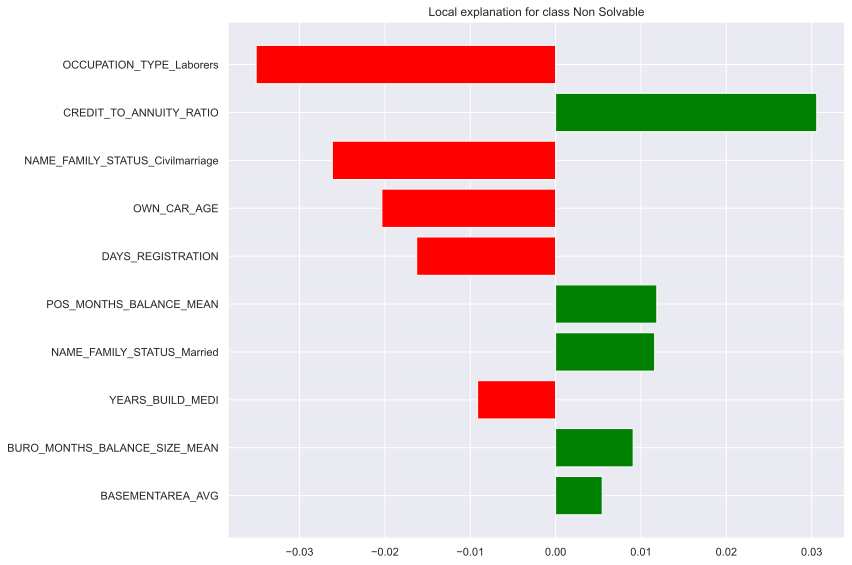

In [47]:
# Affichage des résultats
exp.show_in_notebook(show_table=False)

exp.as_pyplot_figure()
plt.tight_layout()

# Pipeline de prédiction

In [8]:
test_point=df.sample(50)
print("Result ")
display(test_point)

Result 


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,REFUSED_AMT_CREDIT_MIN,REFUSED_AMT_CREDIT_MAX,REFUSED_HOUR_APPR_PROCESS_START_MIN,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_CNT_PAYMENT_MEAN
299922,447459,0,0,1,0,675000,43267,675000,0.026392,-17723,...,0,0,0.000000,0,0,0,0,0,0.000000,0.000000
165507,291866,0,0,1,0,1540305,42484,1206000,0.072508,-13392,...,0,0,0.000000,0,0,0,0,0,0.000000,0.000000
269875,412784,0,0,1,0,203760,13149,180000,0.035792,-19469,...,0,0,0.000000,0,0,0,0,0,0.000000,0.000000
74116,185950,0,1,0,2,675000,32602,675000,0.009630,-12916,...,0,0,0.000000,0,0,0,0,0,0.000000,0.000000
174542,302273,0,1,0,2,360000,17640,360000,0.030755,-9891,...,0,0,0.000000,0,0,0,0,0,0.000000,0.000000
49801,157656,0,1,0,0,521280,25078,450000,0.031329,-23154,...,0,0,0.000000,0,0,0,0,0,0.000000,0.000000
118883,237859,0,1,0,0,135000,6750,135000,0.025164,-19928,...,0,0,0.000000,0,0,0,0,0,0.000000,0.000000
227309,363296,1,1,0,0,1078200,31522,900000,0.030755,-15845,...,0,0,0.000000,0,0,0,0,0,0.000000,0.000000
226888,362815,0,1,0,0,337500,18436,337500,0.018209,-8523,...,0,0,0.000000,0,0,0,0,0,0.000000,0.000000
163621,289677,1,0,0,0,261000,10800,261000,0.031329,-15084,...,0,0,0.000000,0,0,0,0,0,0.000000,0.000000


In [38]:
with open('site/model.pkl','wb') as file:
    pickle.dump(clf, file)
with open('site/test_sample.pkl','wb') as file:
    pickle.dump(test_point, file)
with open('site/interpretabilite.py','wb') as file:
    pickle.dump(interpretabilite, file)

In [48]:
with open('site/interpretabilite.py','wb') as file:
    pickle.dump(interpretabilite, file)